# Курс "Методы современной прикладной статистики"
# 3 курс ФПМИ МФТИ, весна 2022
## Домашнее задание 10. Нелинейные модели регриссии.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as spss
import seaborn as sns
import pandas as pd
sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline
%config InlineBackend.figure_format="retina"  # only for retina display

In [2]:
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize, fmin

In [3]:
import sklearn
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn import metrics
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning

In [5]:
"""The :mod:`sklearn.kernel_regressor` module implements the Kernel Regressor.
"""
# Author: Jan Hendrik Metzen <janmetzen@mailbox.de>
#
# License: BSD 3 clause

import numpy as np

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin


class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.

    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.

    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.

    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.

    See also
    --------

    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values

        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

### Задача 1

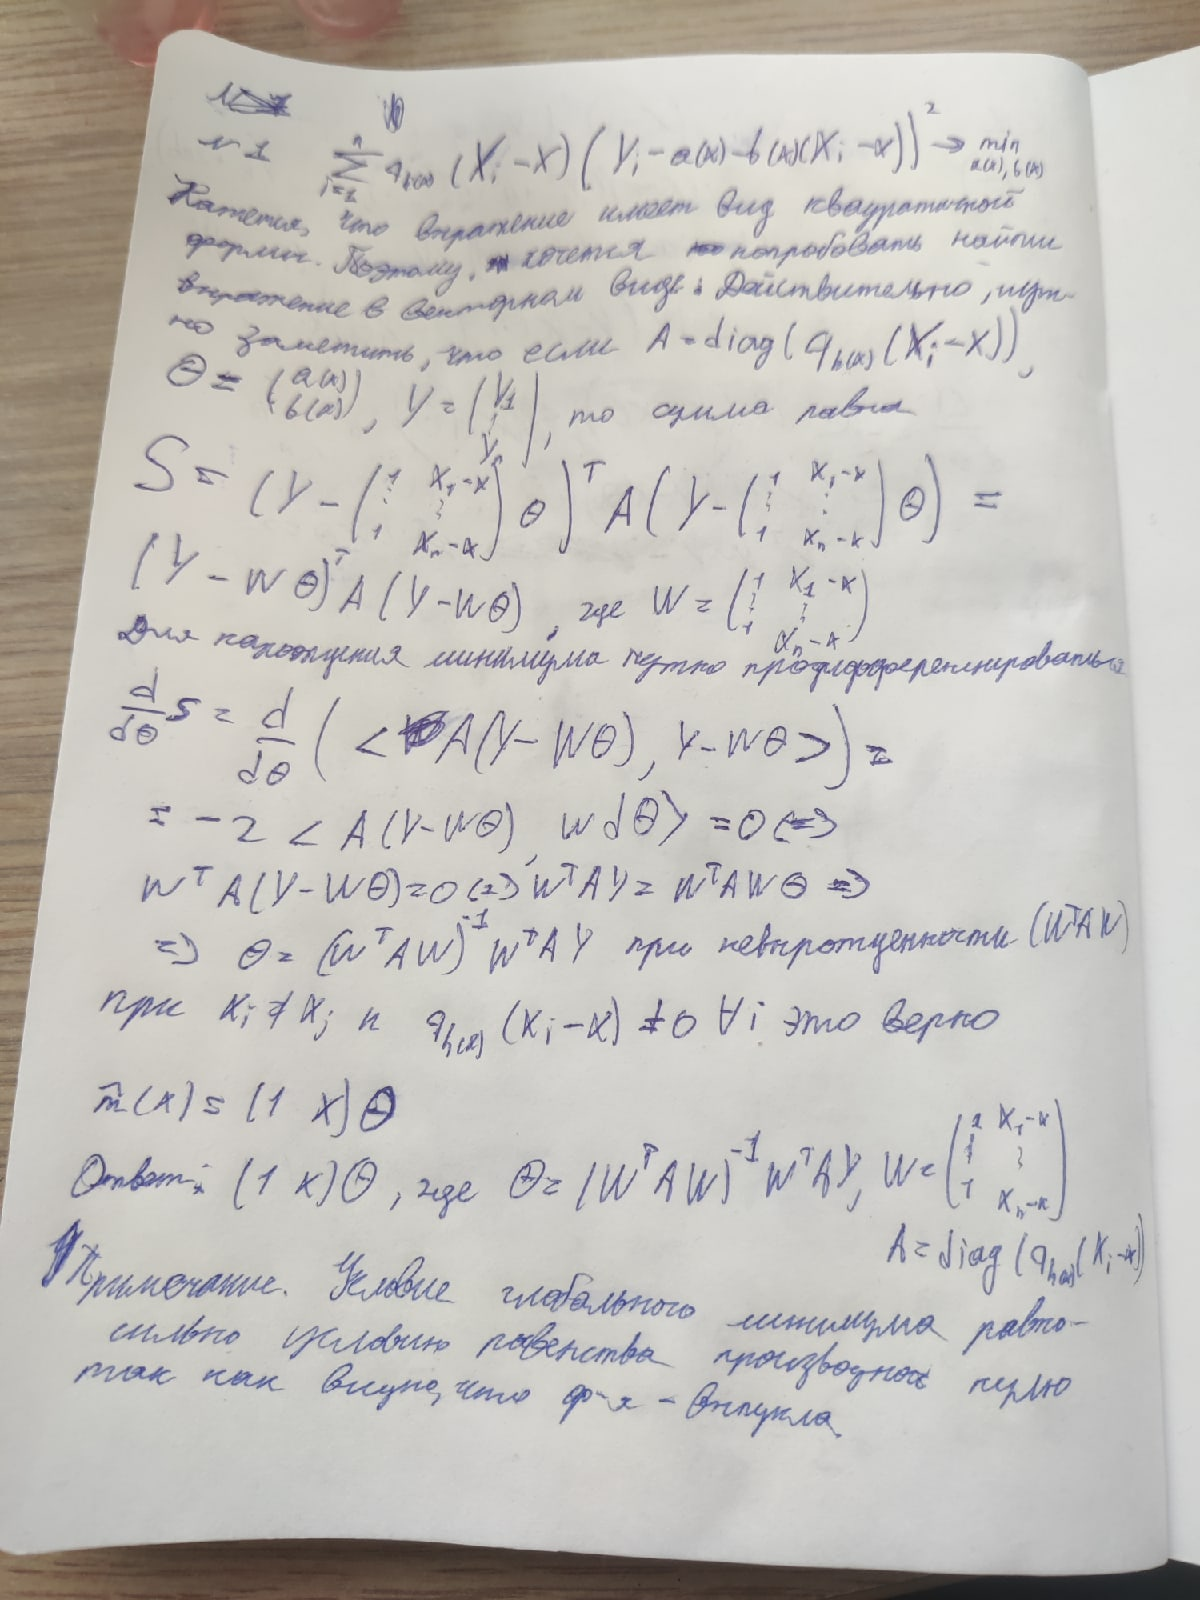

### Задача 2

считаем данные, посмотрим на гистограмму.

In [6]:
data = pd.read_table('glass.dat', sep="\s+")

In [7]:
data.columns

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'type'], dtype='object')

In [8]:
data = data['RI']
data.shape

(214,)

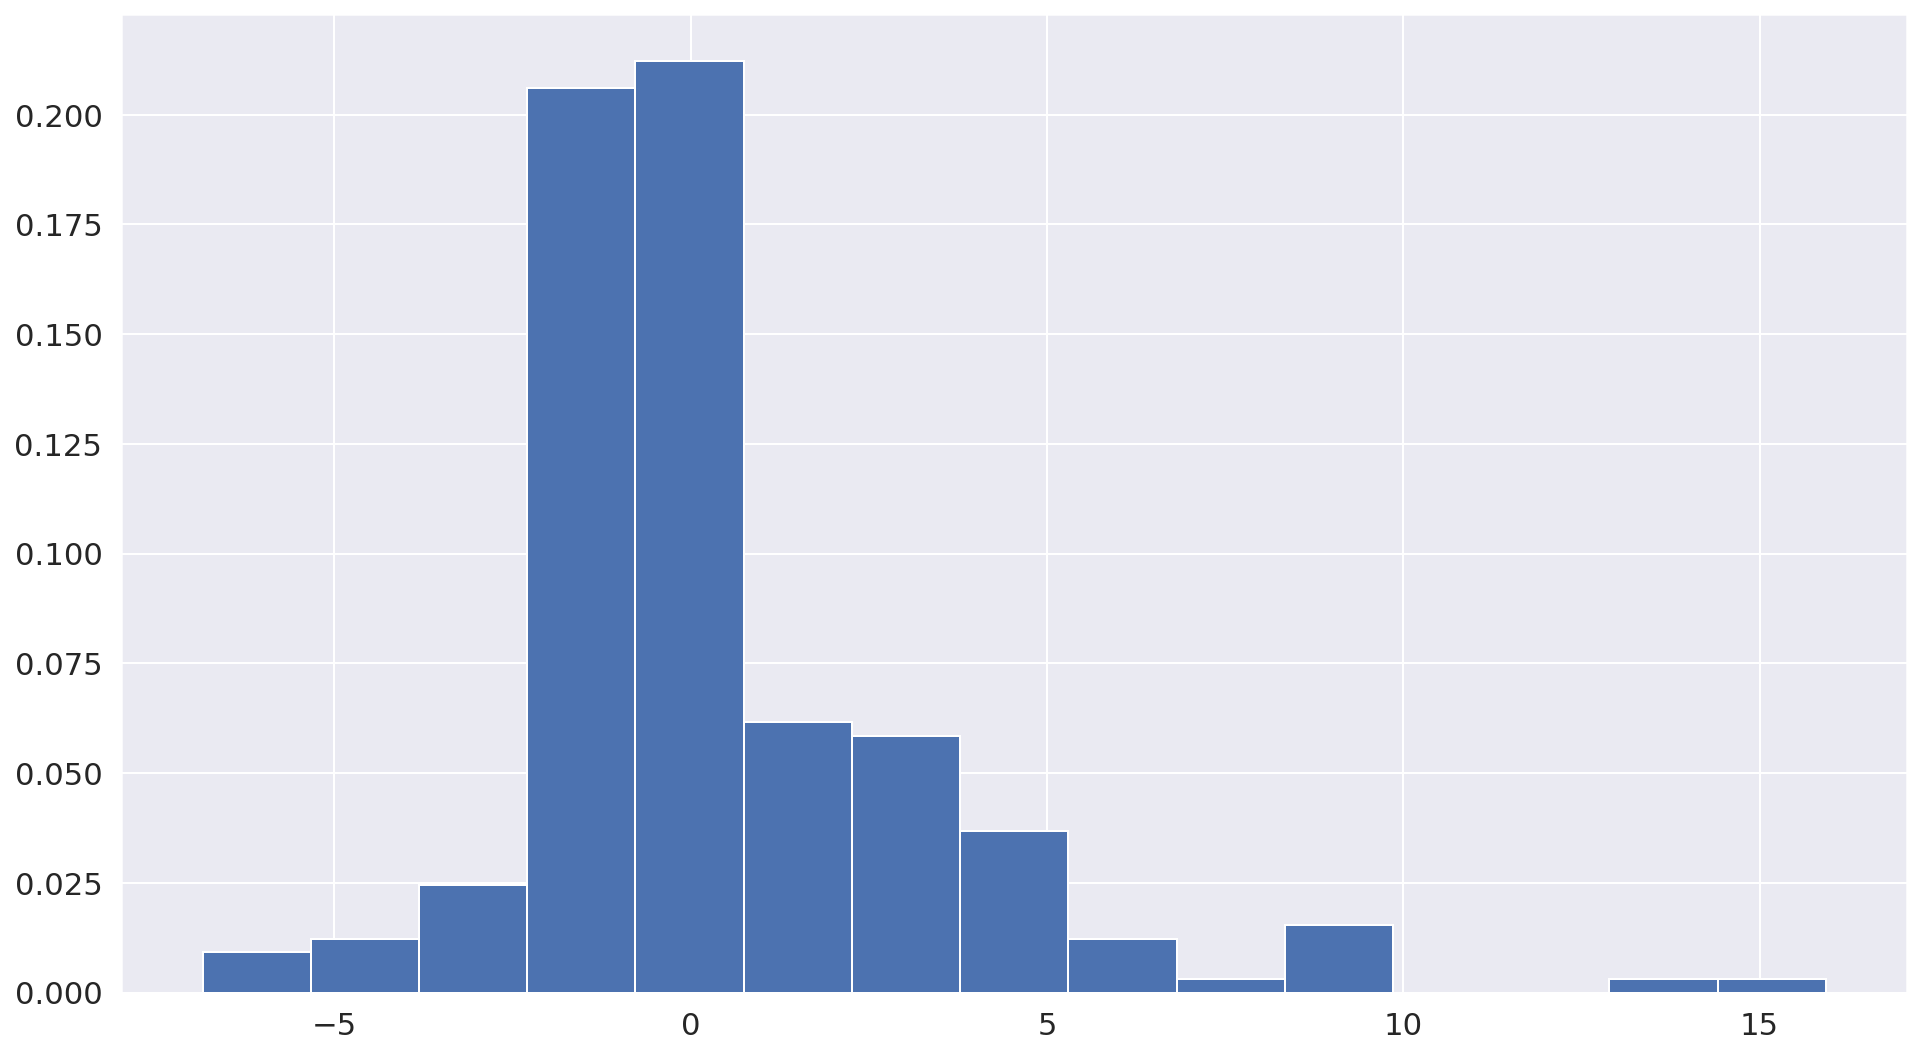

In [9]:
plt.figure(figsize = (16, 9))
plt.hist(data, bins = 15, density = True)
plt.show()

In [10]:
import statsmodels.nonparametric.kde as kde

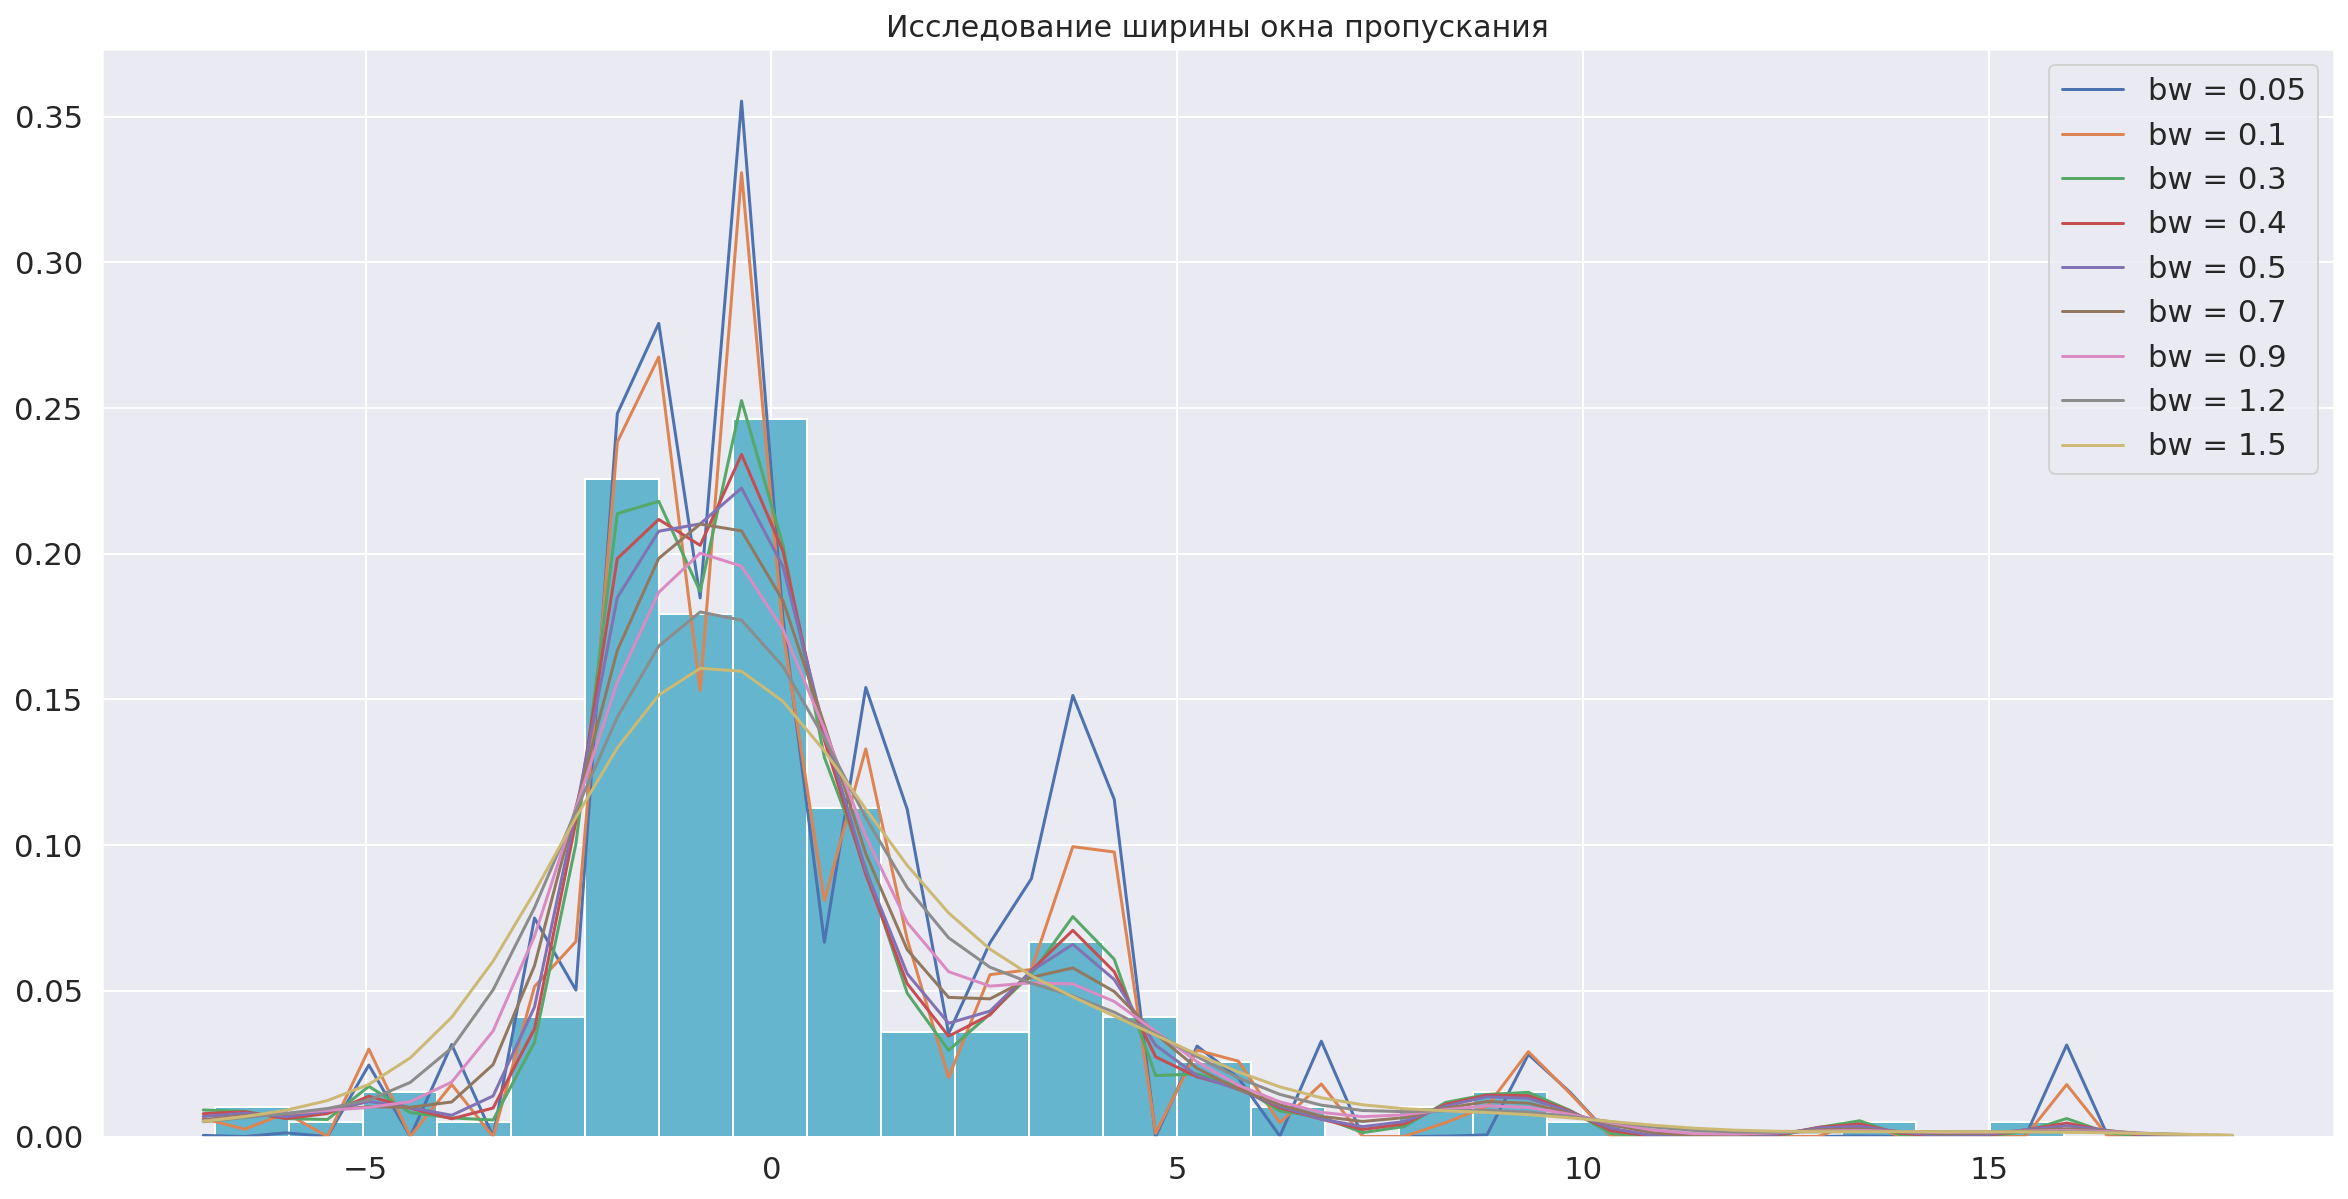

In [11]:
np.random.seed(1234)  
plt.figure(figsize=(20, 10))
dens = kde.KDEUnivariate(data)

for bw in [0.05,0.1, 0.3, 0.4, 0.5, 0.7, 0.9, 1.2, 1.5]:
    dens.fit(bw=bw)
    plt.plot(np.linspace(-7, 18), dens.evaluate(np.linspace(-7, 18)), label='bw = {}'.format(bw))
    
plt.hist(data, bins = 25, density = True)
plt.title("Исследование ширины окна пропускания", fontsize=15)
plt.legend();

Как видим, лучше всего себя показывает окно размера 0.5. Оно достаточно неплохо описывает данные, при этом достаточно гладкое. А так впринципе окна от 0.3 до 0.7 ведут себя неплохо.

Нужно построить доверительный интервал. К сожалению неизвестно, как данный интервал искать. Поэтому будем строить бутстрепный центральный доверительный интервал.

In [12]:
def calc_central(sample, grid, ker, bw, al = 0.05):
    bootstrap = np.random.choice(sample, size=(len(sample), len(sample)))
    ked = kde.KDEUnivariate(sample)
    ked.fit(kernel=ker,bw=bw)
    main = ked.evaluate(grid)
    results = []
    for sam in bootstrap:
        boot = kde.KDEUnivariate(sam)
        boot.fit(kernel=ker, bw=bw)
        results.append(boot.evaluate(grid))
    results = np.array(results).T
    results = np.sort(results)
    low, up = results[:, int((al / 2) * len(sample))], results[:, int((1 - al / 2) * len(sample))] 
    return 2  * main - up, 2 * main - low

In [13]:
l, u = calc_central(data, np.linspace(-7, 18), 'gau', 0.5)

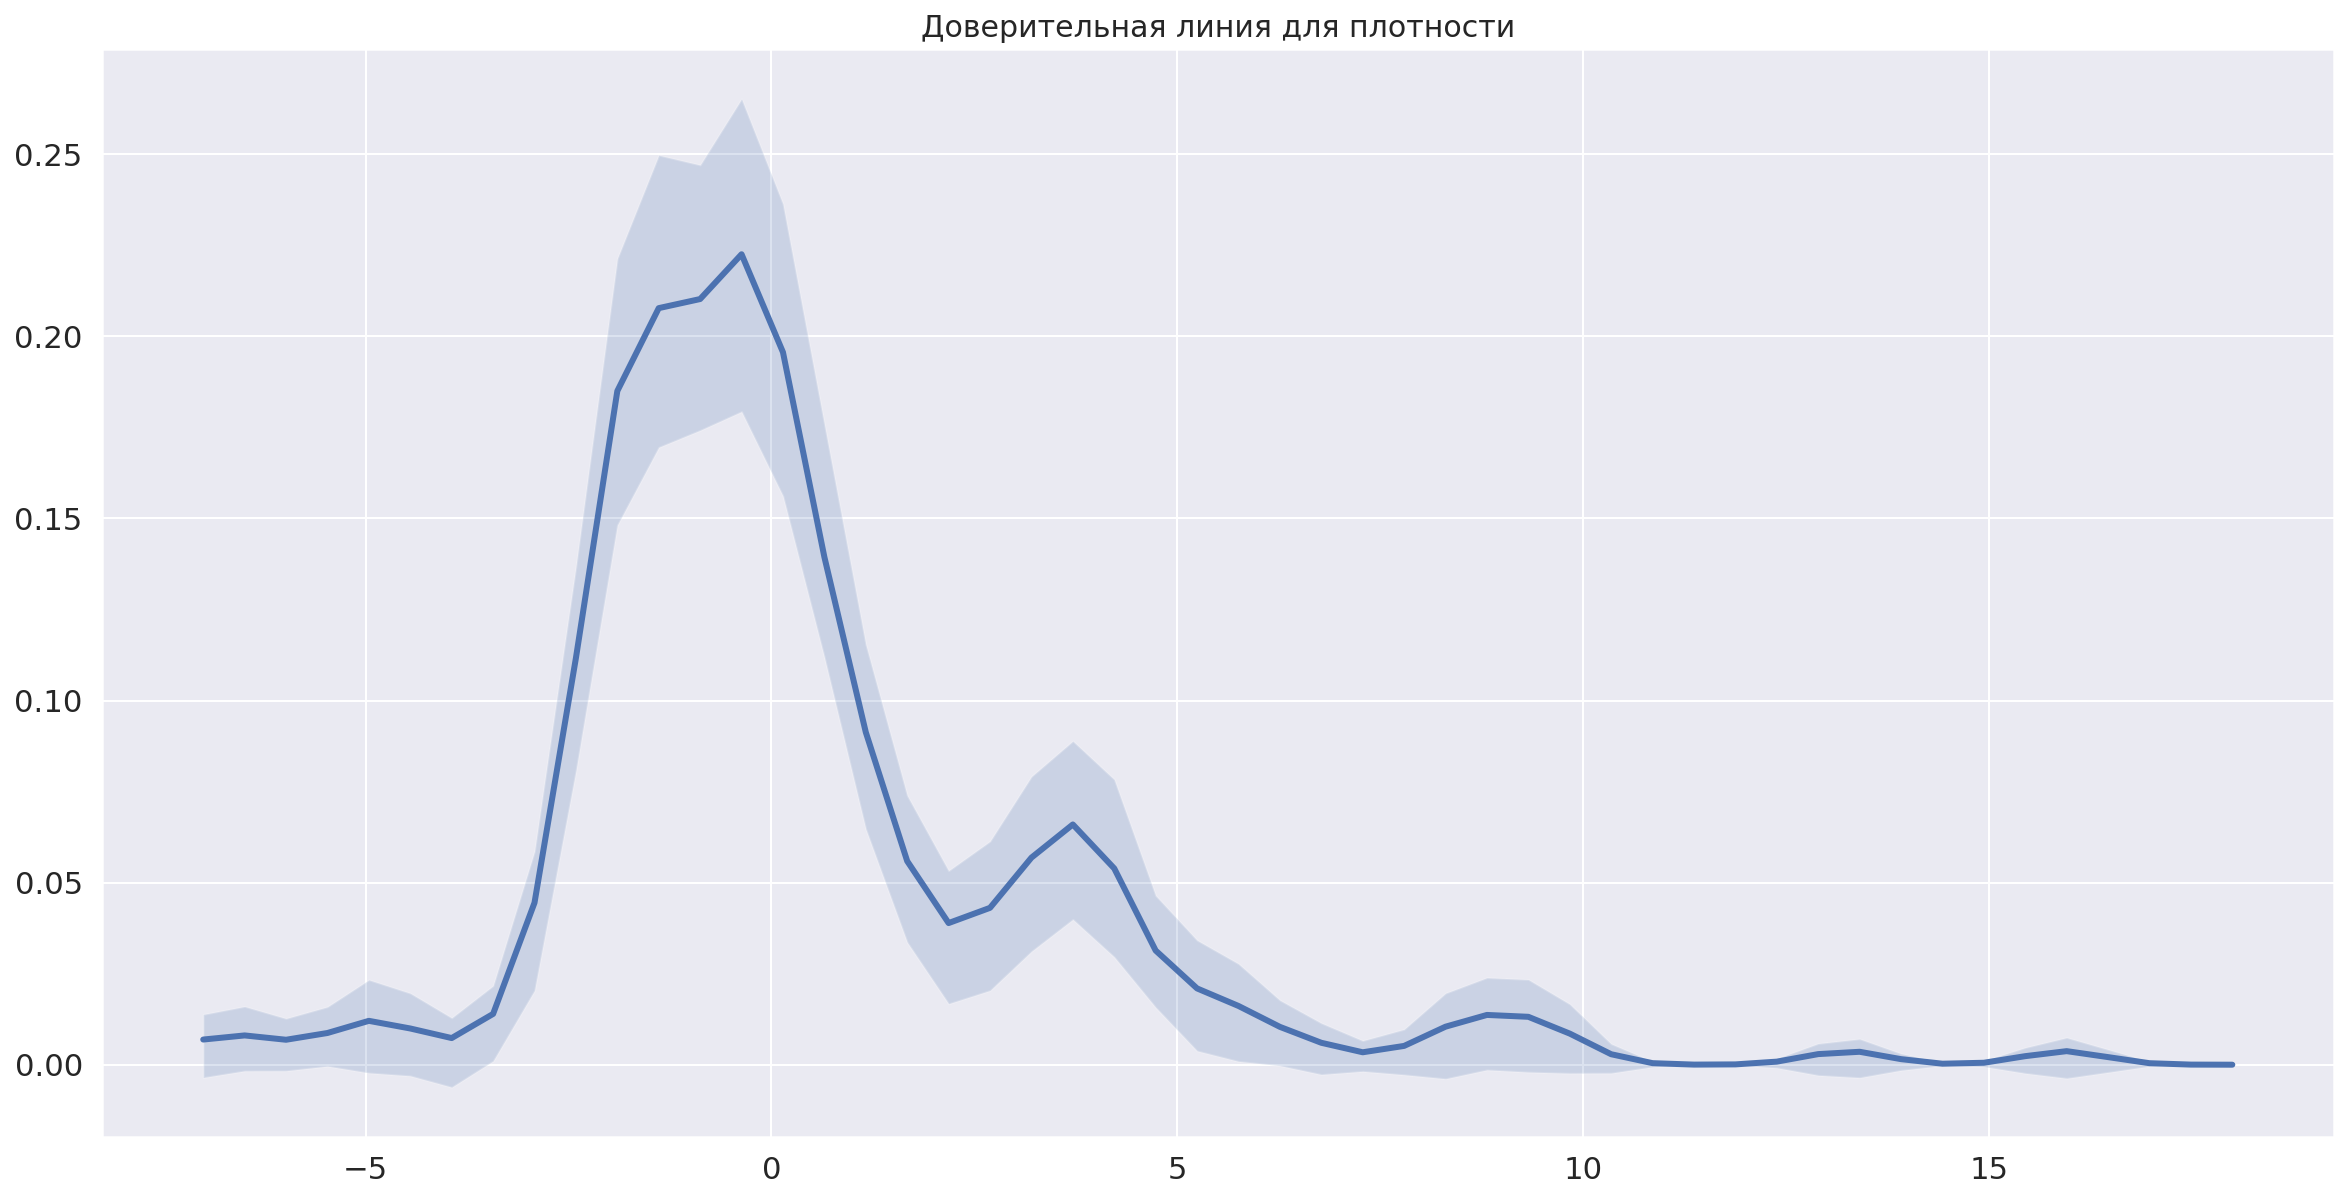

In [14]:
np.random.seed(1234)  
plt.figure(figsize=(20, 10))
dens = kde.KDEUnivariate(data)
bw = 0.5
dens.fit(bw=bw)
plt.plot(np.linspace(-7, 18), dens.evaluate(np.linspace(-7, 18)), linewidth = 3)
plt.fill_between(np.linspace(-7, 18), l, u, alpha = 0.2) 
plt.title("Доверительная линия для плотности", fontsize=15)
plt.show()

### Задача 3

Нвчнем с теории. Зачем же нам штрафовать модель за размер второй производной? Ответ кроется в свойствах линейной функции и общем наблюдении за функциями плотности, которые встречаются. Во-первых, большинство плотностей гладкие, у них обычно нету диких скачков. Скачки, очевидно, сильно коррелируют с понятием "нелинейности функции". При этом, линейная функция имеет нулевую вторую производную. Таким образом, мы добавляя штраф ввиде второй производной, мы контроллируем "гладкость функции". Отсюда получается ответ на вопрос, как выбрать $h$. Достаточно взять некоторую сетку от $h$, посмотреть на графики и найти наилучший график в соотношении "описывание данных/гладкость".

In [15]:
data = pd.read_csv("hw10t3.csv")

In [16]:
data

Unnamed: 0         y         x
0             0  0.064771  0.180249
1             1 -0.683449 -0.811201
2             2  0.501485 -0.616333
3             3  0.263588 -0.749556
4             4 -0.323165 -0.414561
..          ...       ...       ...
295         295  0.189952  0.123668
296         296 -0.099252  0.011565
297         297 -0.606335  0.972131
298         298 -0.245234 -0.836449
299         299 -0.388703 -0.475779

[300 rows x 3 columns]

In [17]:
x = data['x'].values
y = data['y'].values
gammas = [1, 5, 10, 20, 40, 60, 100, 150]
kernels = ['rbf', 'laplacian']

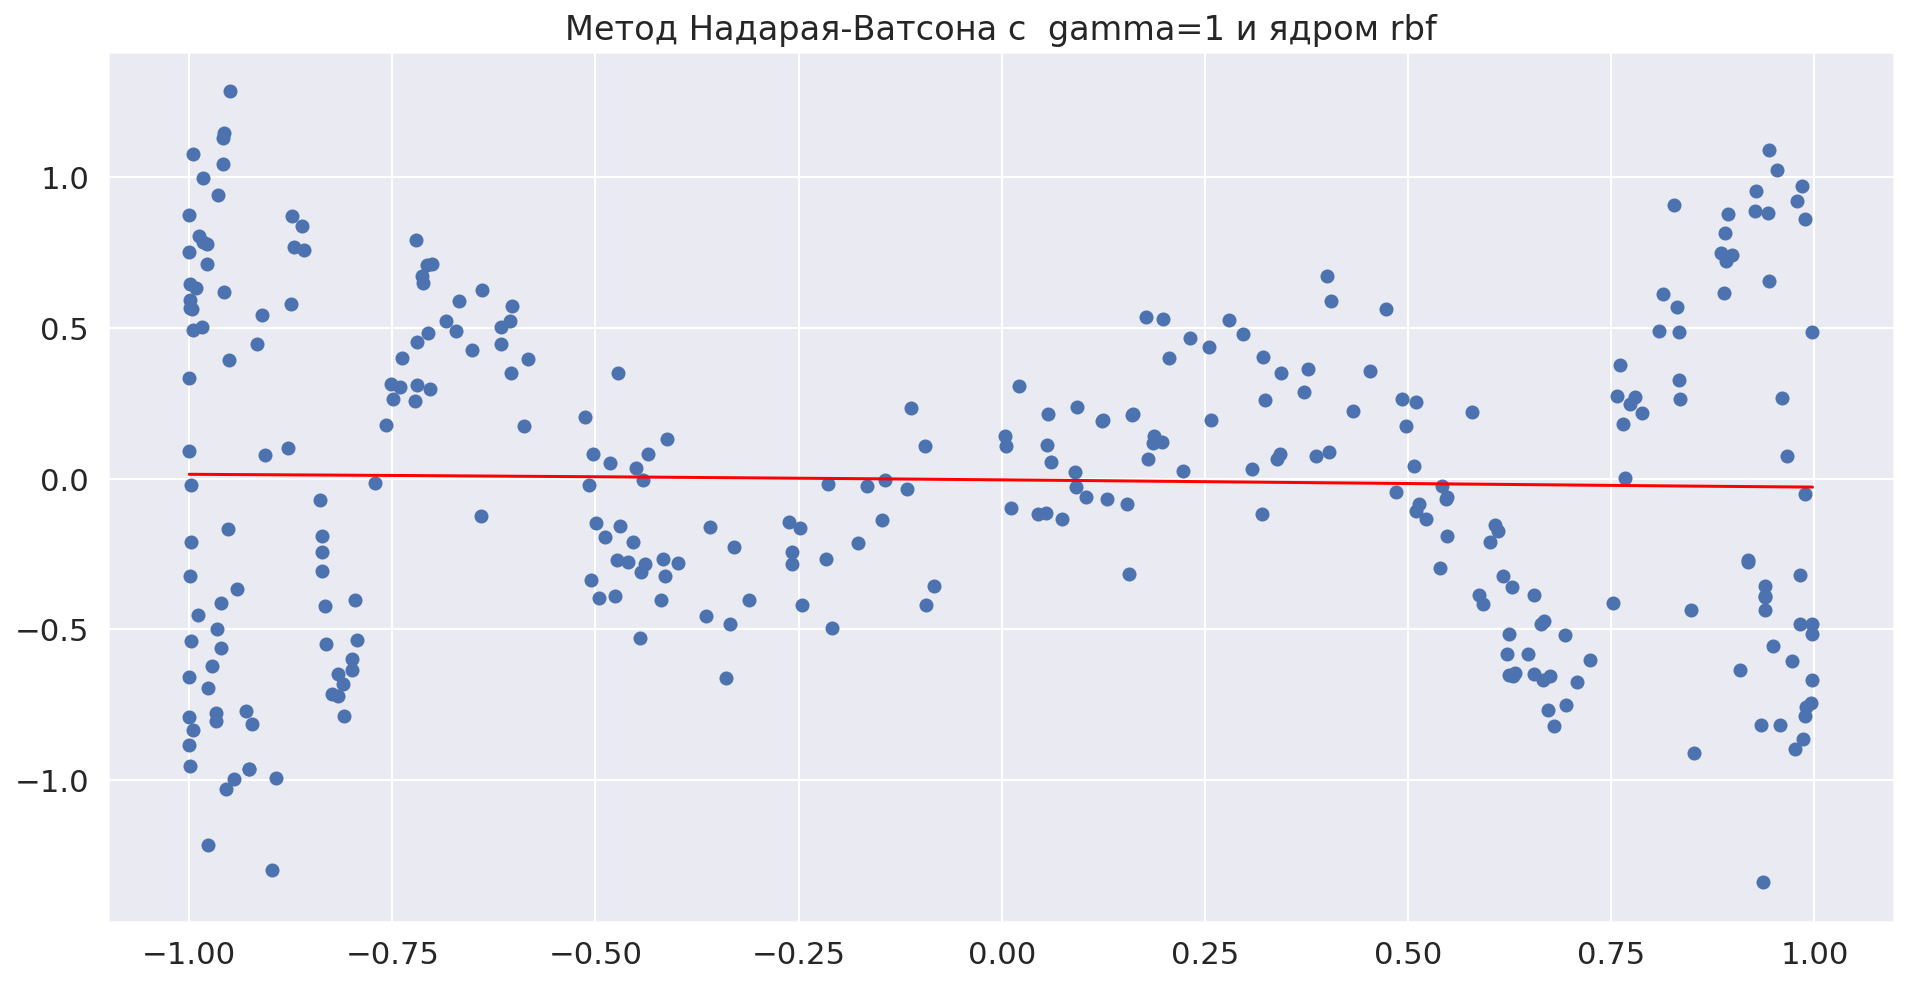

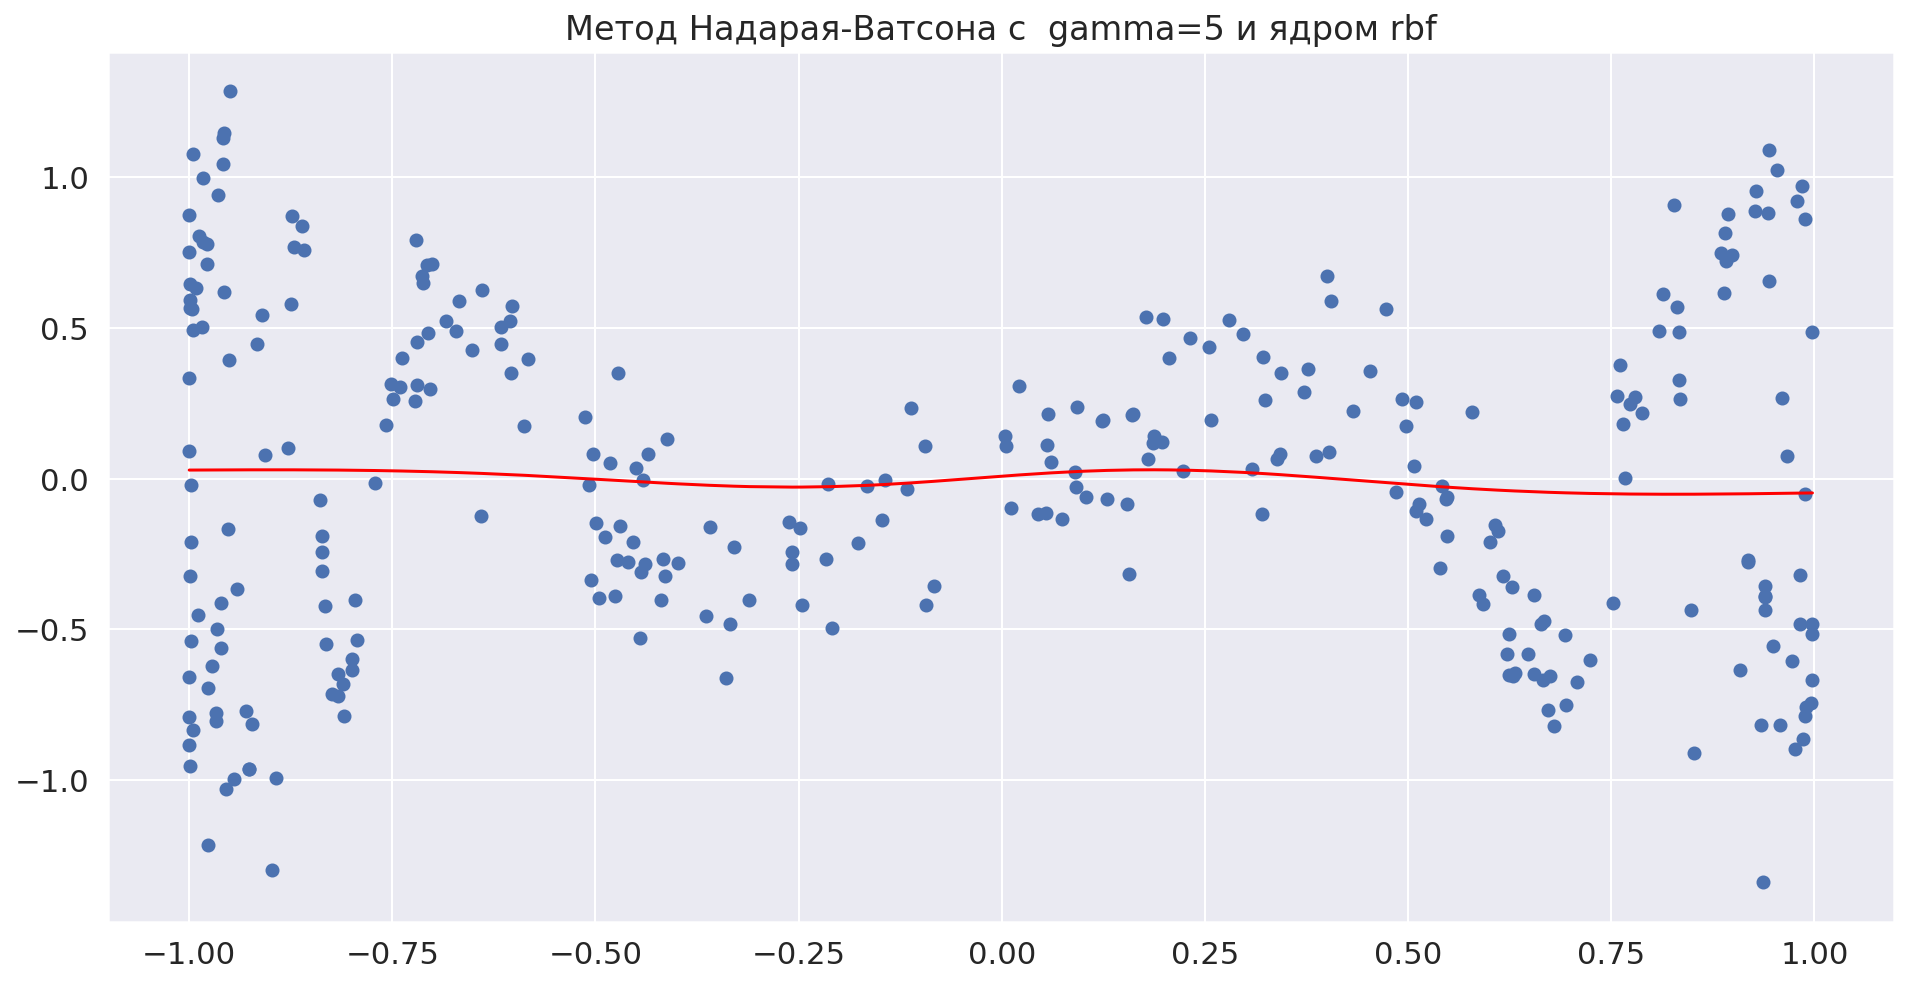

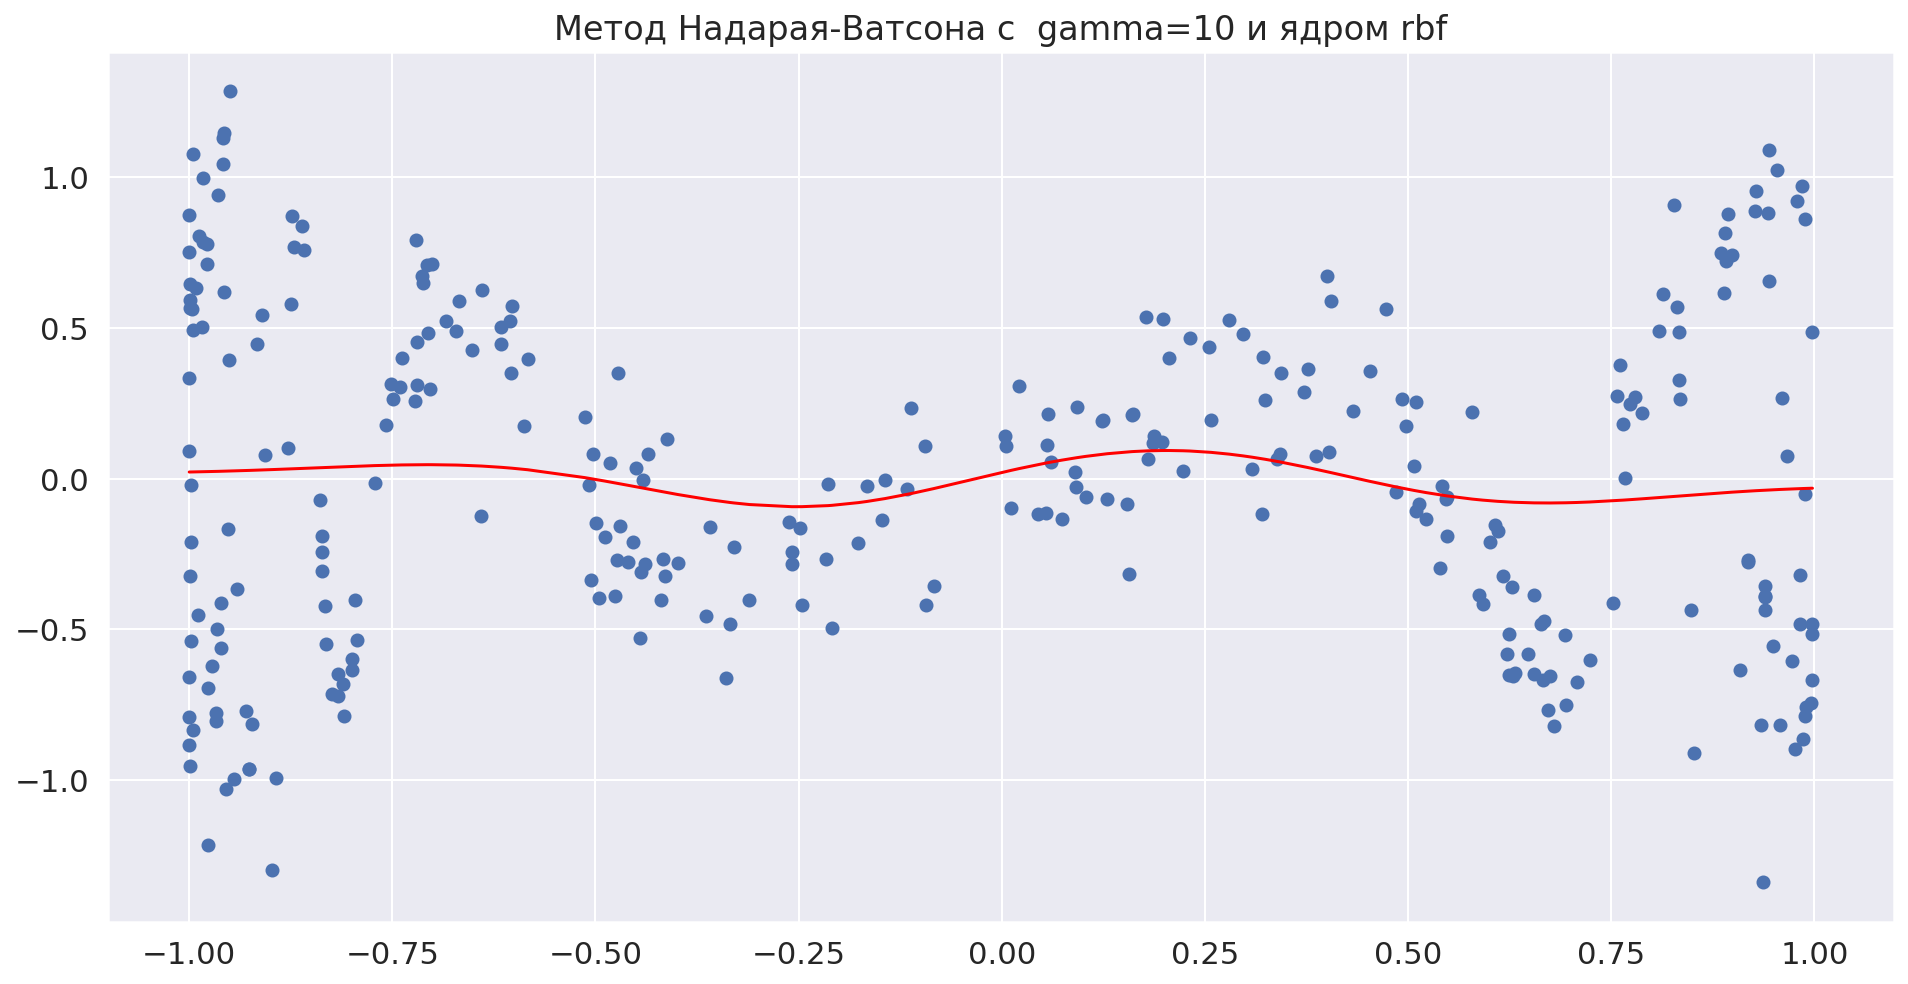

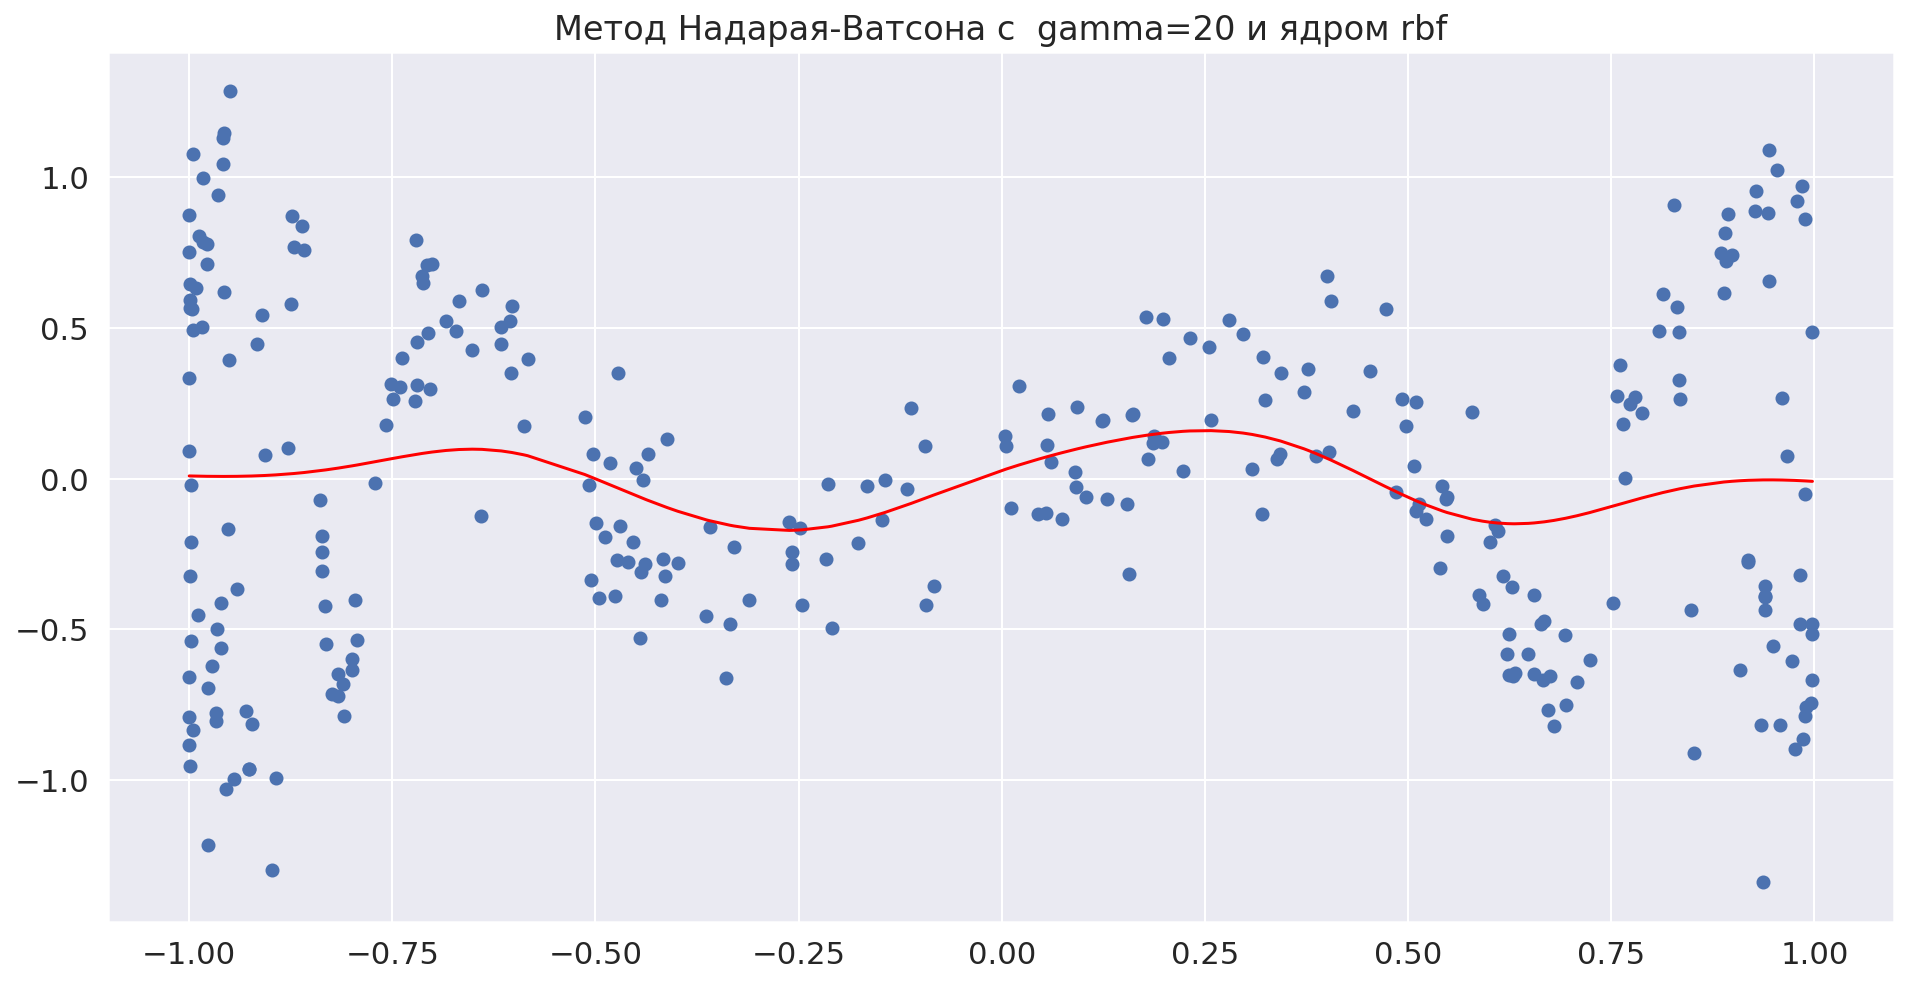

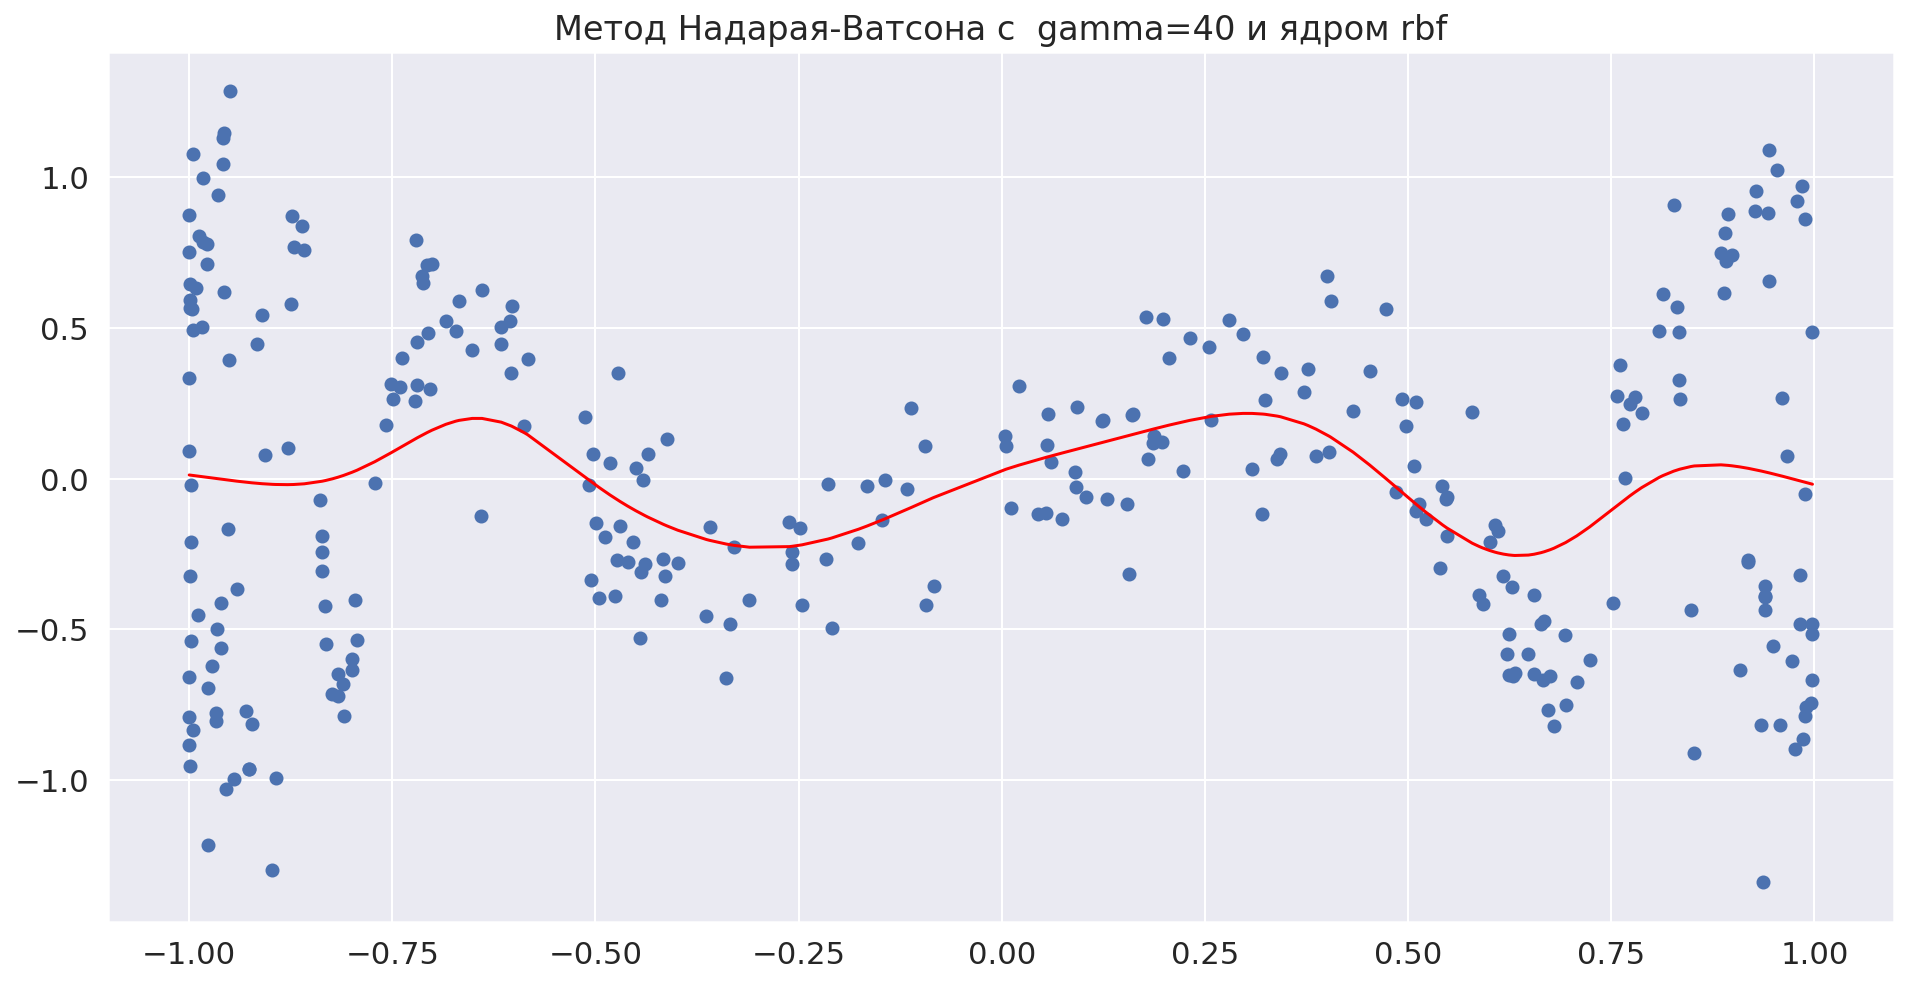

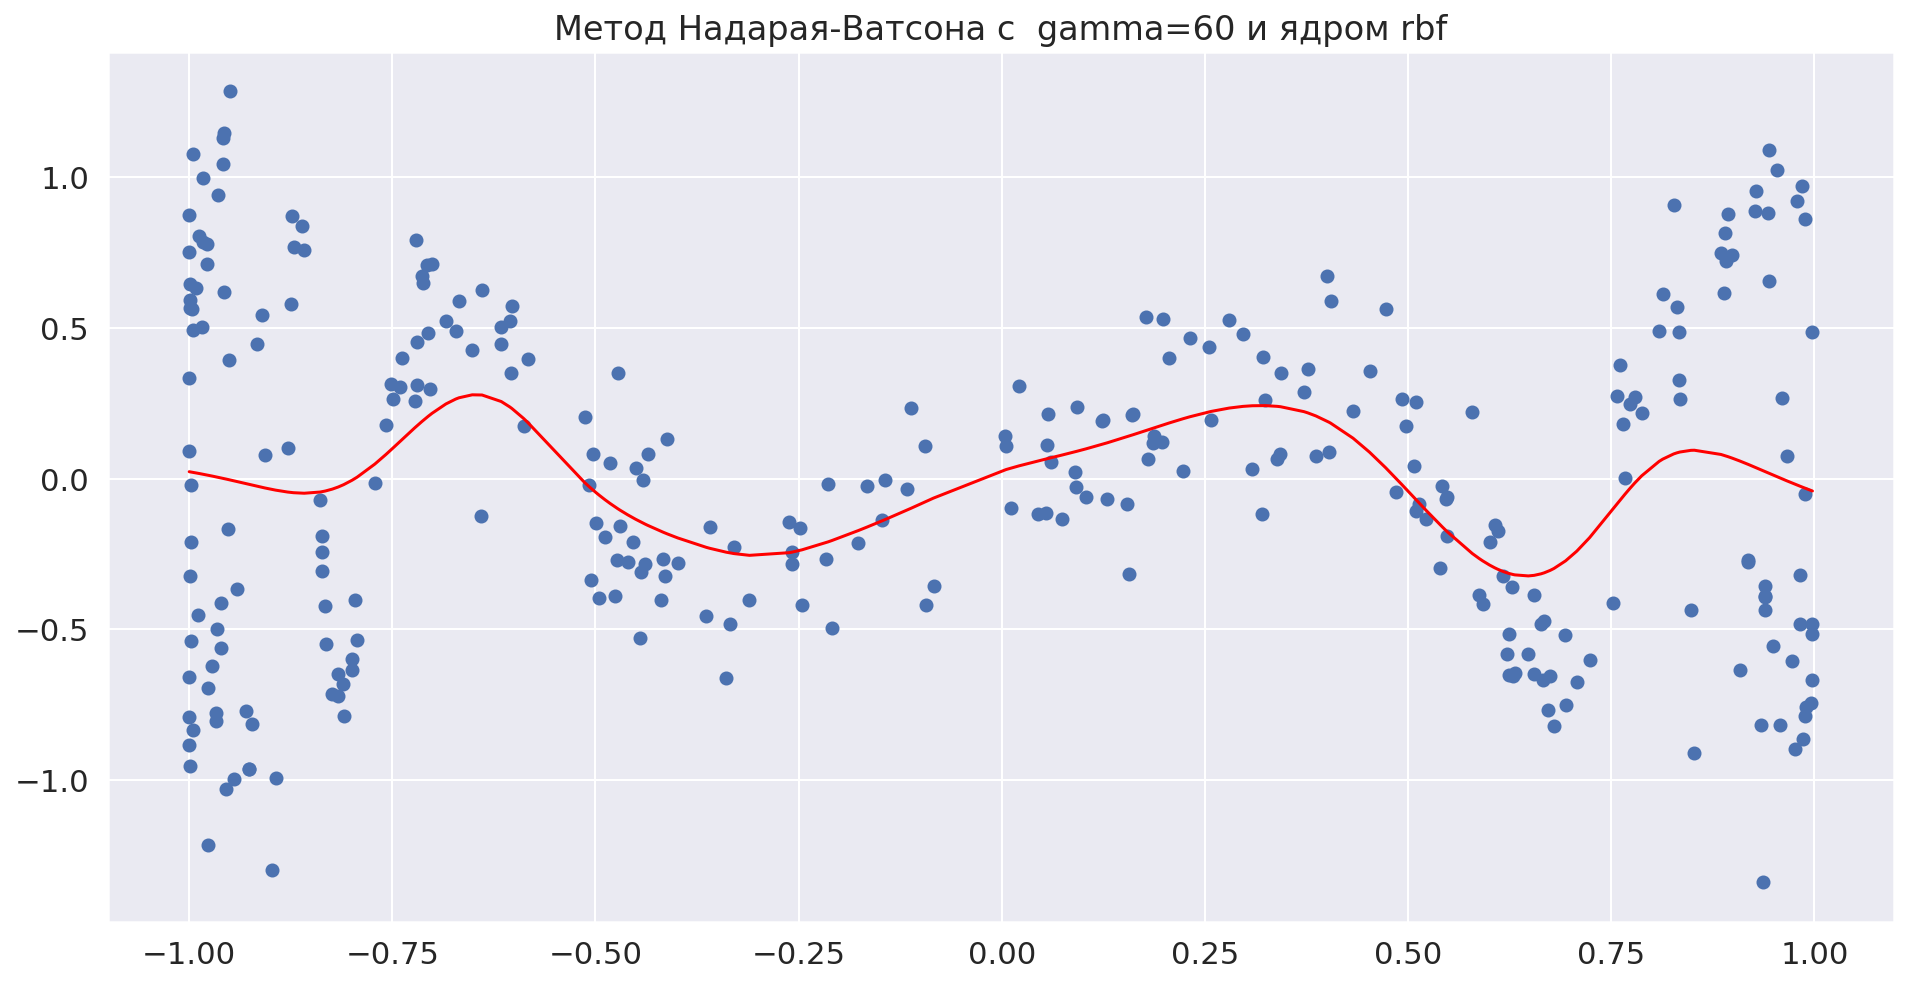

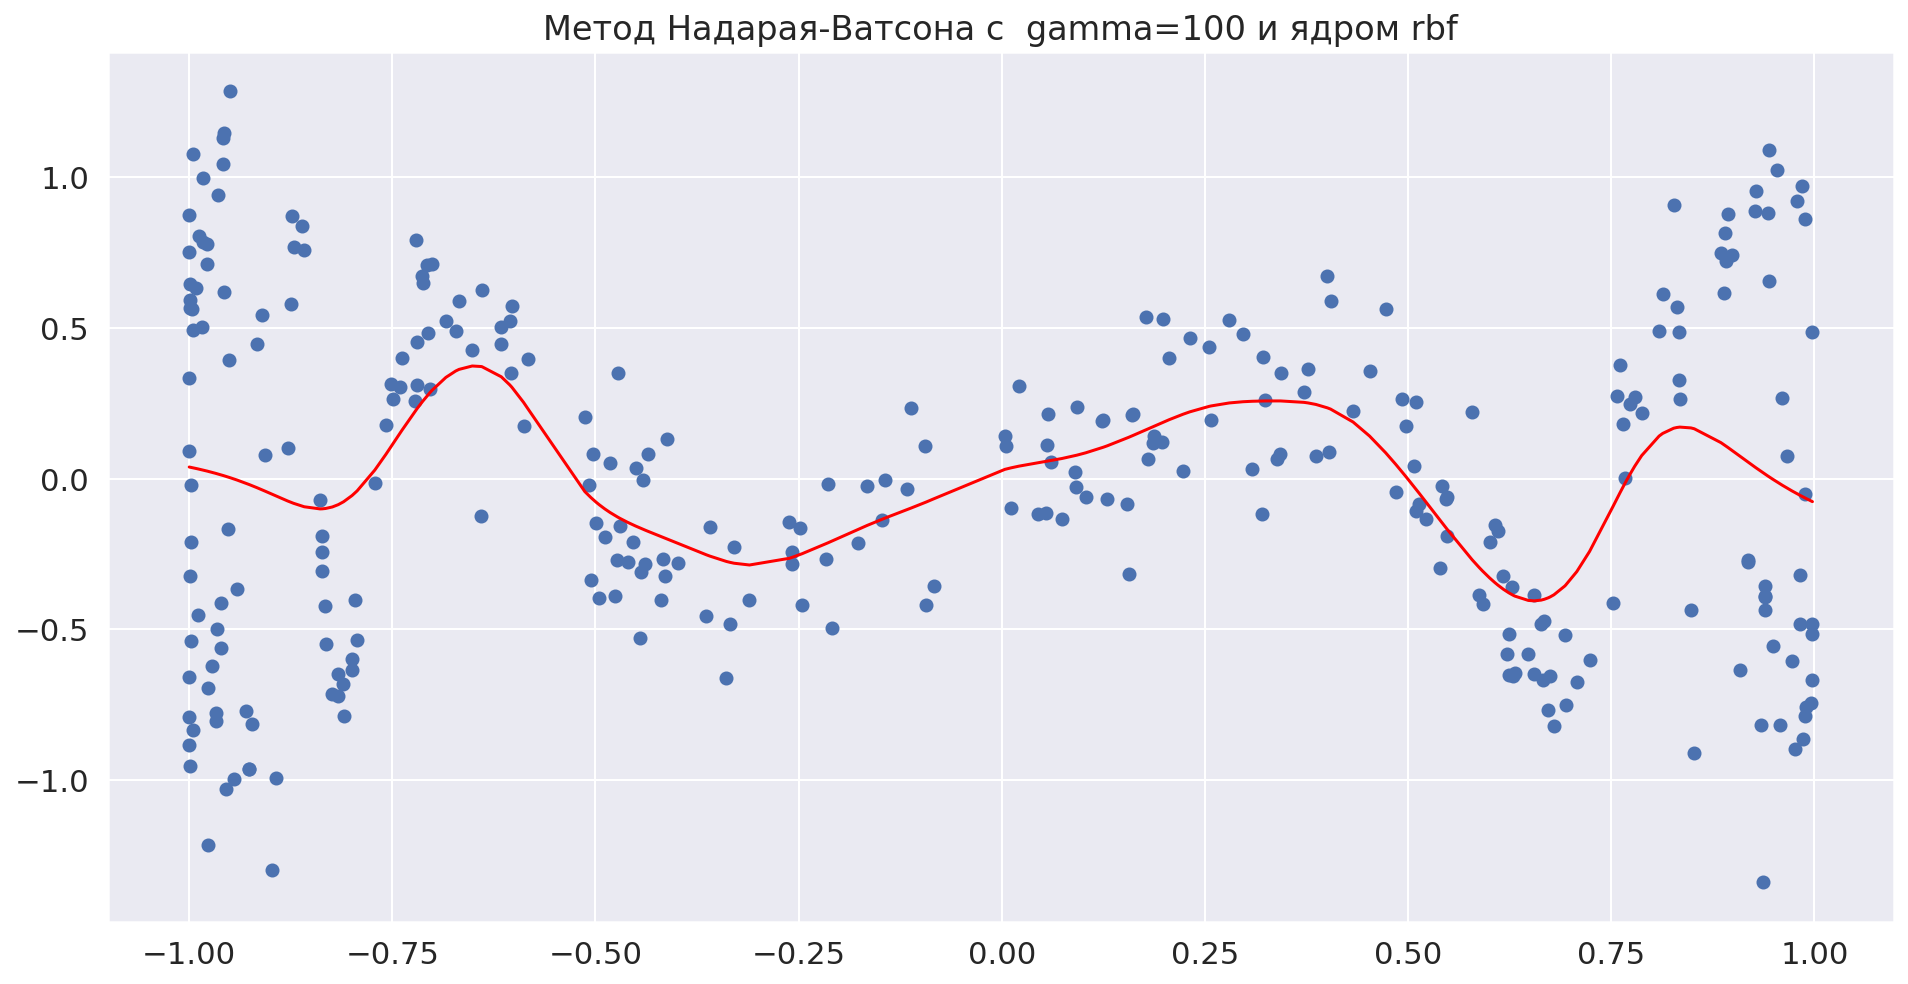

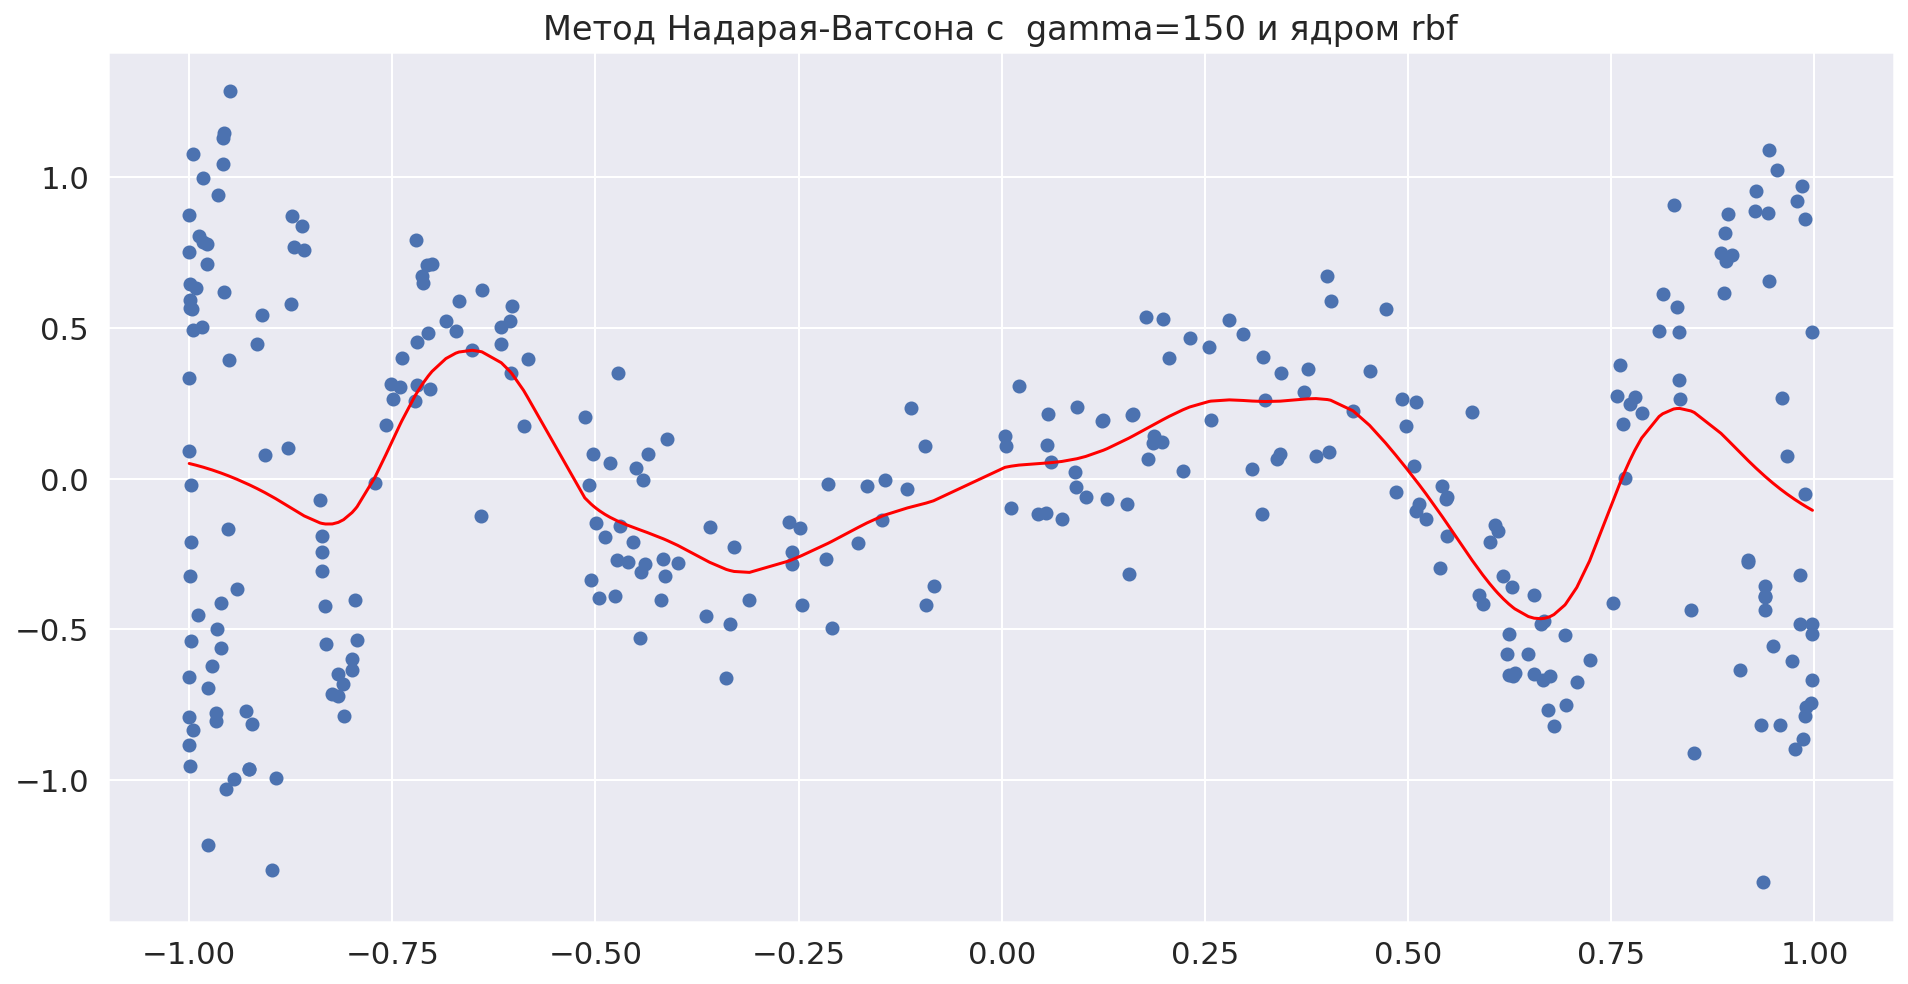

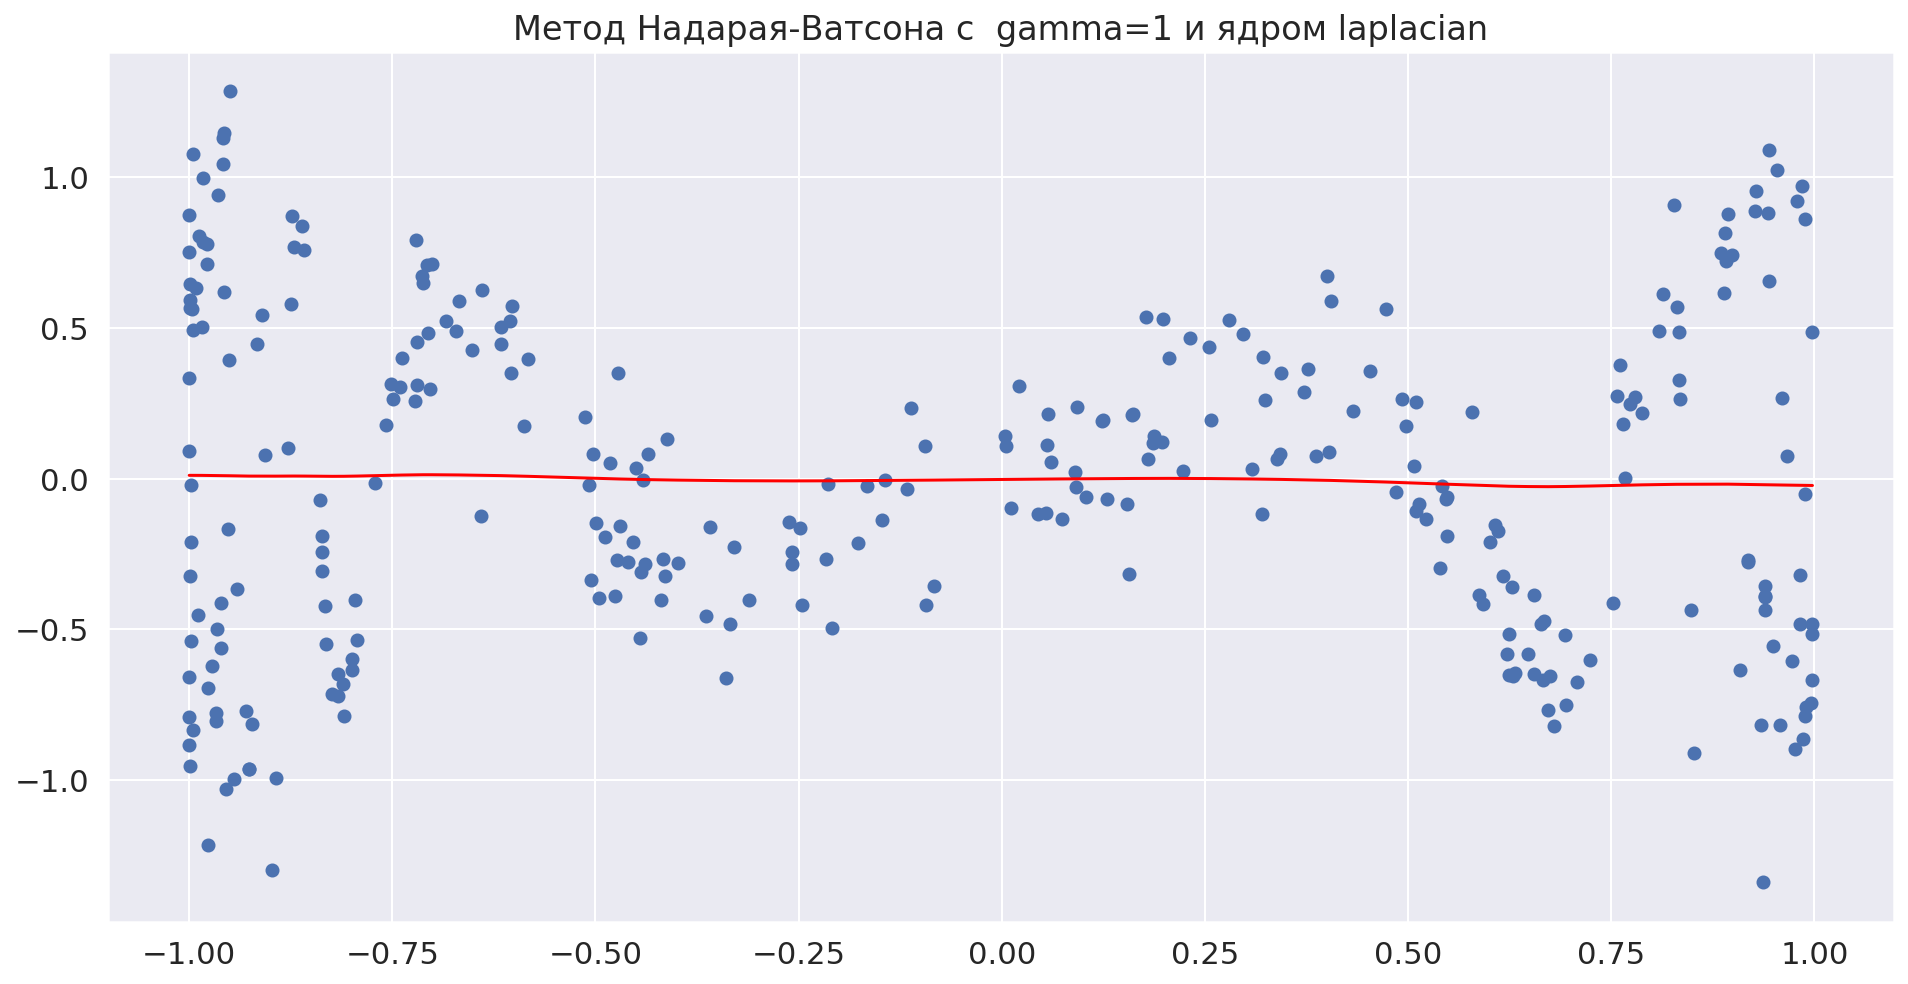

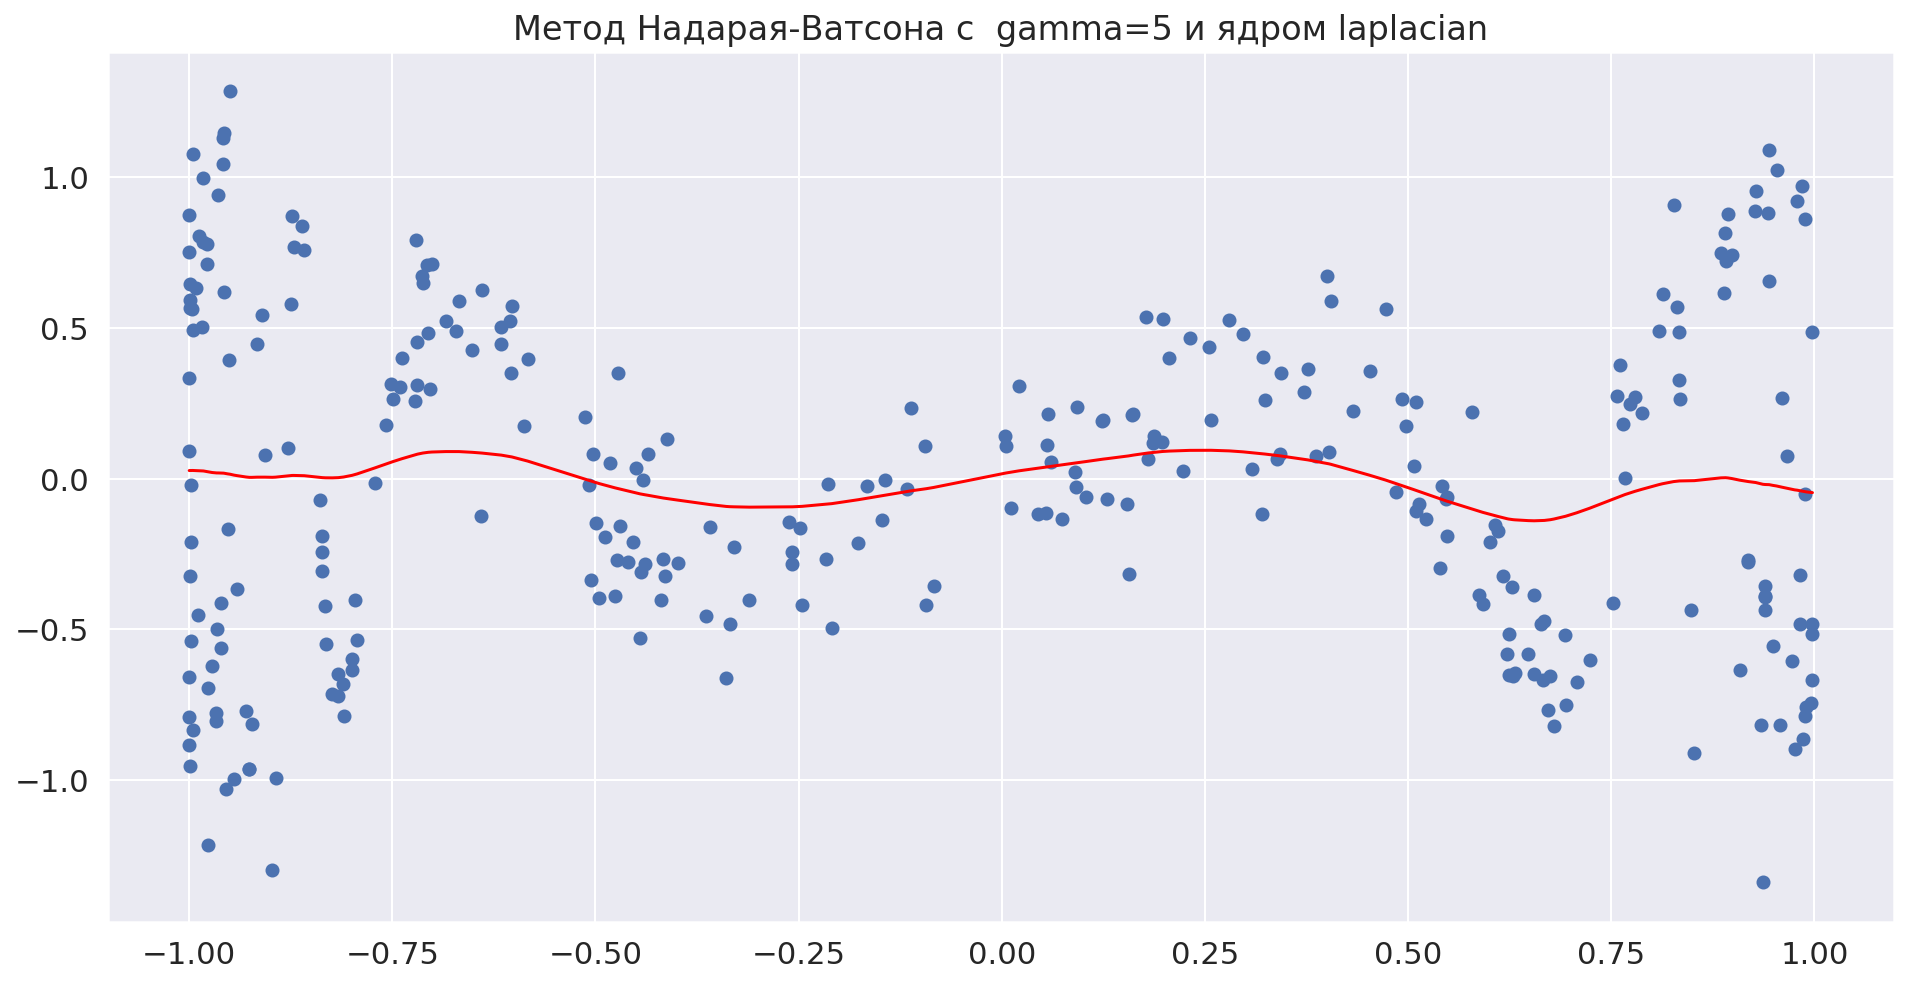

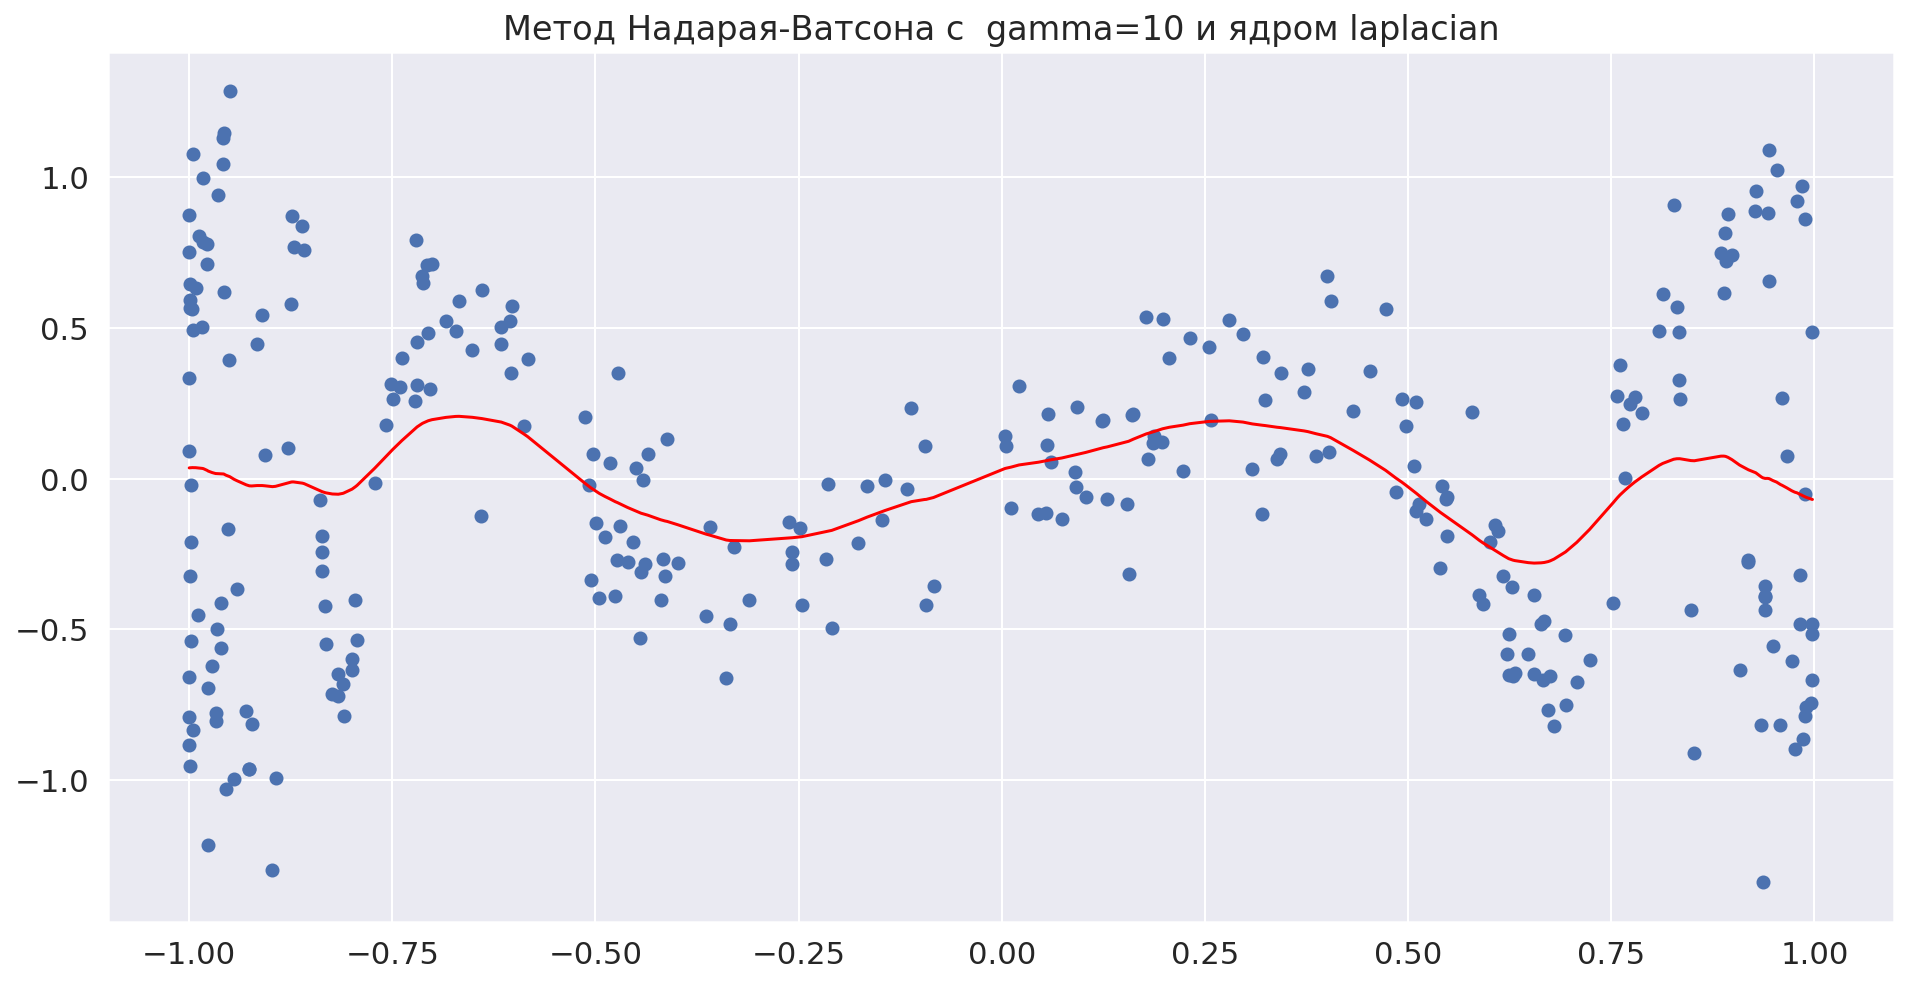

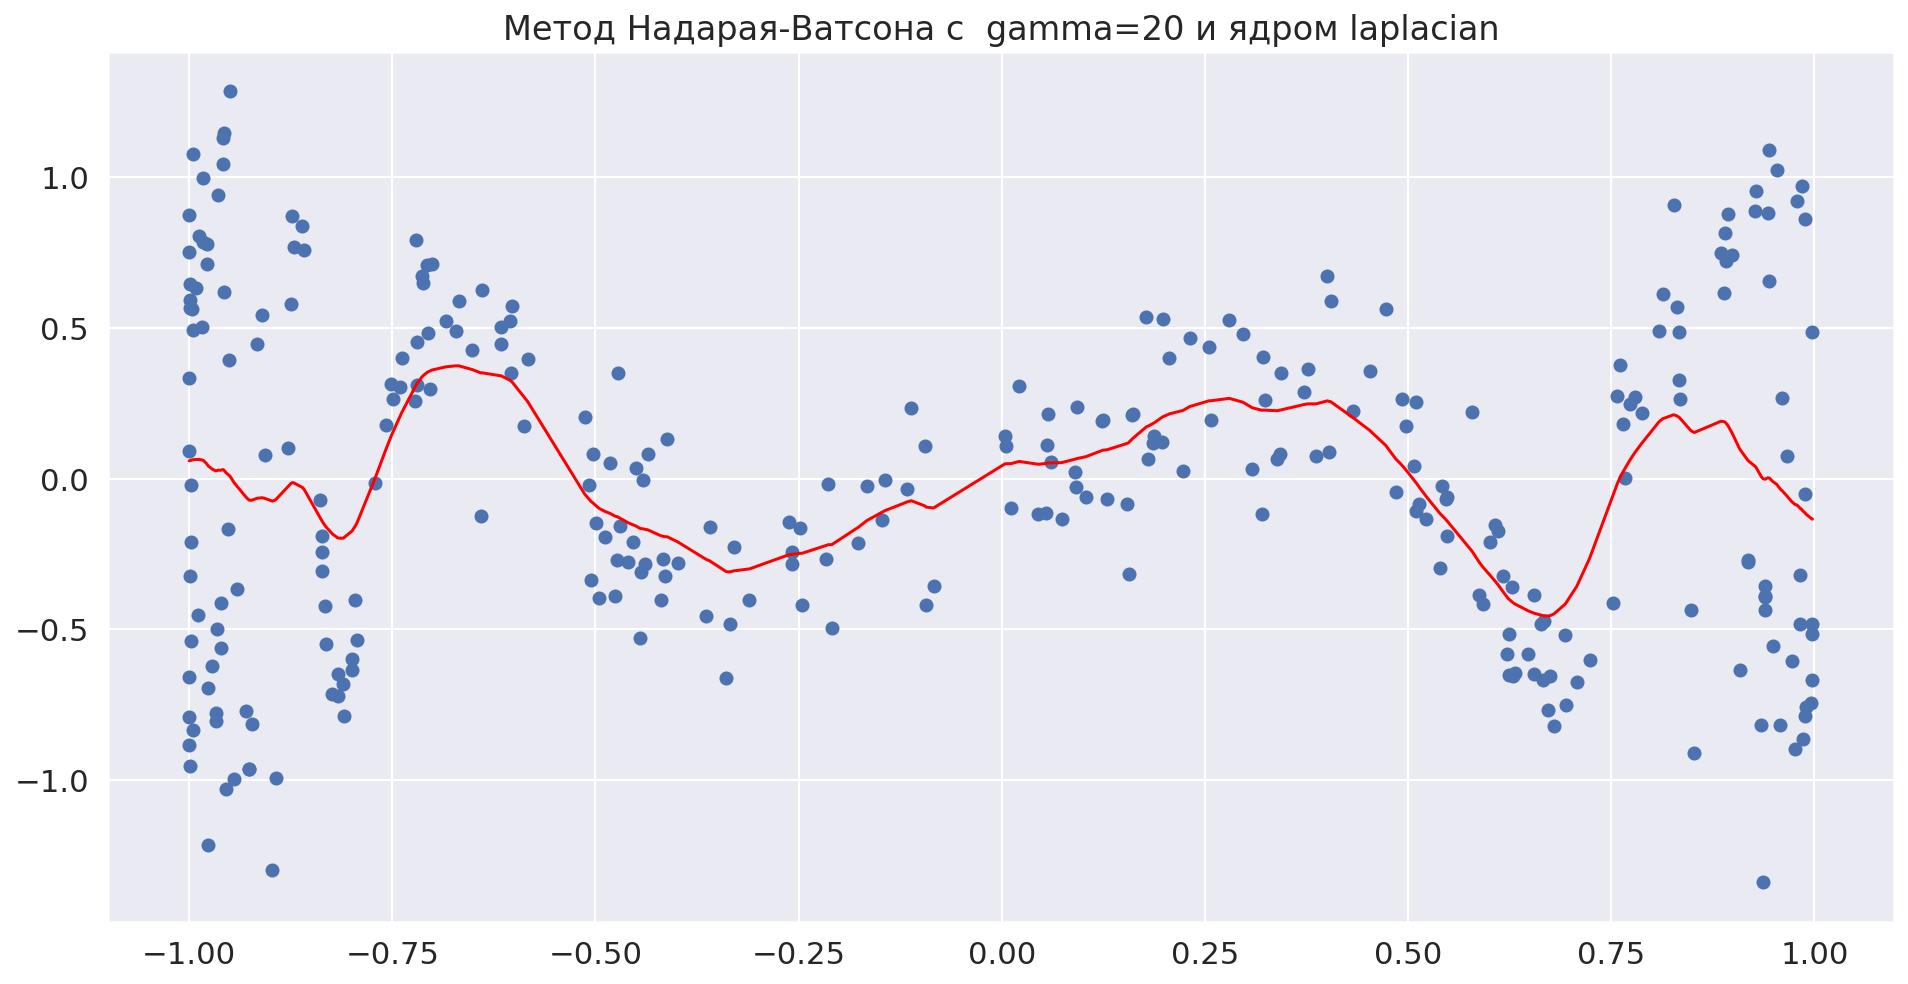

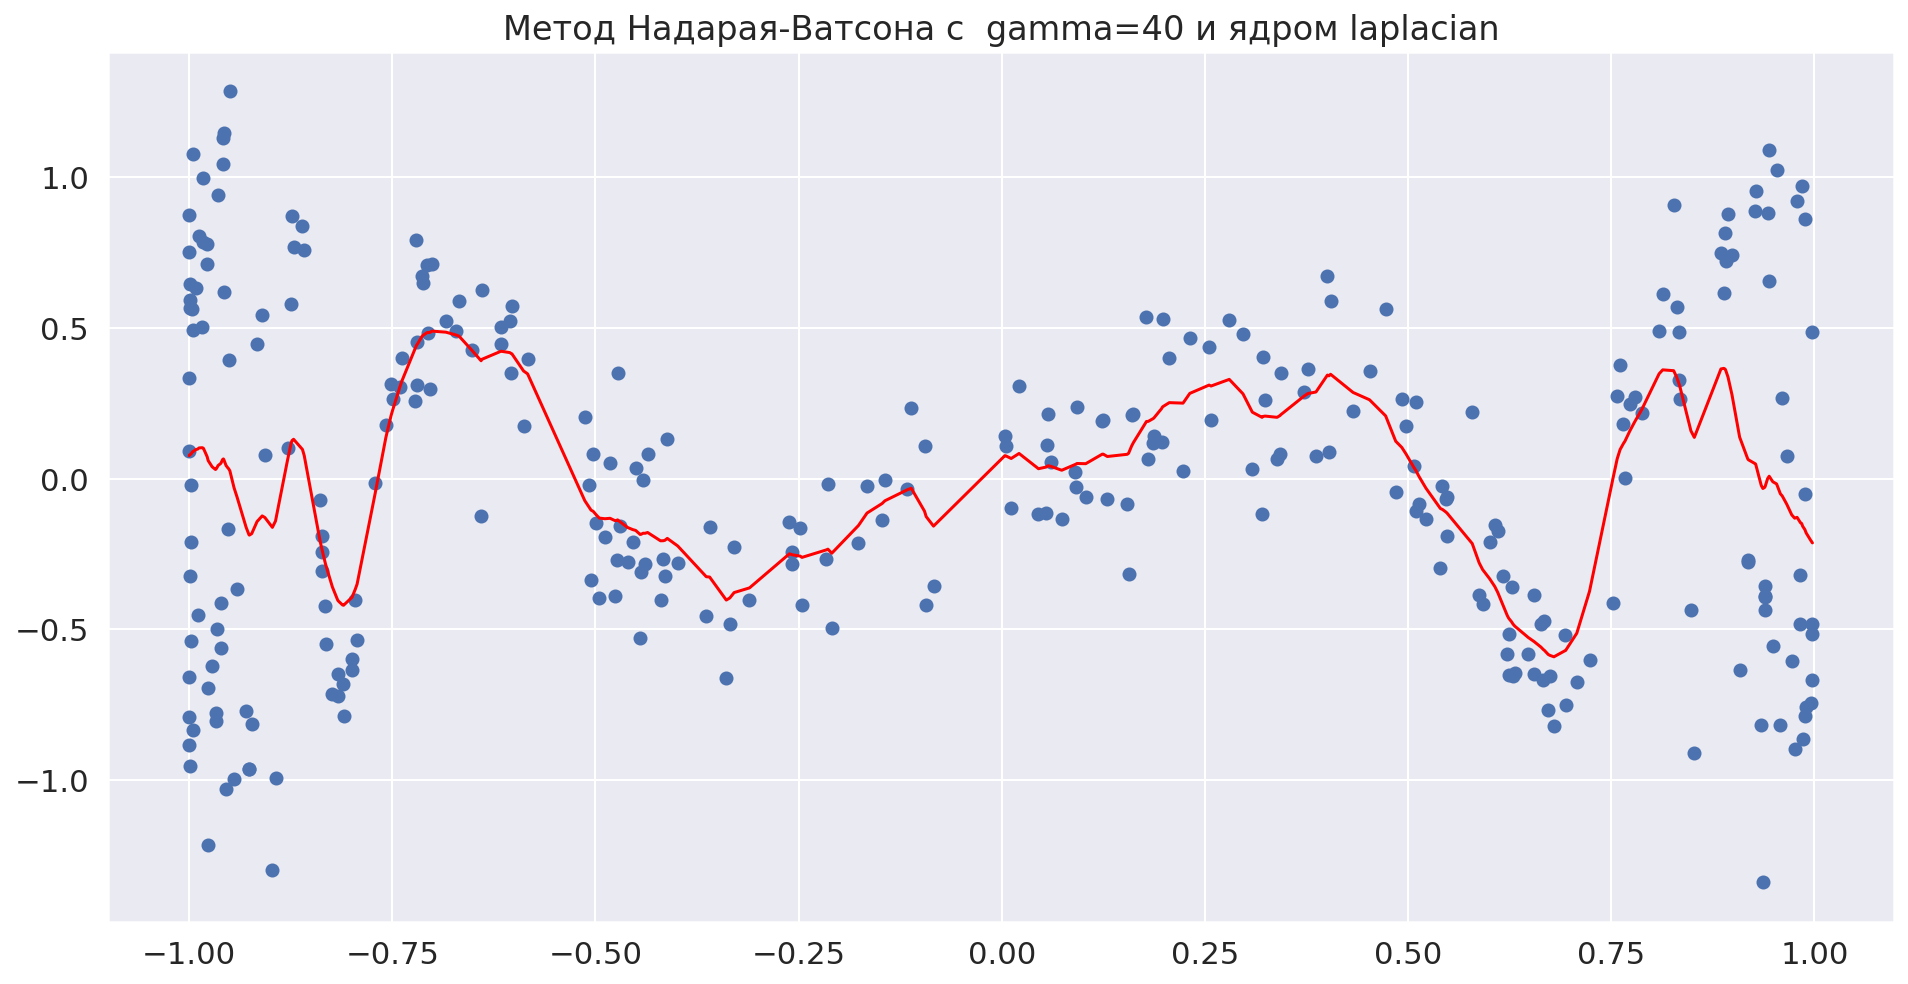

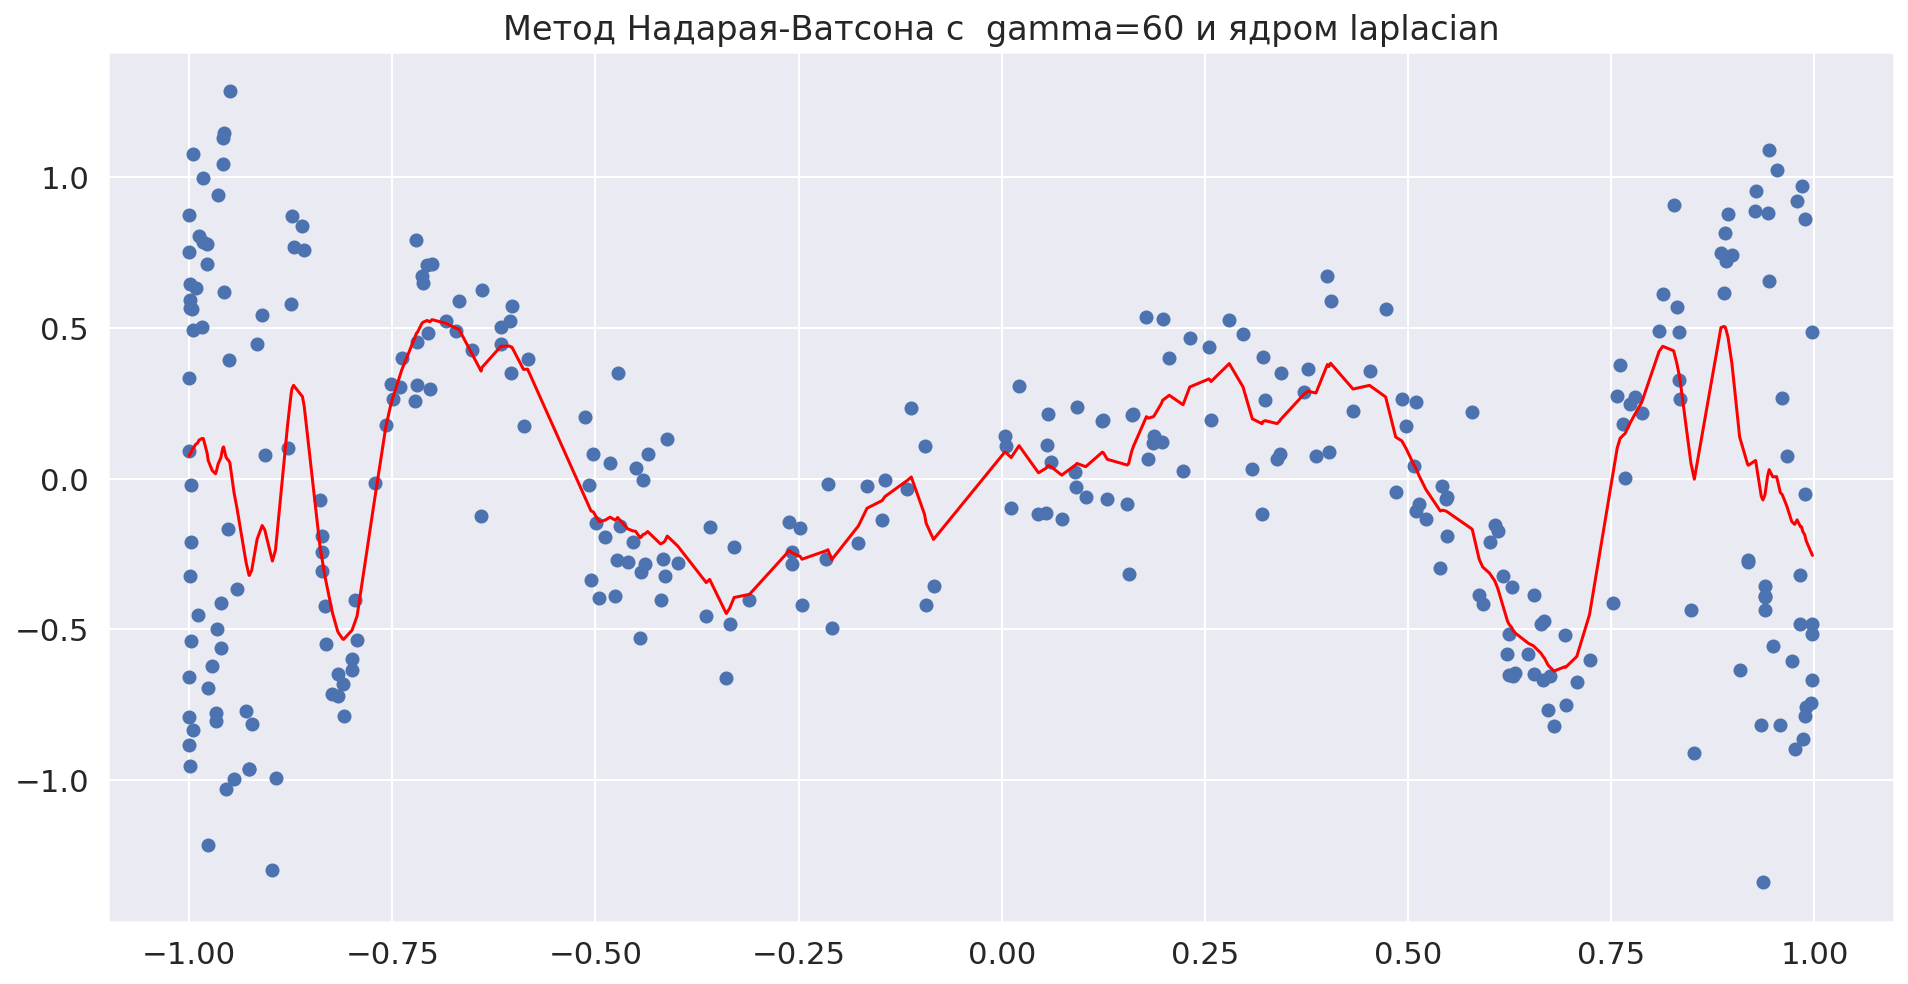

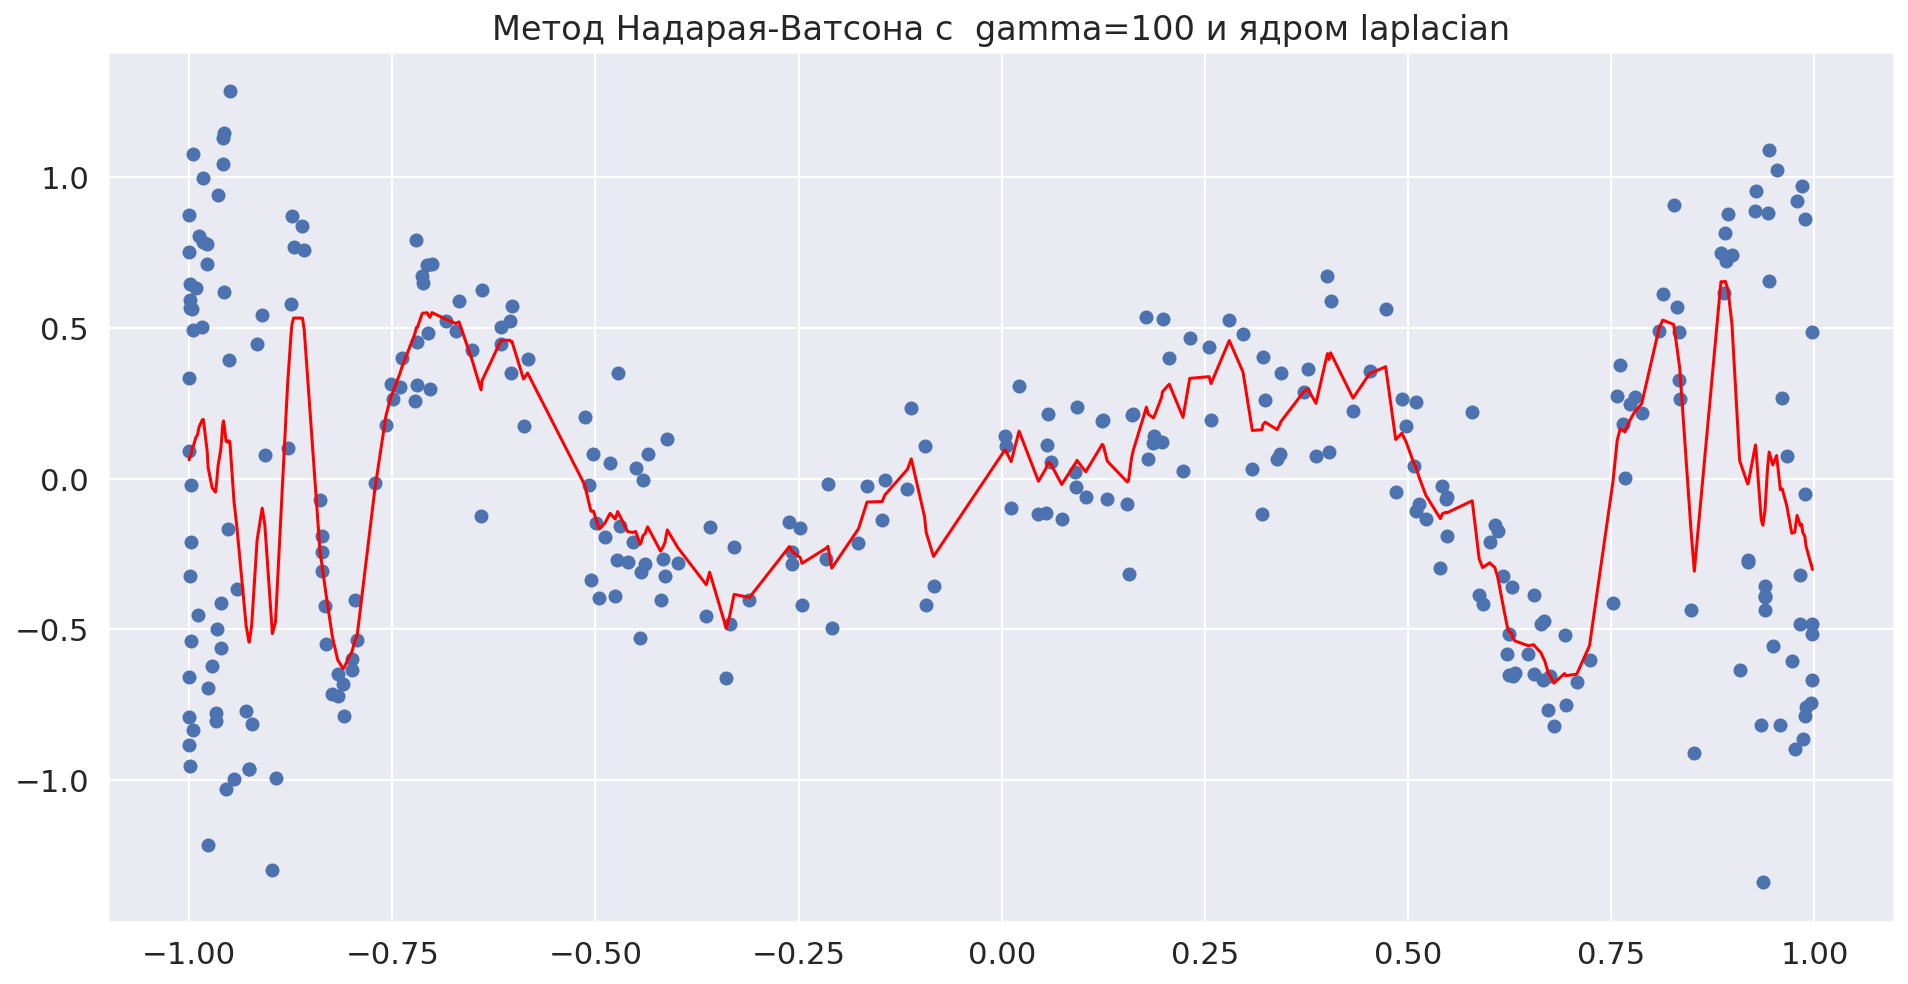

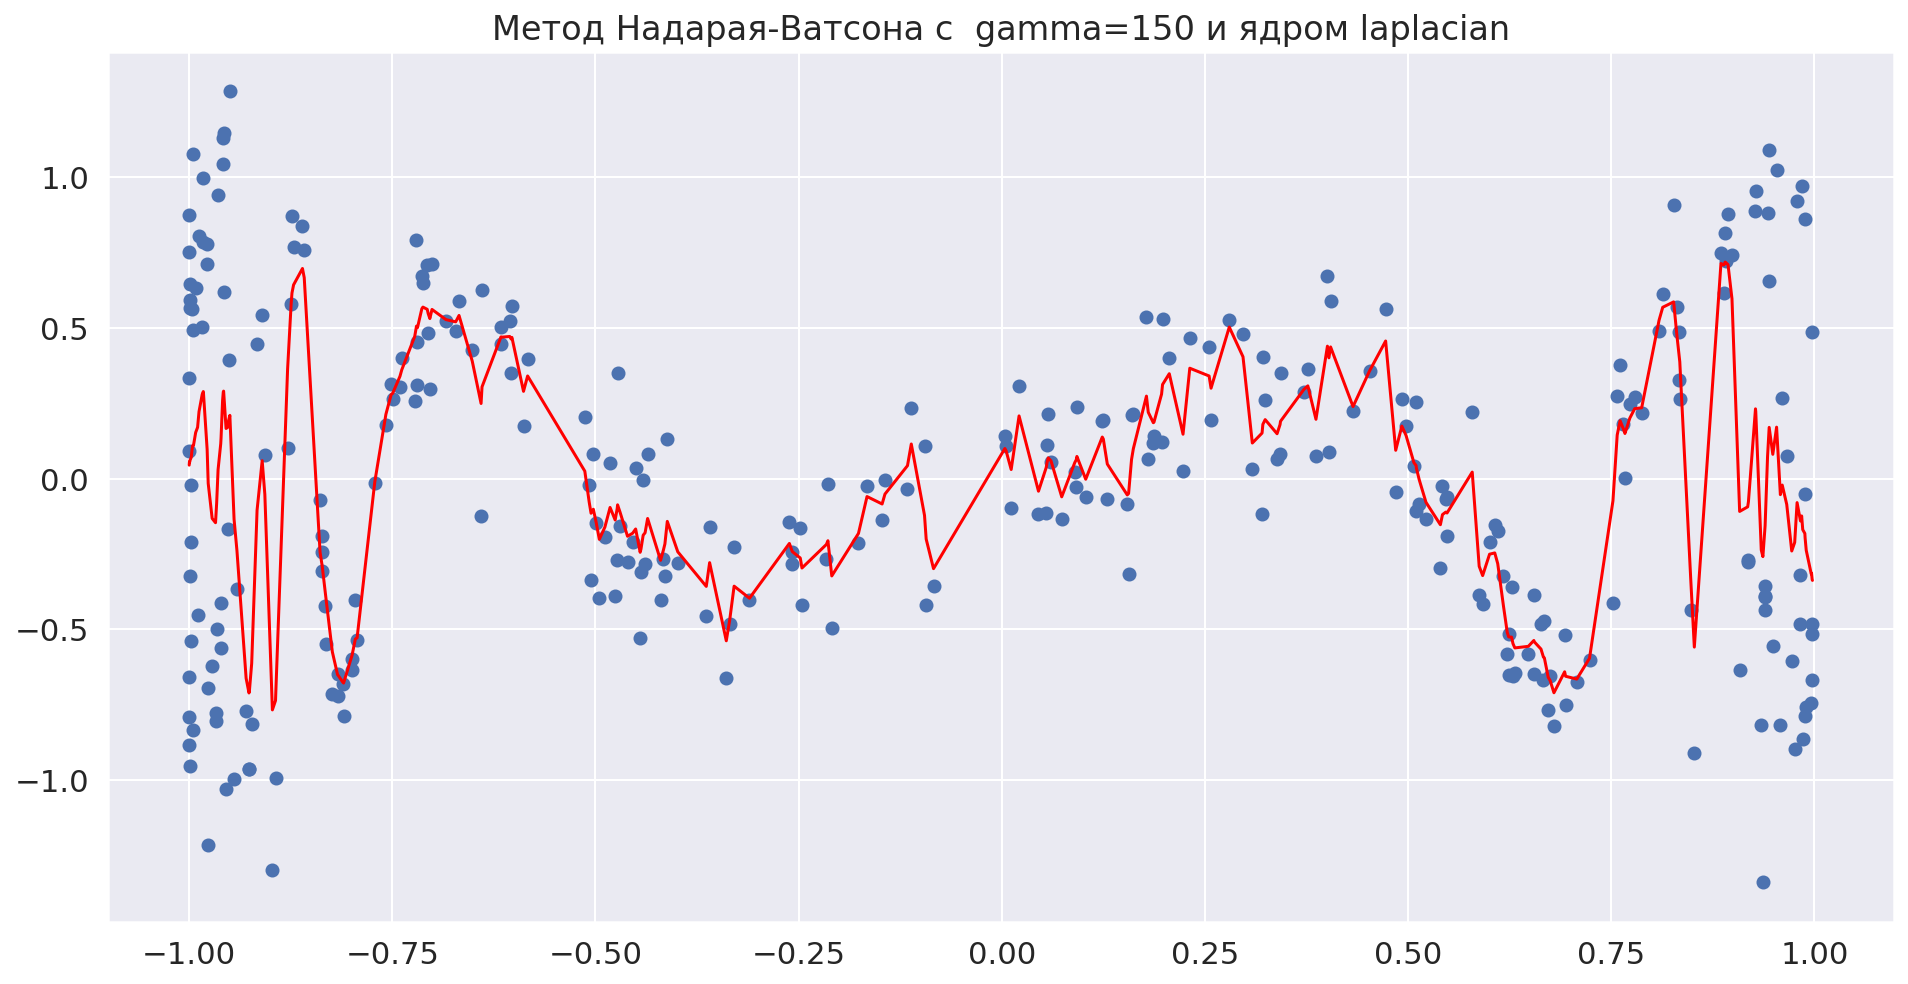

In [18]:
for ker in kernels:
    for g in gammas:
        plt.figure(figsize=(16, 8))
        KR = KernelRegression(kernel = ker ,gamma = g)
        KR.fit(x.reshape(-1, 1), y)
        plt.scatter(x, y)
        xa = np.sort(x)
        y_pred = KR.predict(xa.reshape(-1, 1))
        plt.plot(xa, y_pred, color ='red')
        plt.title(f"Метод Надарая-Ватсона с  gamma={g} и ядром {ker}")

Возьмем ядро 'rbf' и $\gamma = 150$. Посмотрим, что нам даст smooth.spline. Будем использовать csaps -- https://csaps.readthedocs.io/en/latest/formulation.html. Единственное, что стоит заметить, это то что тут вместо $\lambda$ стоит $\frac{1 - p}{p}$. Поэтому, чем меньше $p$, тем больше $\lambda$.

In [19]:
from csaps import csaps

In [20]:
ind = np.argsort(x)
xa = np.sort(x)
ya = y[ind]

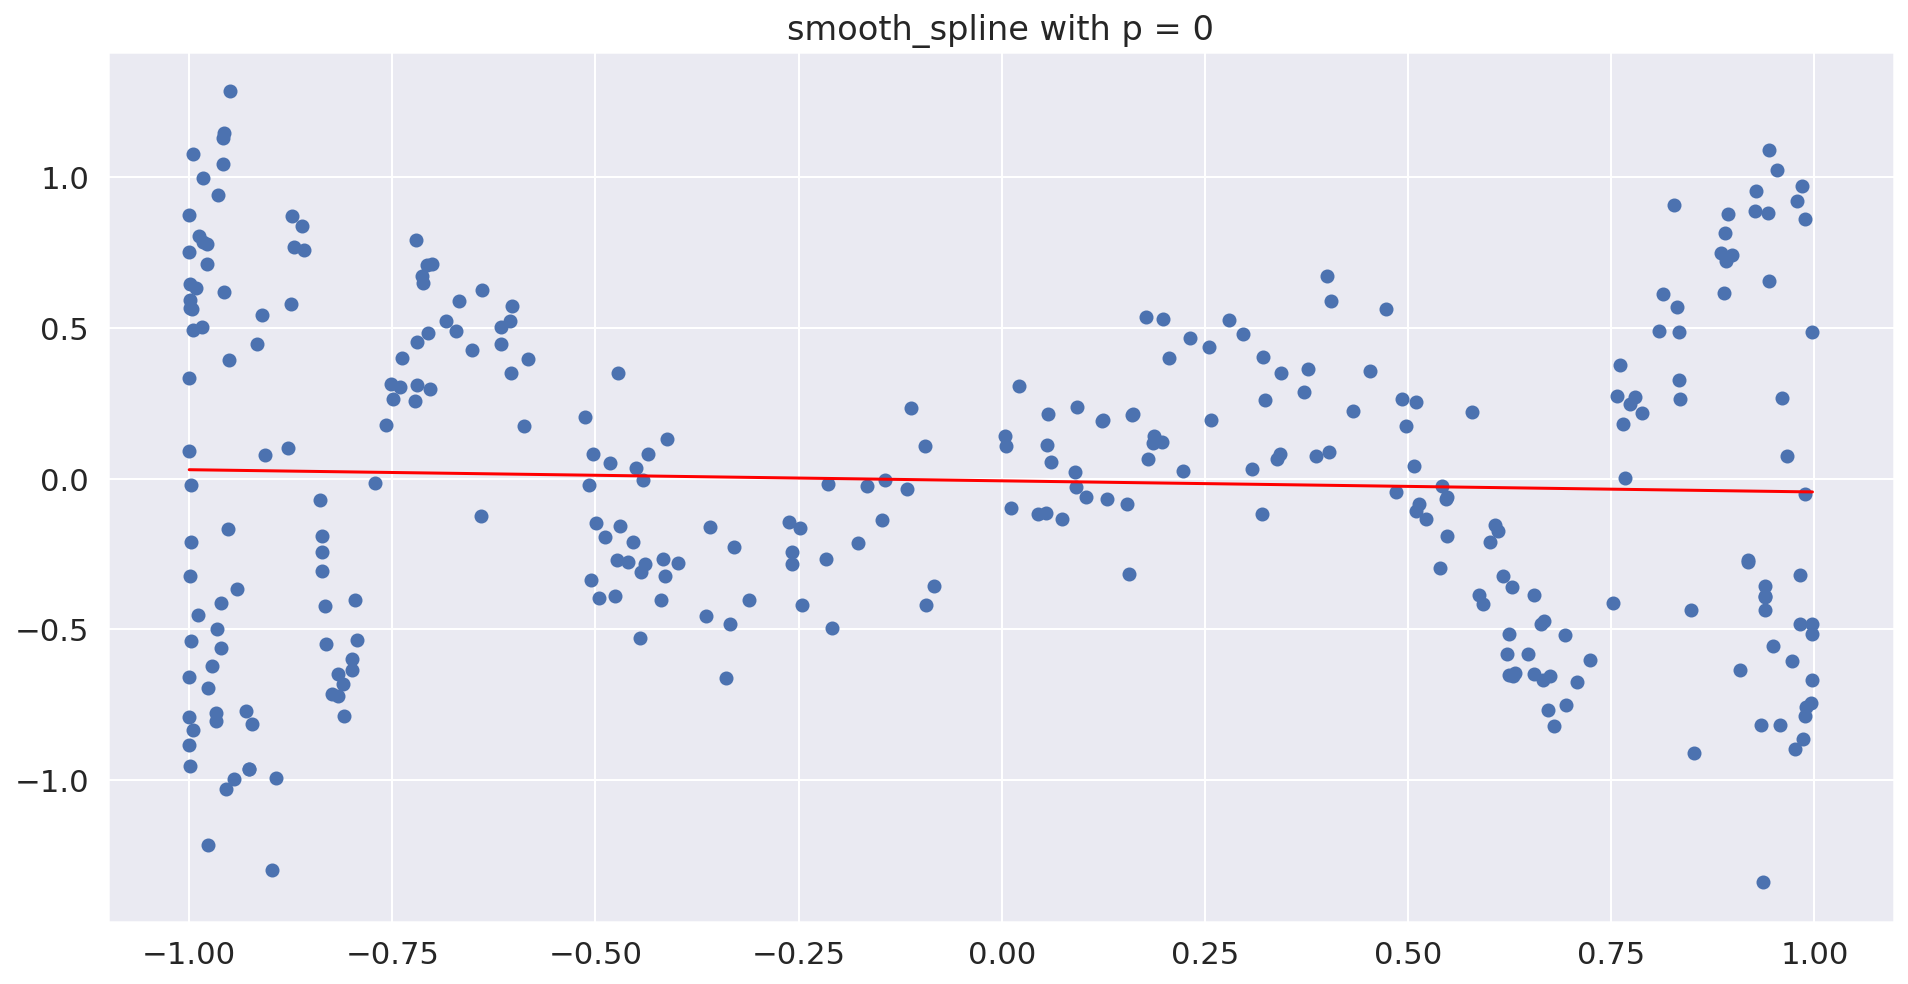

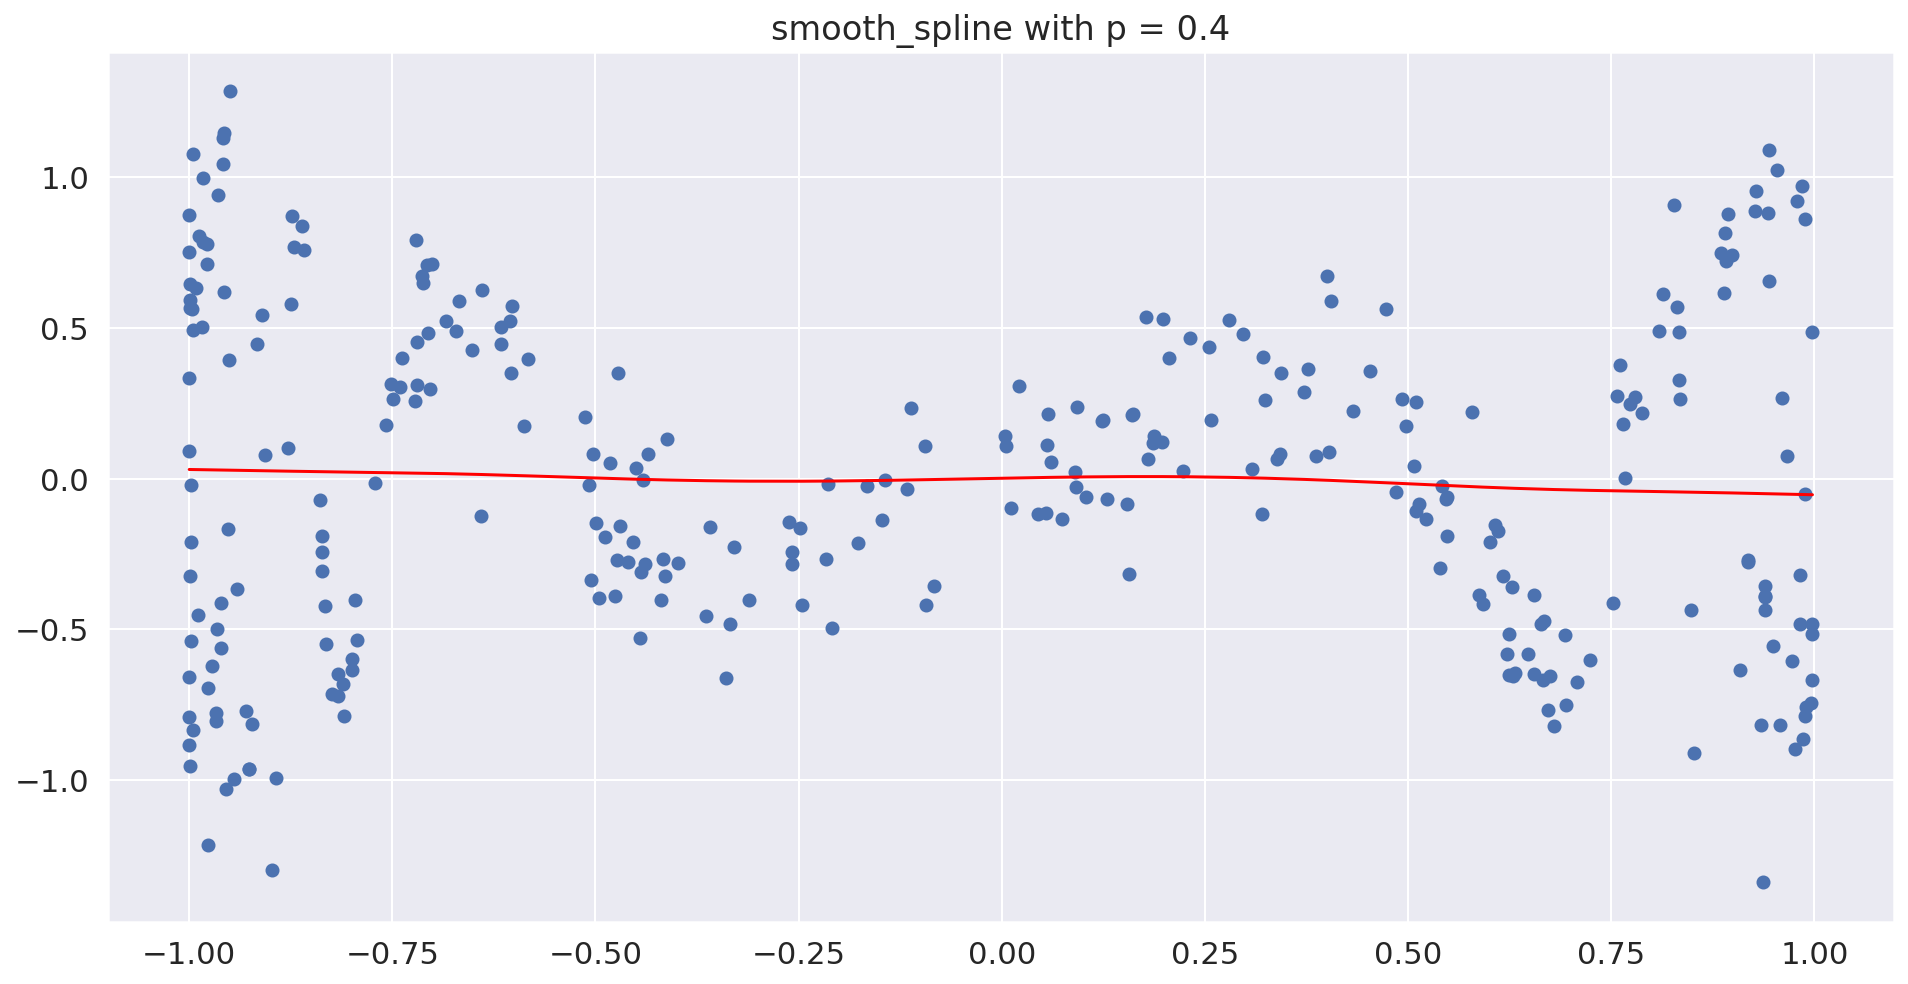

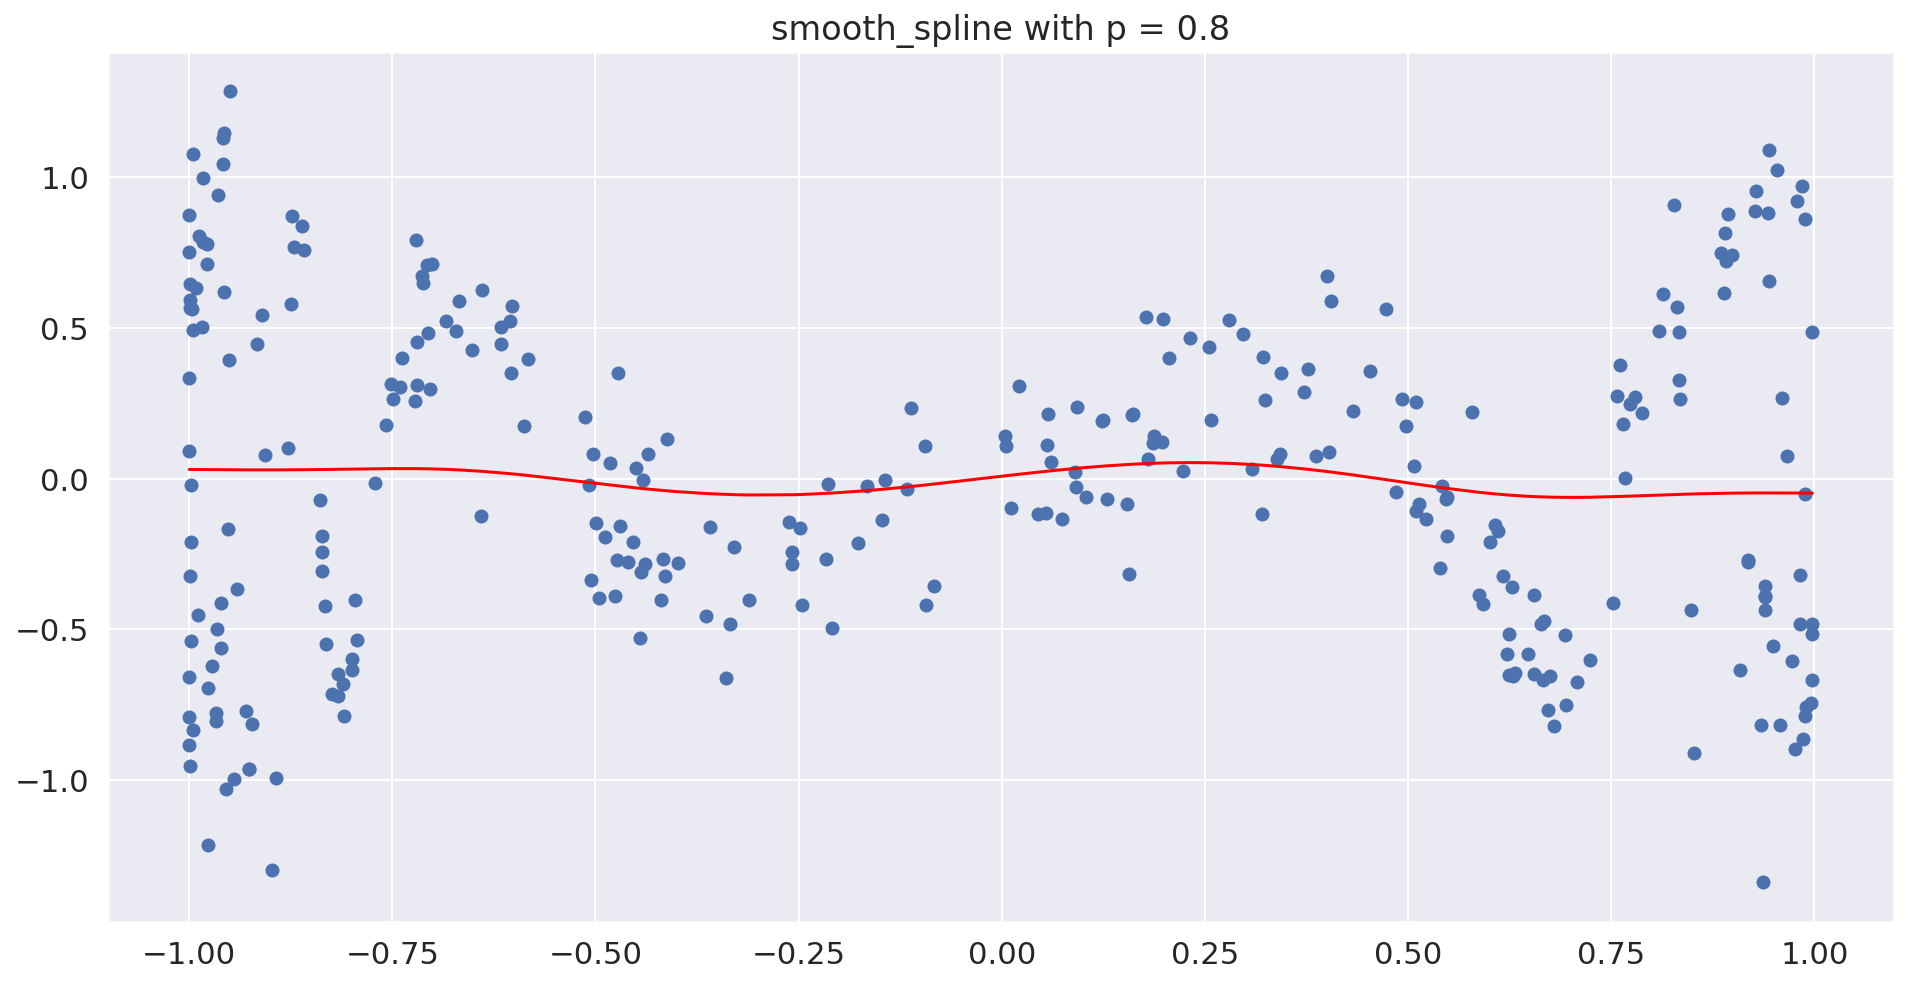

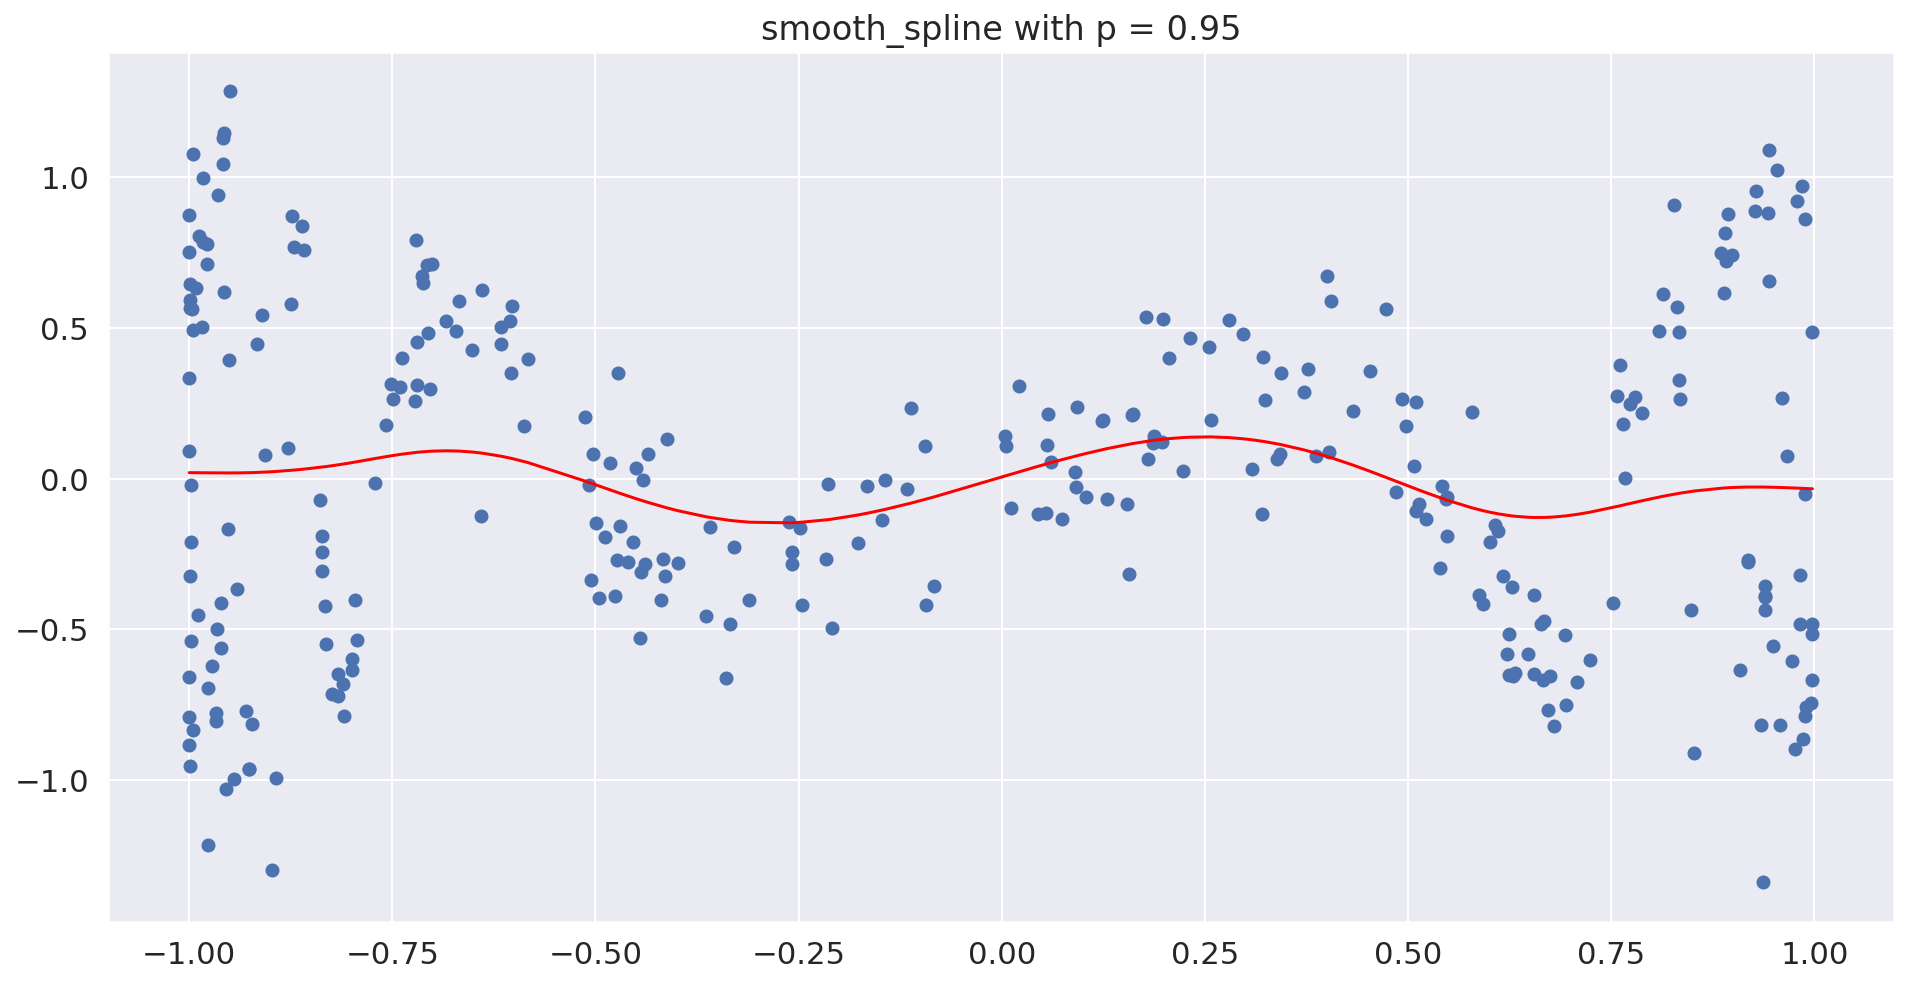

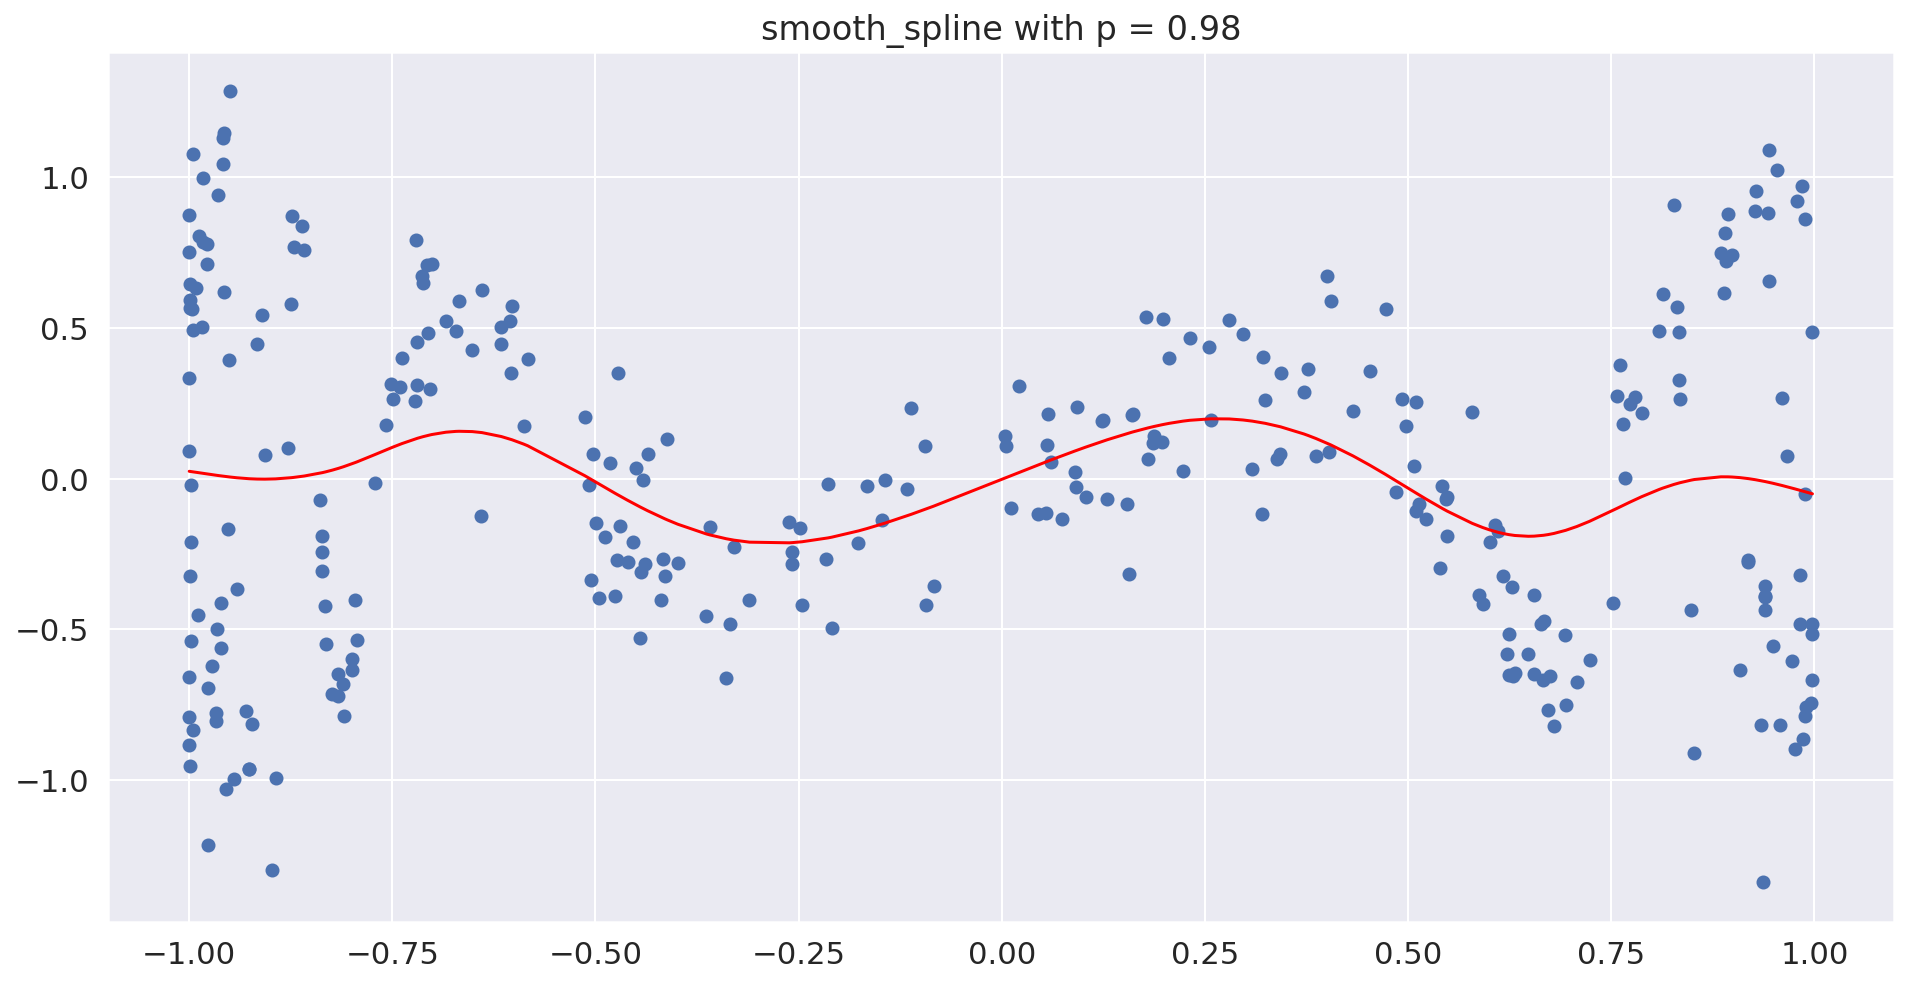

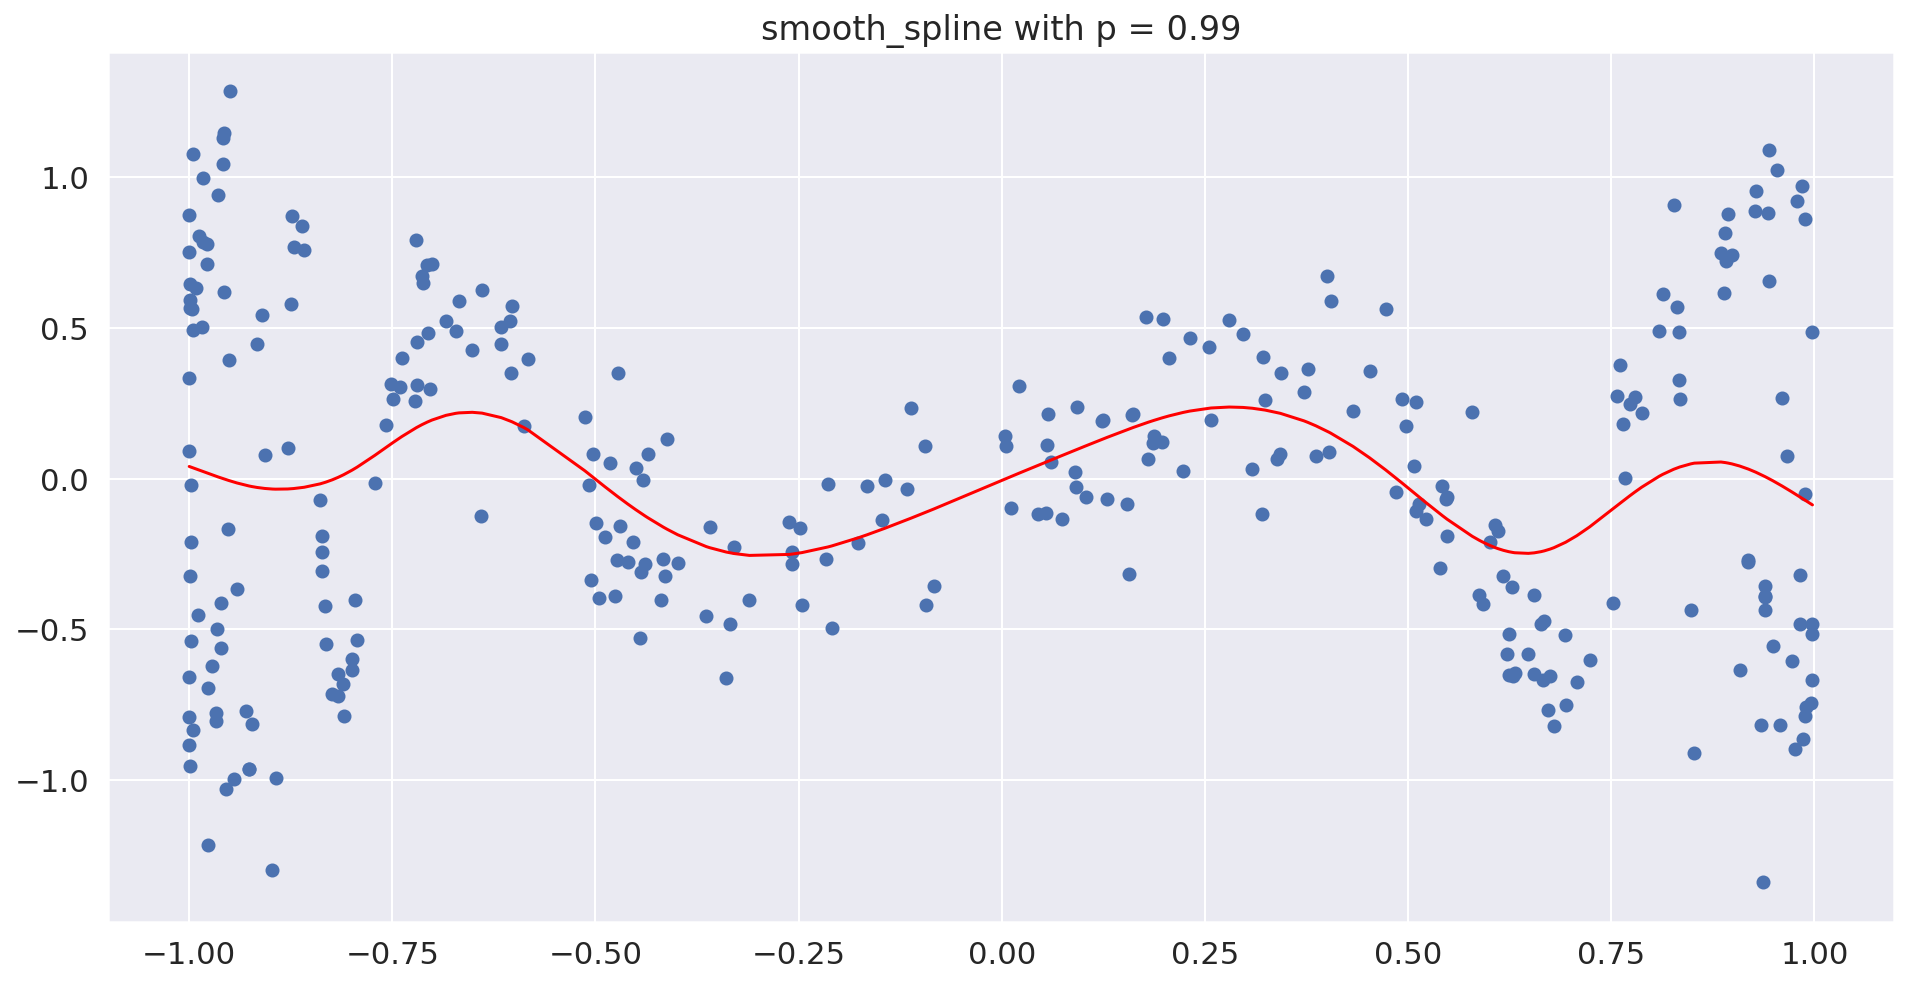

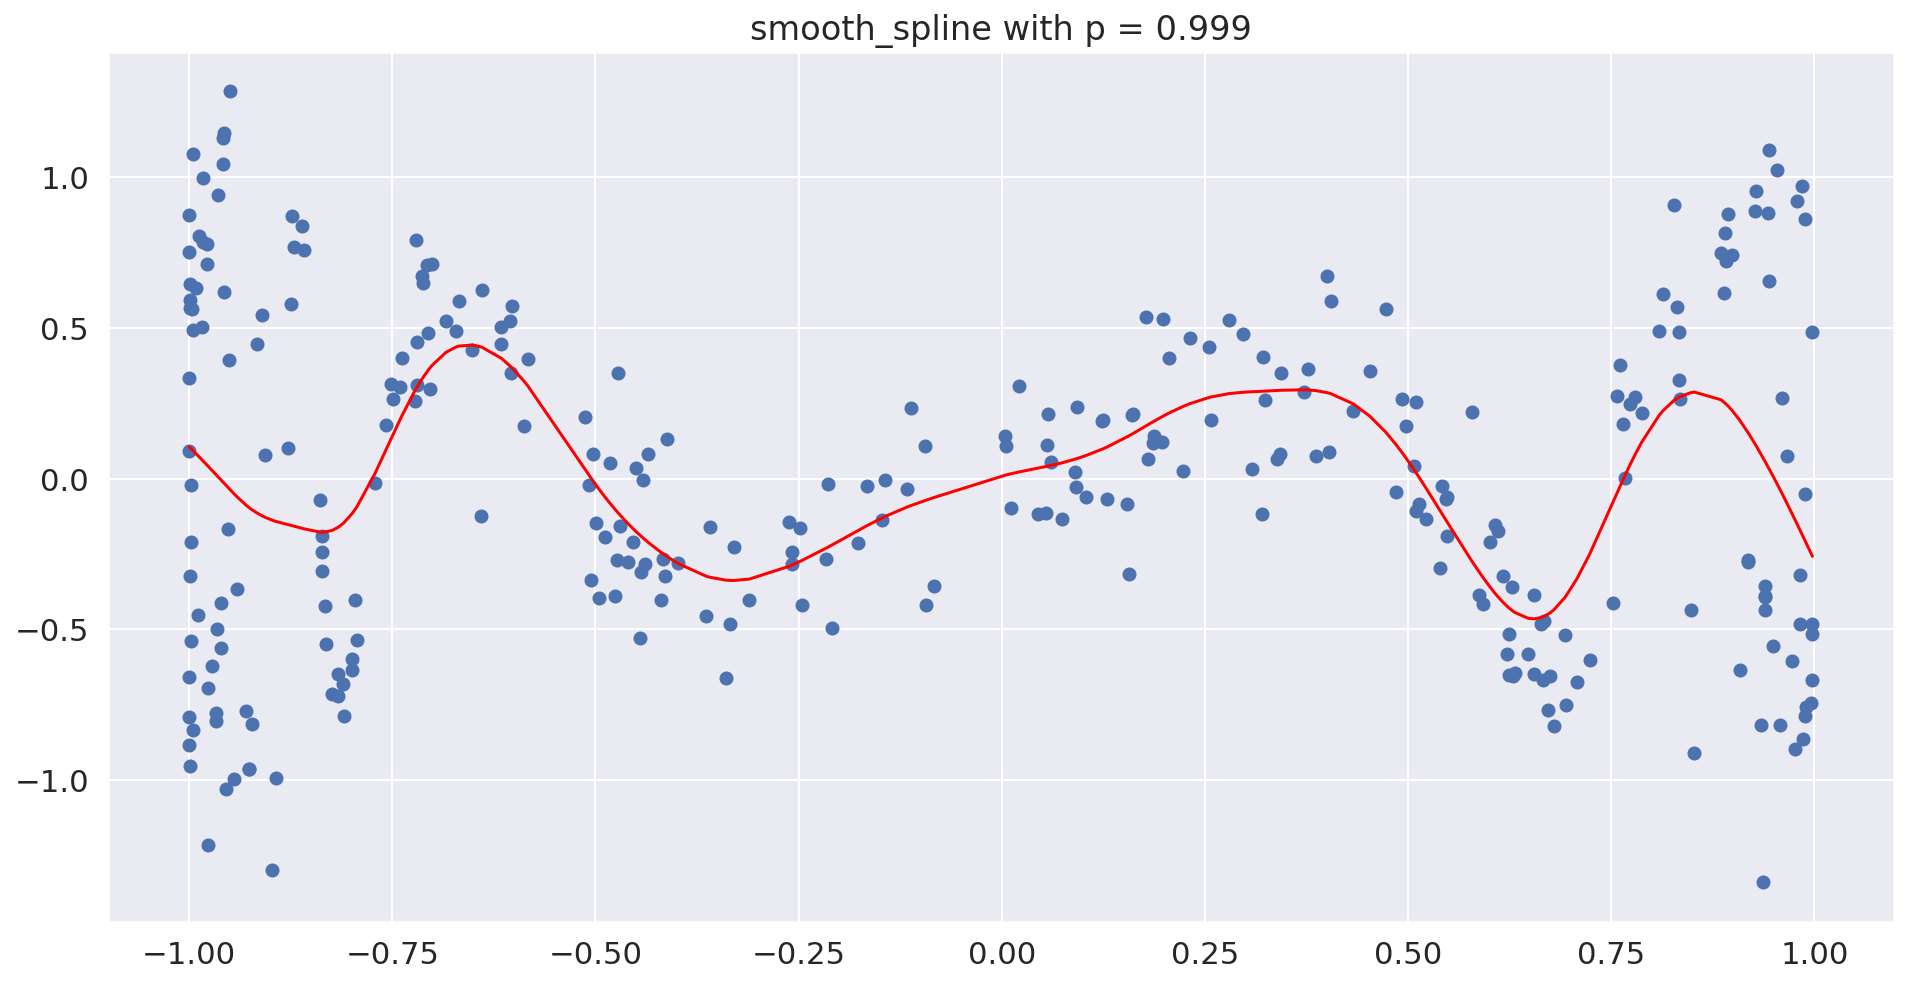

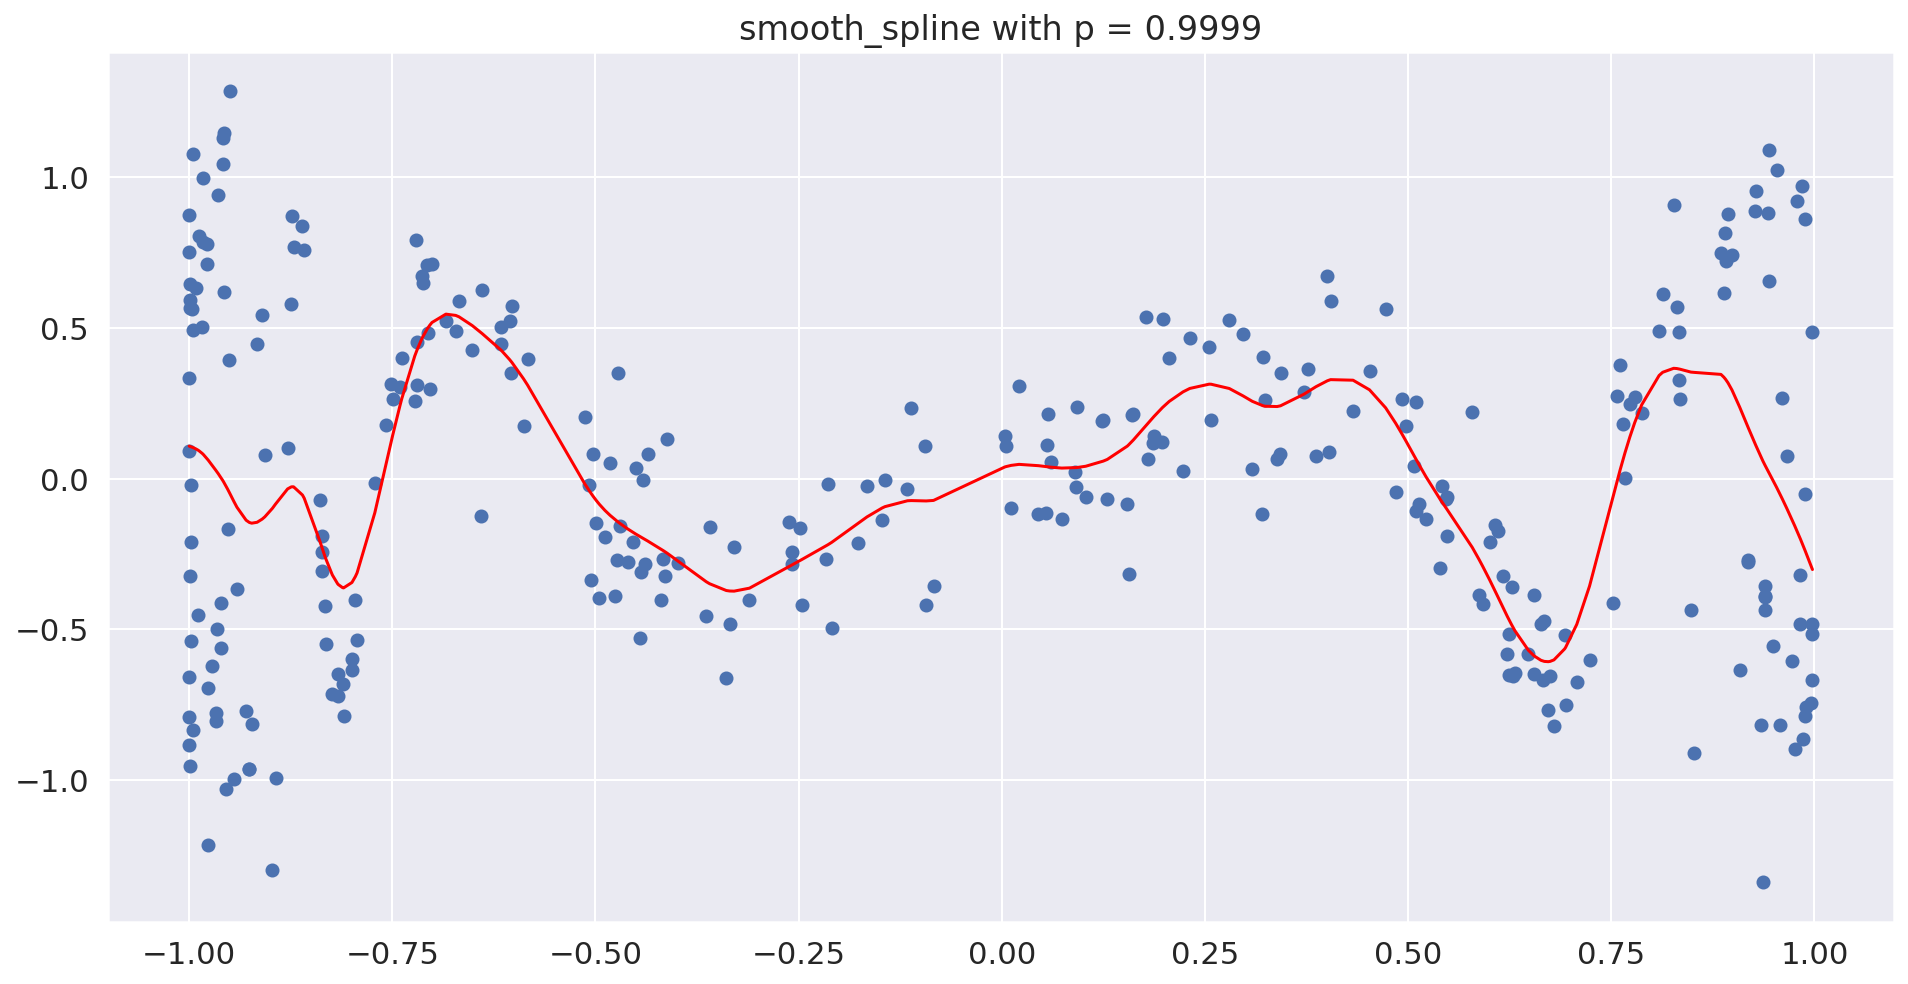

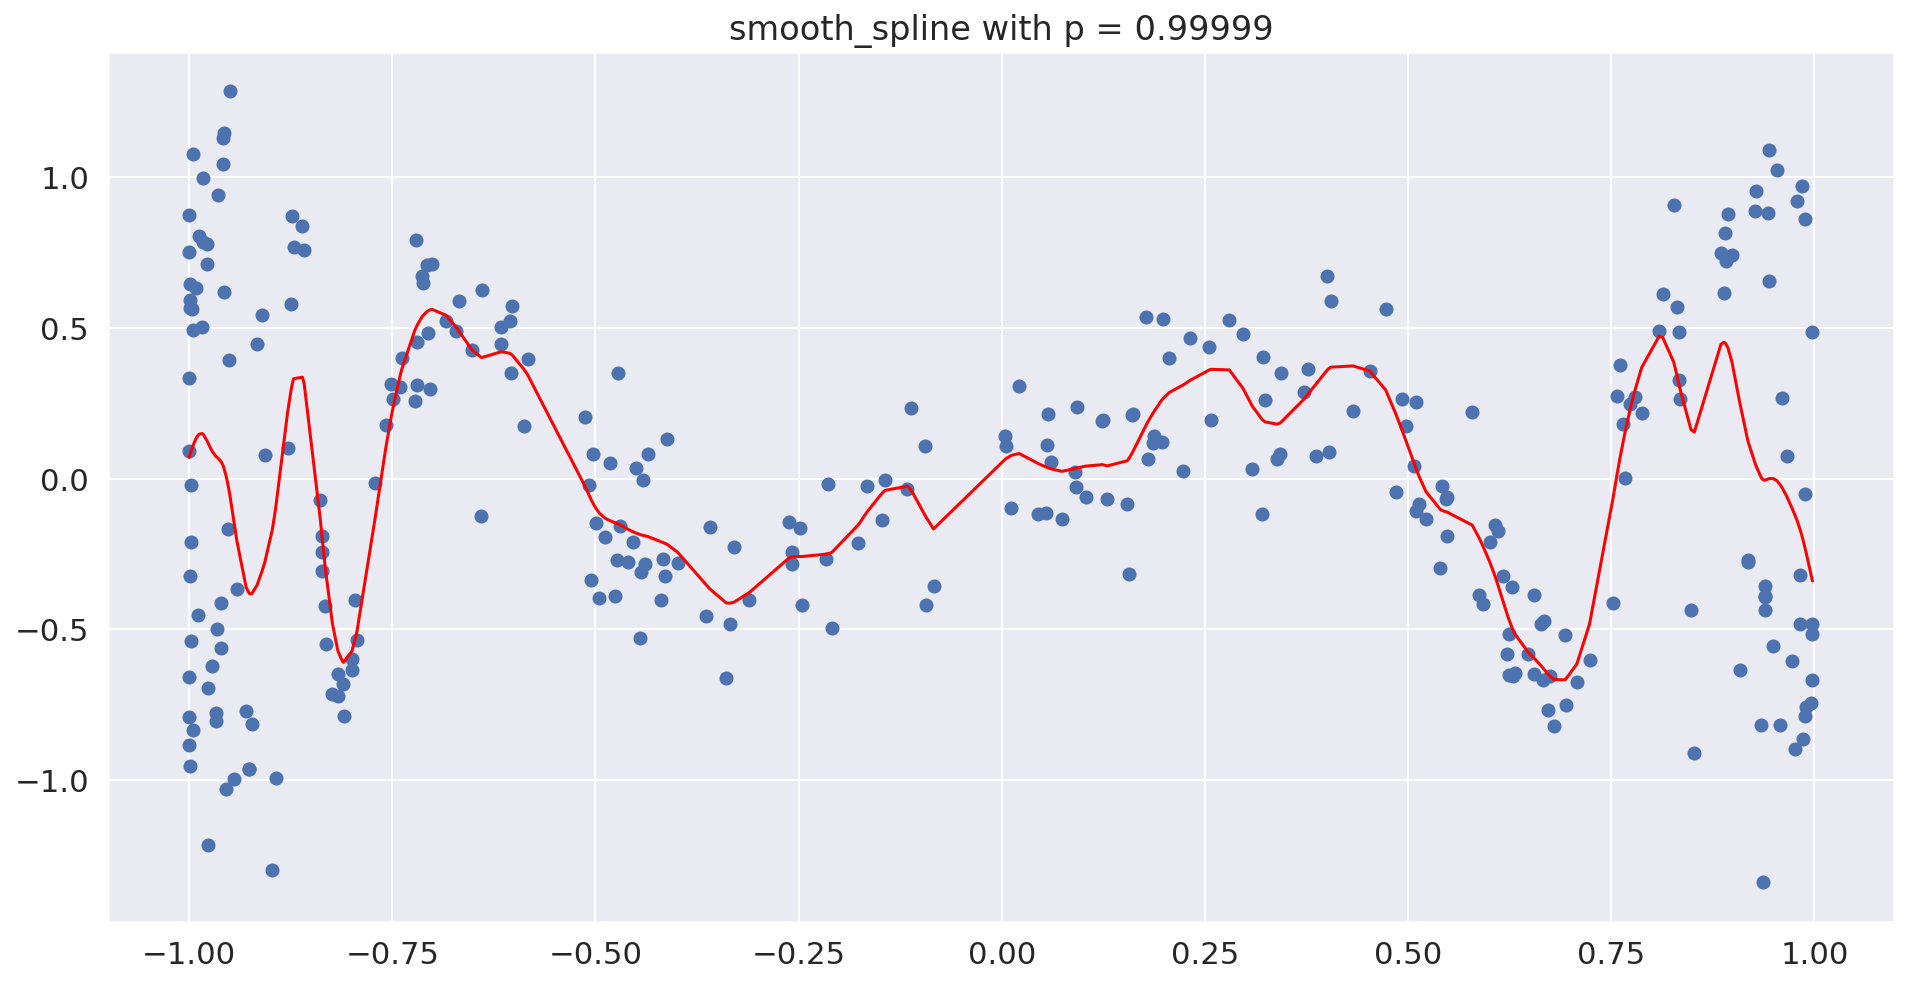

In [21]:
p_s = [0, 0.4, 0.8, 0.95, 0.98, 1 - 1e-2, 1 - 1e-3, 1 - 1e-4, 1 - 1e-5]
for p in p_s:
    plt.figure(figsize=(16, 8))
    xa = np.sort(x)
    plt.scatter(x, y)
    y_pred = csaps(xa, ya, xa, smooth = p)
    plt.plot(xa, y_pred, color ='red')
    plt.title(f'smooth_spline with p = {p}')

Кажется, что $p = 1e-3$ неплохо сглаживает. Сравним графики.

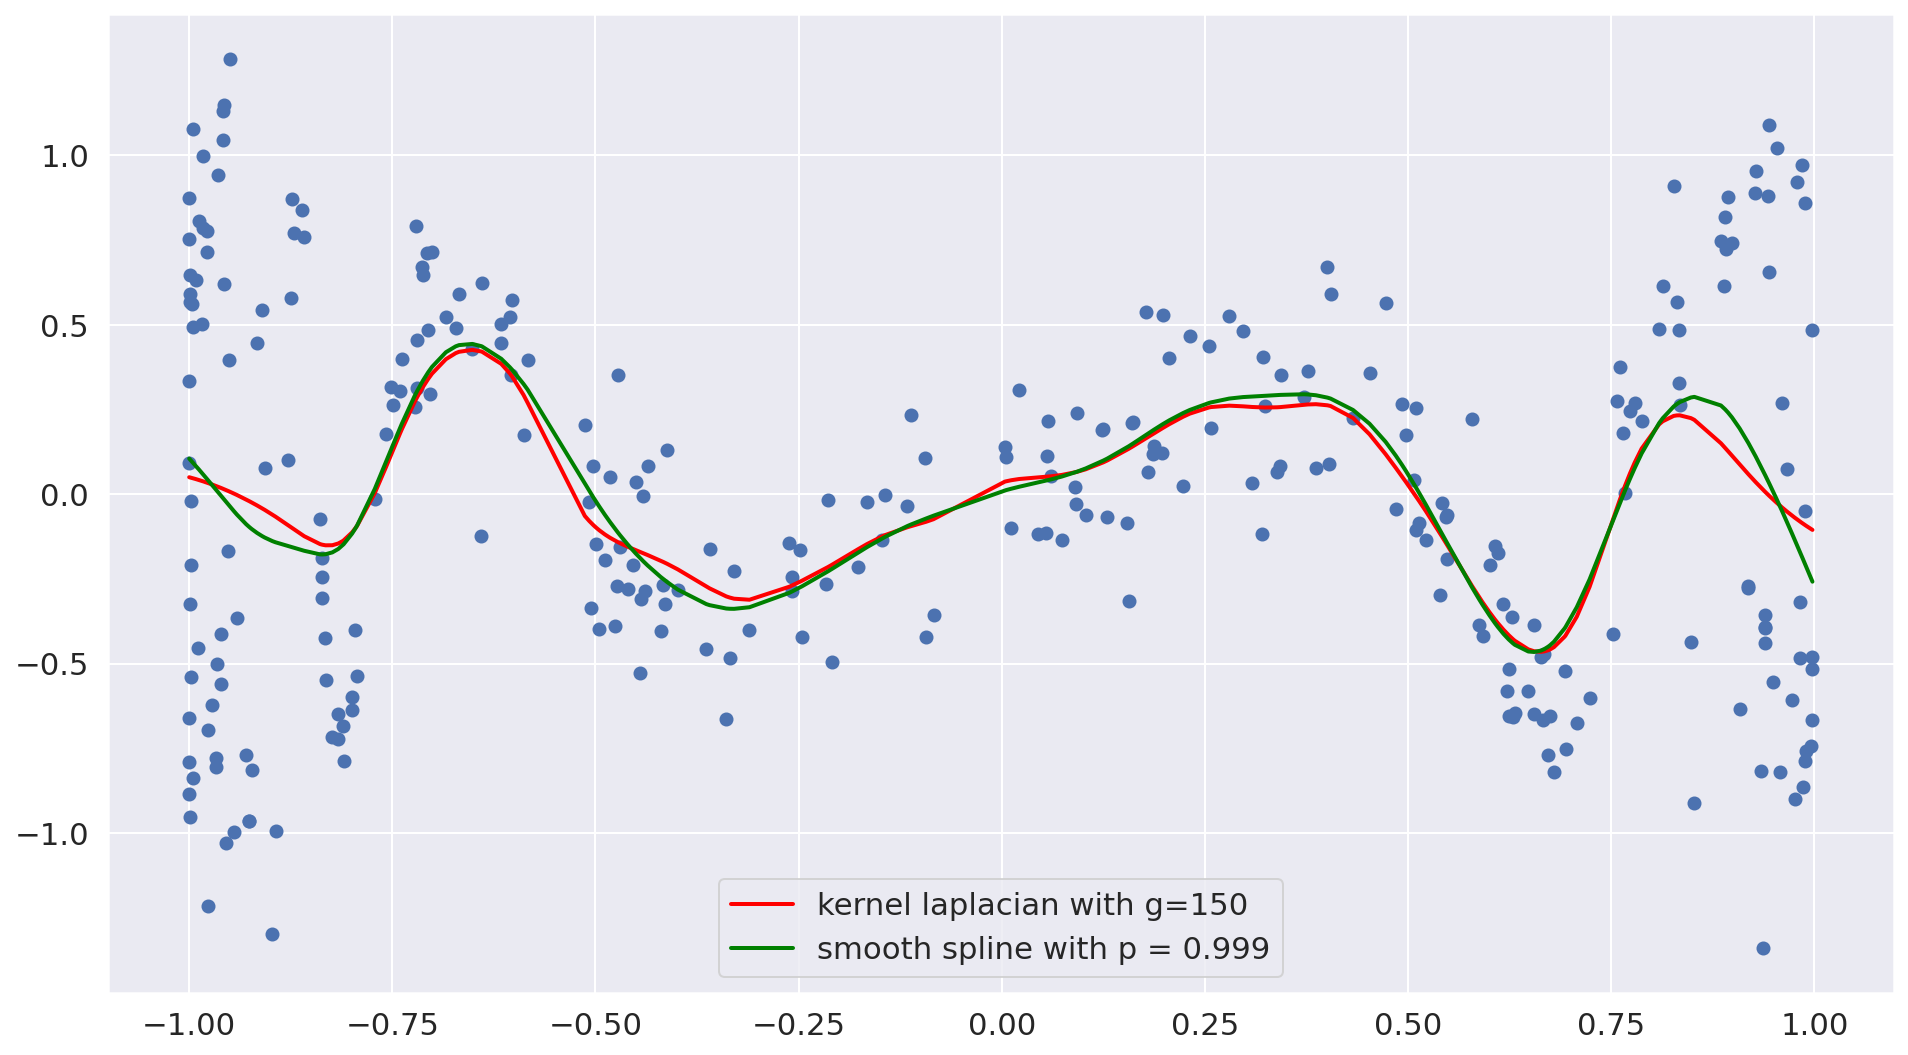

In [22]:
ker = 'rbf'
g = 150
p = 0.999
KR = KernelRegression(kernel = ker,gamma = g)
KR.fit(x.reshape(-1, 1), y)
y_pred_k = KR.predict(xa.reshape(-1, 1))
y_pred_s = csaps(xa, ya, xa, smooth = p)
plt.figure(figsize = (16, 9))
plt.scatter(x, y)
plt.plot(xa, y_pred_k, linewidth = 2, color = 'red', label = 'kernel laplacian with g=150')
plt.plot(xa, y_pred_s, linewidth = 2, color = 'green', label = 'smooth spline with p = 0.999')
plt.legend()
plt.show()

Как видим, основной разброс происходит в тех участках, где данные наиболее шумные. Это можно как раз объяснить там, что в данных местах достаточно сложно описать данных "гладко". Поэтому в данных местах smooth_spline наиболее и изменяет функцию.

### Задача 4

Считаем данные, построим линейную и модель с помощью оценок Надарая-Ватсона:

In [23]:
data = pd.read_csv("hw10t4.csv")

In [24]:
data

Unnamed: 0     Andrew    Bernard     Carle    Davide    Eugene      Fred  \
0             0 -36.944209   7.115482  3.076607  1.832458  2.059673  0.112941   
1             1 -76.268155   9.871361  1.854843  1.628231  2.818672  0.061049   
2             2 -45.020962   7.772921  1.019105  1.595419 -0.906164  0.236599   
3             3 -31.935210   6.670168  2.117598 -1.274111  1.835605  0.270813   
4             4 -40.738145   7.432577  0.048449 -0.865901  2.321549  0.086520   
..          ...        ...        ...       ...       ...       ...       ...   
495         495 -66.502159   9.272704  1.899116 -0.900721  2.407071  0.083187   
496         496 -69.003786   9.430101  0.887295  3.380195  1.289365  0.192200   
497         497 -87.396976  10.507710 -0.190295  3.735131  0.084774  0.677767   
498         498 -66.878853   9.296595 -0.102687  2.893838 -0.169116  0.226792   
499         499 -65.465762   9.206613 -0.095881 -3.258810  1.522010  0.097173   

       George  Marmaduke  
0   -0.706182   5.409550  
1   -0.595321   4.869631  
2   -1.759698   3.493061  
3    1.996759   4.904334  
4    1.720531   3.247345  
..        ...        ...  
495 -1.074938   4.417043  
496  1.133619   4.570929  
497 -1.523751   3.643916  
498 -0.563566   3.353394  
499 -0.258810   3.673269  

[500 rows x 9 columns]

Не забываем, что желательно нормализовать данные.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def make_basic_pipeline(model):
    return Pipeline([
        ("Scaler", StandardScaler()),
        ("Model", model),
    ])

In [26]:
y = data['Marmaduke']
X = data.drop(['Marmaduke', 'Unnamed: 0'], axis = 1)

Ядро зафиксируем стандартное, а для $\gamma$ сделаем небольшую сеточку:

In [27]:
ker = 'rbf'
best_gamma = -5
best_score = -10000
grid = np.linspace(1e-5, 3, 200)
for g in grid:
    model = make_basic_pipeline(KernelRegression(kernel = ker, gamma = g))
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5).mean()
    if cv_score > best_score:
        best_gamma = g
        best_score = cv_score
print("Best gamma -- ", best_gamma)
print("Cv_score -- ", best_score)

Best gamma --  2.442212914572864
Cv_score --  -1.122339691914976


Посмотрим, что нам даст обычная линейная регрессия.

In [28]:
model =  make_basic_pipeline(LinearRegression(fit_intercept=True))
model.fit(X, y)
cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5).mean()
cv_score

-1.783770697670586

Как видим, нелинейная модель выучилась лучше. А теперь реализуем алгоритм настройки с возвращением. Для приближения $\phi_j$ будем использовать оценку Надарая-Ватсона. Также, добавим опциональный параметр числа итераций.

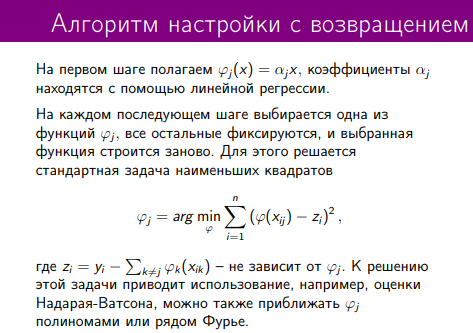

In [29]:
class Returning(BaseEstimator, RegressorMixin):
    def __init__(self, g = 1, ker = 'rbf', num_iter= 1):
        self.num_iter = num_iter
        self.g = g
        self.ker = ker
    
    def fit(self, X, y):
        self.model = LinearRegression(fit_intercept=True)
        self.model.fit(X, y)
        self.coefs = np.array(self.model.coef_.tolist() + [self.model.intercept_])
        self.X = X
        self.X = np.concatenate((self.X, np.ones((self.X.shape[0], 1))), axis = 1)
        self.cur_phi = self.X  * self.coefs
        self.pipe = []
        indexes = np.tile(np.arange(self.X.shape[1]), self.num_iter)
        for j in indexes:
            z = y - np.sum(self.cur_phi, axis = 1)  + self.cur_phi[:, j]
            kern = KernelRegression(gamma=g,kernel = ker)
            kern.fit(self.X[:, j].reshape(-1, 1), z)
            self.cur_phi[:, j] = kern.predict(self.X[:, j].reshape(-1, 1))
            self.pipe.append((j, kern)) 
    
    
    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
        cur_phi = X * self.coefs
        for ind, model in self.pipe:
            cur_phi[:, ind] = model.predict(X[:, ind].reshape(-1, 1))
        return cur_phi.sum(axis = 1)

In [30]:
model = Returning()
model.fit(StandardScaler().fit_transform(X), y)

In [31]:
y_pred = model.predict(StandardScaler().fit_transform(X))
cv_score = cross_val_score(model, StandardScaler().fit_transform(X),
                           y, scoring='neg_mean_squared_error', cv=5).mean()
cv_score

-0.7177174970370955

Улучшение почти в 2 раза! А теперь заведем небольшую сеточку на число итераций и $\gamma$:

In [32]:
best_gamma = -5
best_it = -1
best_score = -10000
grid_it = np.arange(1, 5)
grid_g = np.linspace(1e-1, 10, 50)
for iters in grid_it:
    for g in grid_g:
        model = Returning(g = g, num_iter=iters)
        cv_score = cross_val_score(model, StandardScaler().fit_transform(X), 
                                   y, scoring='neg_mean_squared_error', cv=5).mean()
        if cv_score > best_score:
            best_gamma = g
            best_score = cv_score
            best_it = iters
print(f"Best gamma -- {best_gamma}, best number of iters -- {best_it} ")
print("Cv_score -- ", best_score)

Best gamma -- 10.0, best number of iters -- 4 
Cv_score --  -0.3664719109600069


Еще получили буст в 2 раза. Кажется, что можно увеличить сетку, но на самом деле уже большого прироста не будет, но будет вероятность переобучиться.

### Задача 5

In [33]:
data = pd.read_csv("hw10t5_train.csv")

In [34]:
data

Unnamed: 0  0   1  2      3      4      5      6      7      8      9  \
0             0  0   0  0 -3.639  0.418 -0.670  1.779 -0.168  1.627 -0.388   
1             1  0   0  0 -3.327  0.496 -0.694  1.365 -0.265  1.933 -0.363   
2             2  0   0  0 -2.120  0.894 -1.576  0.147 -0.707  1.559 -0.579   
3             3  0   0  0 -2.287  1.809 -1.498  1.012 -1.053  1.060 -0.567   
4             4  0   0  0 -2.598  1.938 -0.846  1.062 -1.633  0.764  0.394   
..          ... ..  .. ..    ...    ...    ...    ...    ...    ...    ...   
984         984  1  14  1 -2.924  2.731 -1.138  0.066  0.100  0.683  0.162   
985         985  1  14  1 -3.239  3.083 -1.427 -0.202 -0.282  1.421  0.576   
986         986  1  14  1 -3.753  3.605 -0.899 -0.747 -0.401  1.765  0.620   
987         987  1  14  1 -3.980  2.459  0.068  0.023  0.237  1.029 -0.189   
988         988  1  14  1 -4.264  2.925  0.065  0.794  0.323  0.515 -1.282   

        10     11     12  13         y  
0    0.529 -0.874 -0.814   0  5.238254  
1    0.510 -0.621 -0.488   1  7.474420  
2    0.676 -0.809 -0.049   2  7.011719  
3    0.235 -0.091 -0.795   3  2.288058  
4   -0.150  0.277 -0.396   4  3.391995  
..     ...    ...    ...  ..       ...  
984 -0.399 -0.882  0.827   5       NaN  
985  0.068 -0.914  0.147   6       NaN  
986  0.754 -0.835 -0.301   7       NaN  
987  0.521 -0.773 -0.500   8       NaN  
988 -0.140 -0.863 -0.390   9       NaN  

[989 rows x 16 columns]

In [35]:
all_X = data.drop(['Unnamed: 0', 'y'], axis = 1)
X = data.dropna().drop(['Unnamed: 0', 'y'], axis = 1)
y = data.dropna()['y']

Сначала попробуем методы линейной регрессии, потом попробуем воспользоваться непараметрической регрессией через оценку Надарая-Ватсона, а также опробуем алгоритм настройки с возвращением из прошлой задачи.

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning

def find_best_params(model, params_grid, X_train, y_train):
    searcher = GridSearchCV(model,params_grid,scoring='neg_mean_squared_error')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        searcher.fit(X_train, y_train)

    print("Best parameters:", searcher.best_params_)
    model = searcher.best_estimator_
    #model.fit(X_train, y_train)
    return model

In [37]:
def train_and_test_cv(model, parameters, title, X, y, need_grid = False):
    best_model = model
    if need_grid:
        best_model = find_best_params(model,parameters, X, y)
    else:
        best_model.fit(X, y)
    
    cv_score = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=4).mean()
    print(f'cv score  -- ', cv_score)
    return cv_score, best_model

In [38]:
def find_student_remainders(model, X, y):
    vals = sklearn.preprocessing.normalize(X)
    H = vals.dot(np.linalg.inv(vals.T.dot(vals))).dot(vals.T)
    rss = ((y - model.predict(X))**2).sum()
    std = rss / (vals.shape[0] - vals.shape[1] - 1)
    err = (y.values - model.predict(X)) / np.sqrt(std) / np.sqrt(1 - np.diag(H))
    return err

In [39]:
model_n =  make_basic_pipeline(LinearRegression(fit_intercept=True))
cv_lin, _ = train_and_test_cv(model_n, None, "Linear", X, y, False)

cv score  --  -4.906346610115456


In [40]:
forest = ExtraTreesRegressor(n_estimators=100)
forest.fit(X, y)
forest.feature_importances_

array([0.01727967, 0.02231923, 0.01847371, 0.08952   , 0.20337855,
       0.04752415, 0.09540722, 0.0518516 , 0.17252423, 0.05142492,
       0.05861523, 0.05957481, 0.05127627, 0.06083041])

In [41]:
k = X.shape[1]
print(k)

cv_scores = []


for features_count in range(1, k + 1):
    print('------------------------------------------------------')
    print('features number -- ', features_count)
    tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100), n_features_to_select=features_count, step=1)
    X_rfe = tree.fit_transform(X, y)
    model = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
    cv, _ = train_and_test_cv(model, None, "Linear", X_rfe, y, False)
    cv_scores.append(cv)
    print('------------------------------------------------------')

14
------------------------------------------------------
features number --  1
cv score  --  -5.471985036443331
------------------------------------------------------
------------------------------------------------------
features number --  2
cv score  --  -4.314254256126057
------------------------------------------------------
------------------------------------------------------
features number --  3
cv score  --  -4.189920818877184
------------------------------------------------------
------------------------------------------------------
features number --  4
cv score  --  -4.1370167397415445
------------------------------------------------------
------------------------------------------------------
features number --  5
cv score  --  -4.231235240021105
------------------------------------------------------
------------------------------------------------------
features number --  6
cv score  --  -4.287039263065904
------------------------------------------------------
------

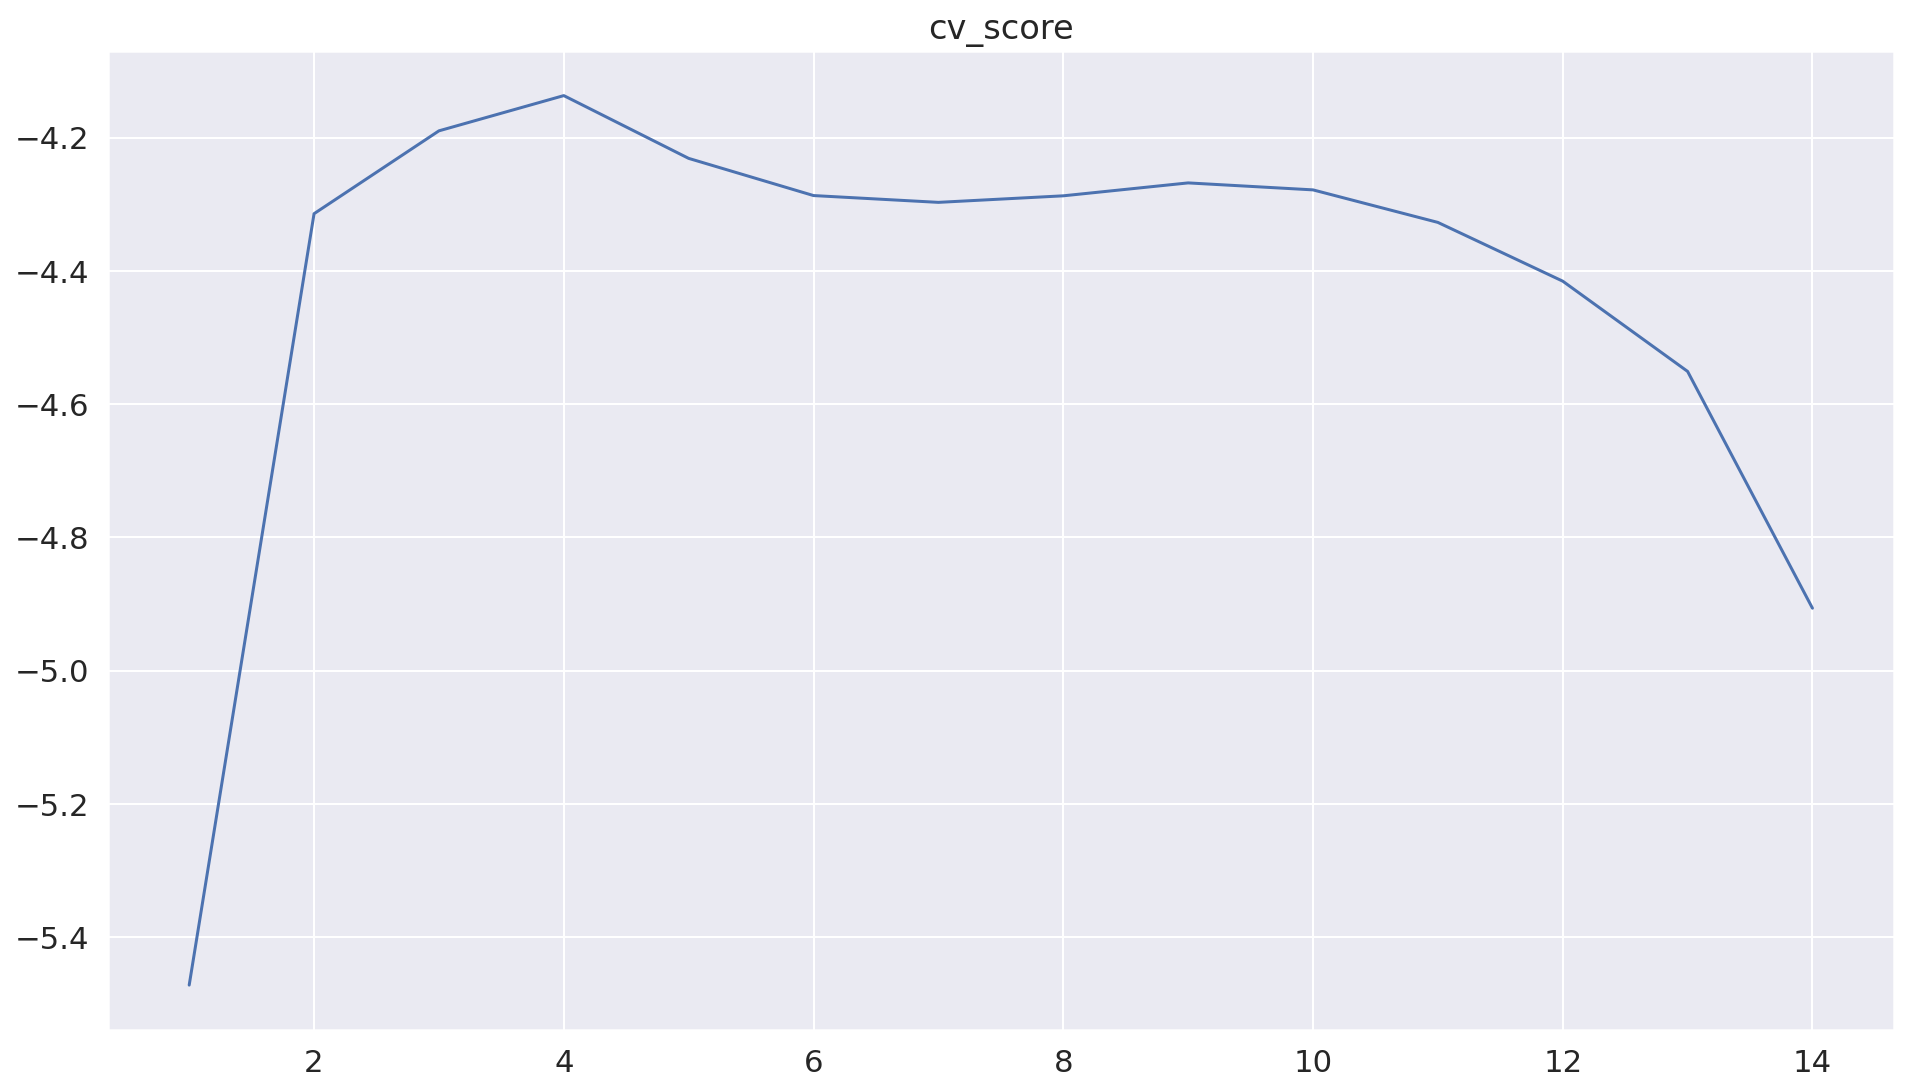

In [42]:
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, k  + 1), cv_scores)
plt.title('cv_score')
plt.show()

Если взять 4 фичи, получаем самый достойный результат.

In [43]:
tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100, random_state = 1),n_features_to_select=4,  step=1)
X_mod = tree.fit_transform(X, y)
X_mod = X[X.columns[tree.support_]]
model_mod = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
cv, _ = train_and_test_cv(model_mod, None, "Linear", X_mod, y, False)
cv

cv score  --  -4.137016739741544


-4.137016739741544

Посмотрим на остатки:

In [44]:
err = find_student_remainders(model_mod, X_mod, y)

Text(0.5, 1.0, 'Распределение стьюдентизированных остатков')

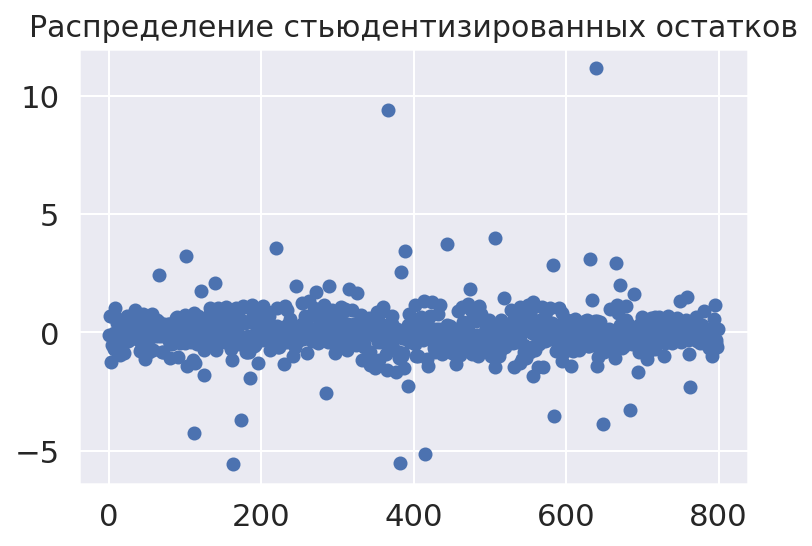

In [45]:
plt.plot(err, 'o')
plt.title("Распределение стьюдентизированных остатков", fontsize=15)

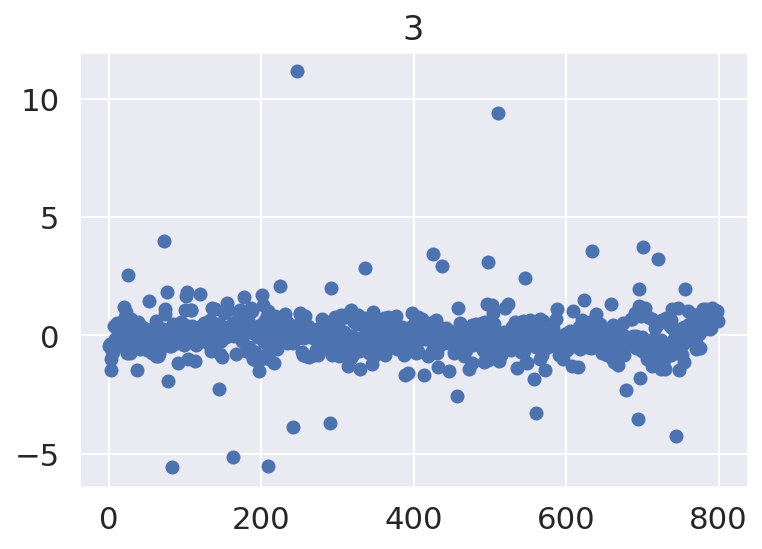

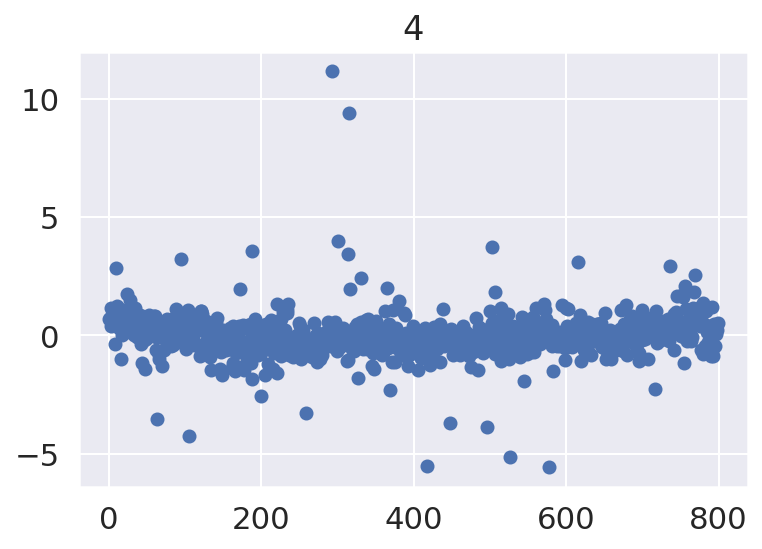

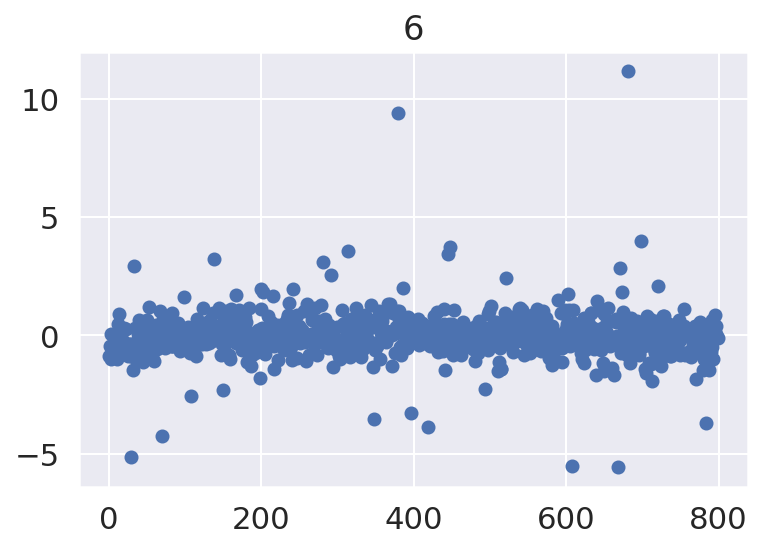

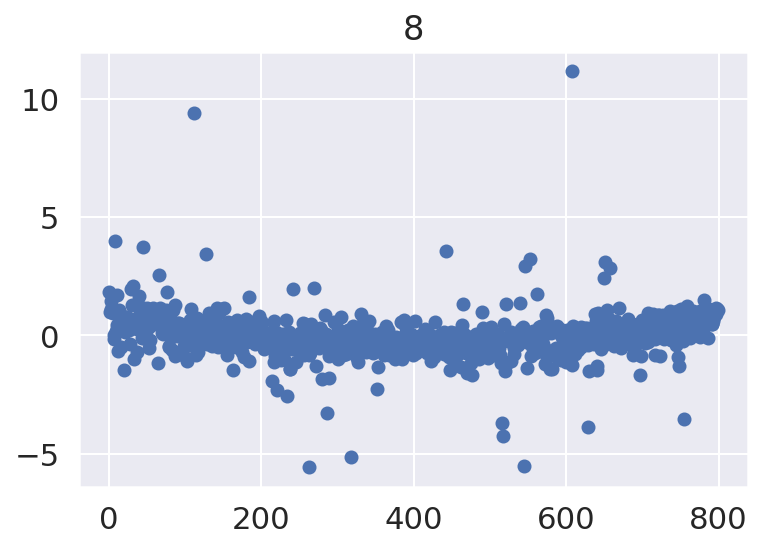

In [46]:
for i in range(X_mod.shape[1]):
    plt.figure()
    plt.plot(err[X_mod.values[:, i].argsort()], 'o')
    plt.title(X_mod.columns[i])

Как видим, есть выбросы. Посмотрим на распределение y:

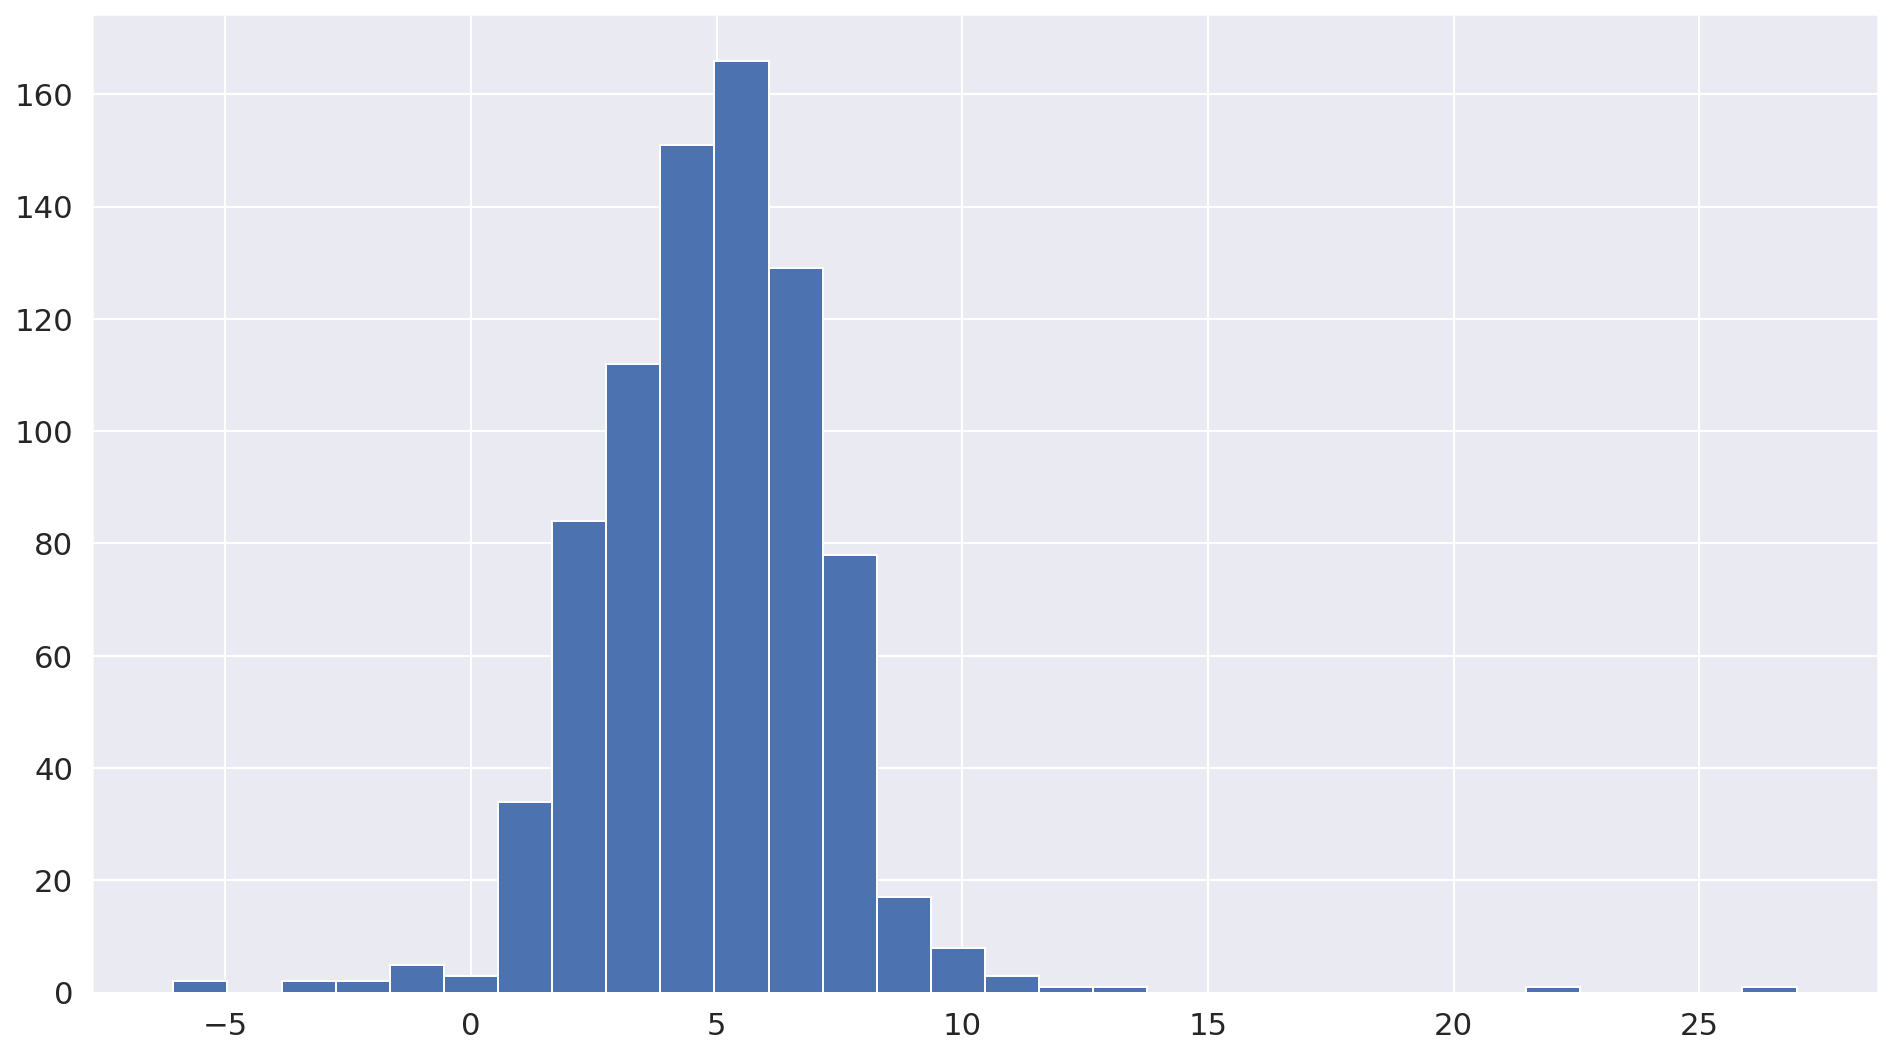

In [47]:
plt.figure(figsize = (16, 9))
plt.hist(y, bins = 30)
plt.show()

In [48]:
X_mod2 = X_mod[(y < 15) & (y > -5)]
y_mod2  = y[(y < 15) & (y > -5)]
print(len(y), len(y_mod2))
model_mod2 = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
cv, _ = train_and_test_cv(model_mod2, None, "Linear", X_mod2, y_mod2, False)
cv

800 796
cv score  --  -2.767989049820544


-2.767989049820544

Убрали всего лишь 4 измерения, а какое улучшение!

In [49]:
err = find_student_remainders(model_mod2, X_mod2, y_mod2)

Text(0.5, 1.0, 'Распределение стьюдентизированных остатков')

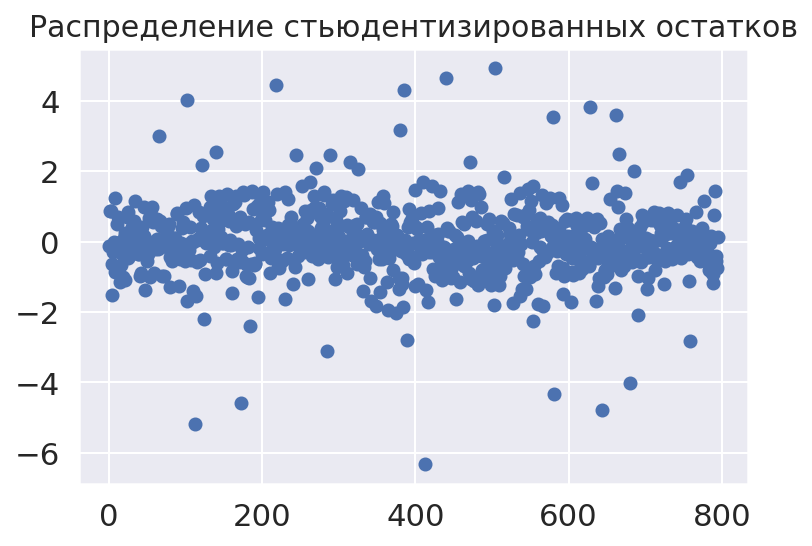

In [50]:
plt.plot(err, 'o')
plt.title("Распределение стьюдентизированных остатков", fontsize=15)

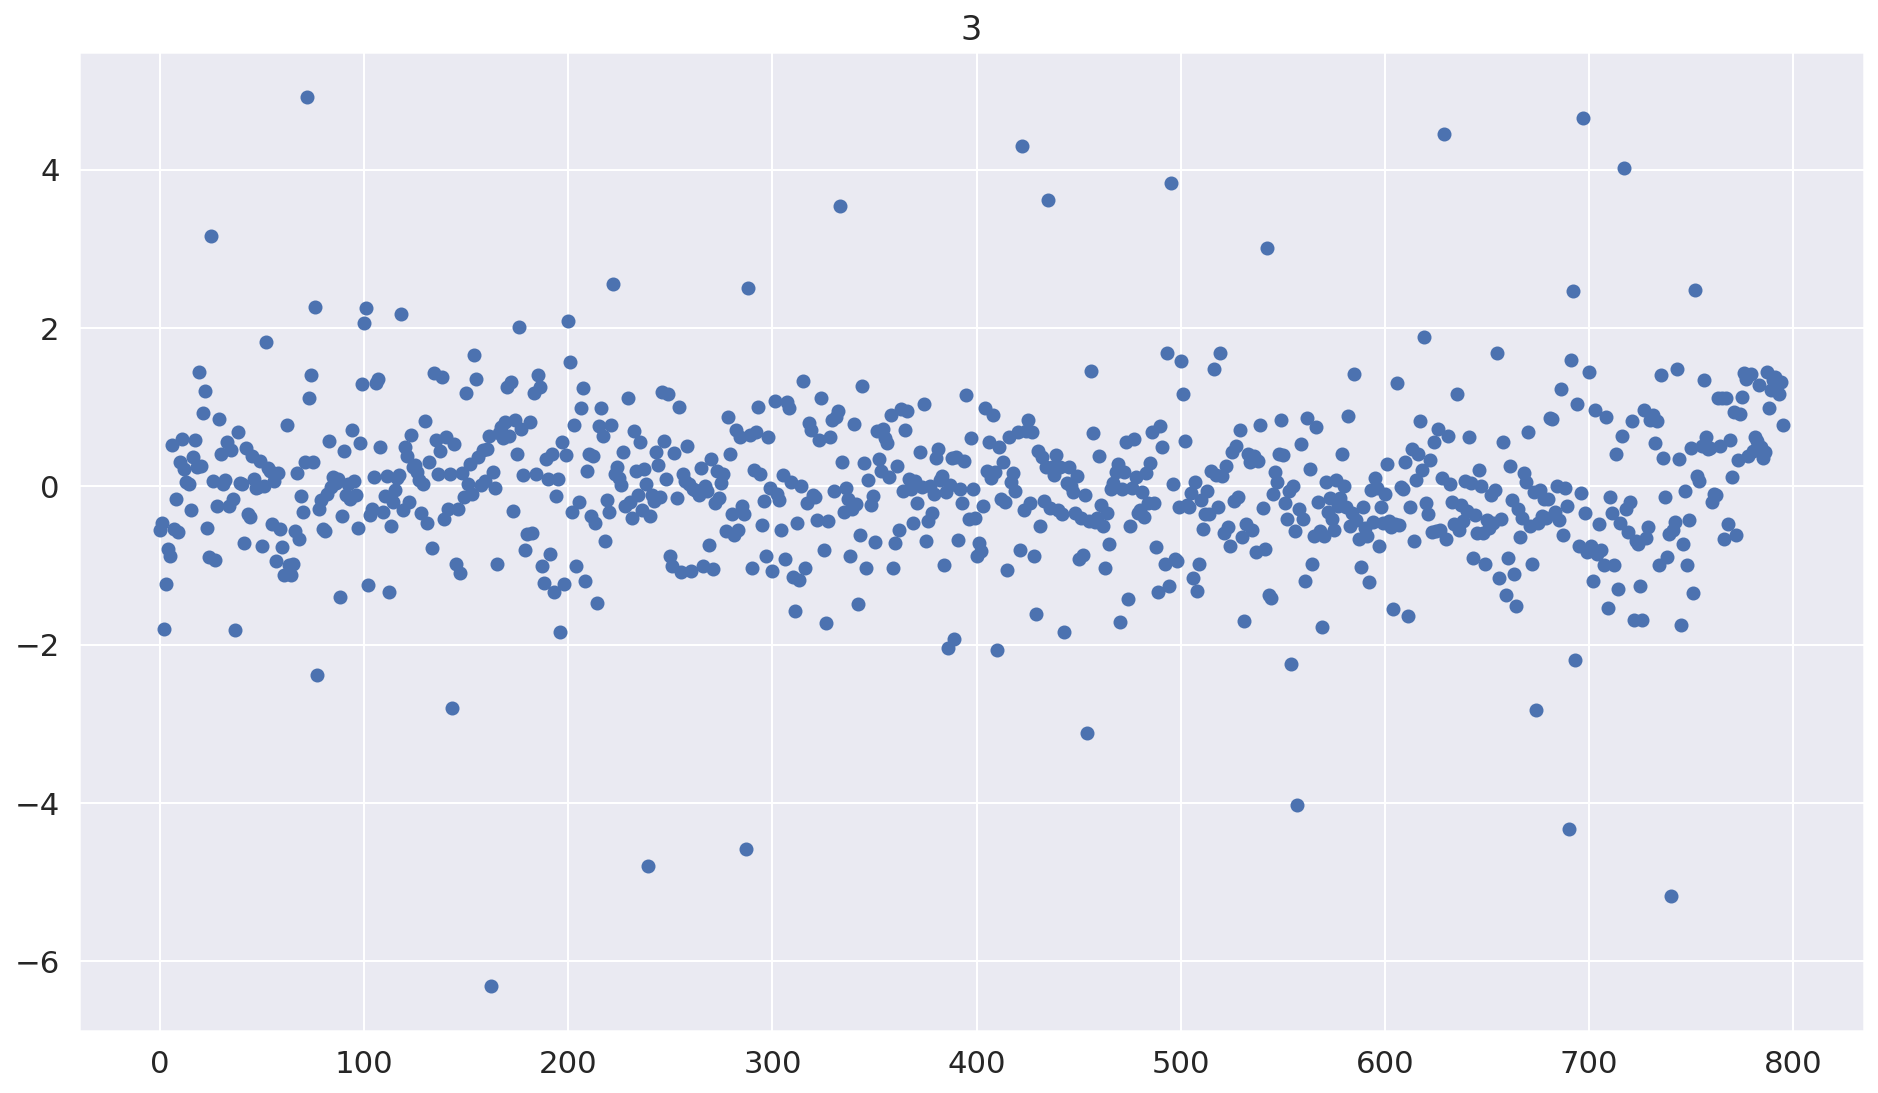

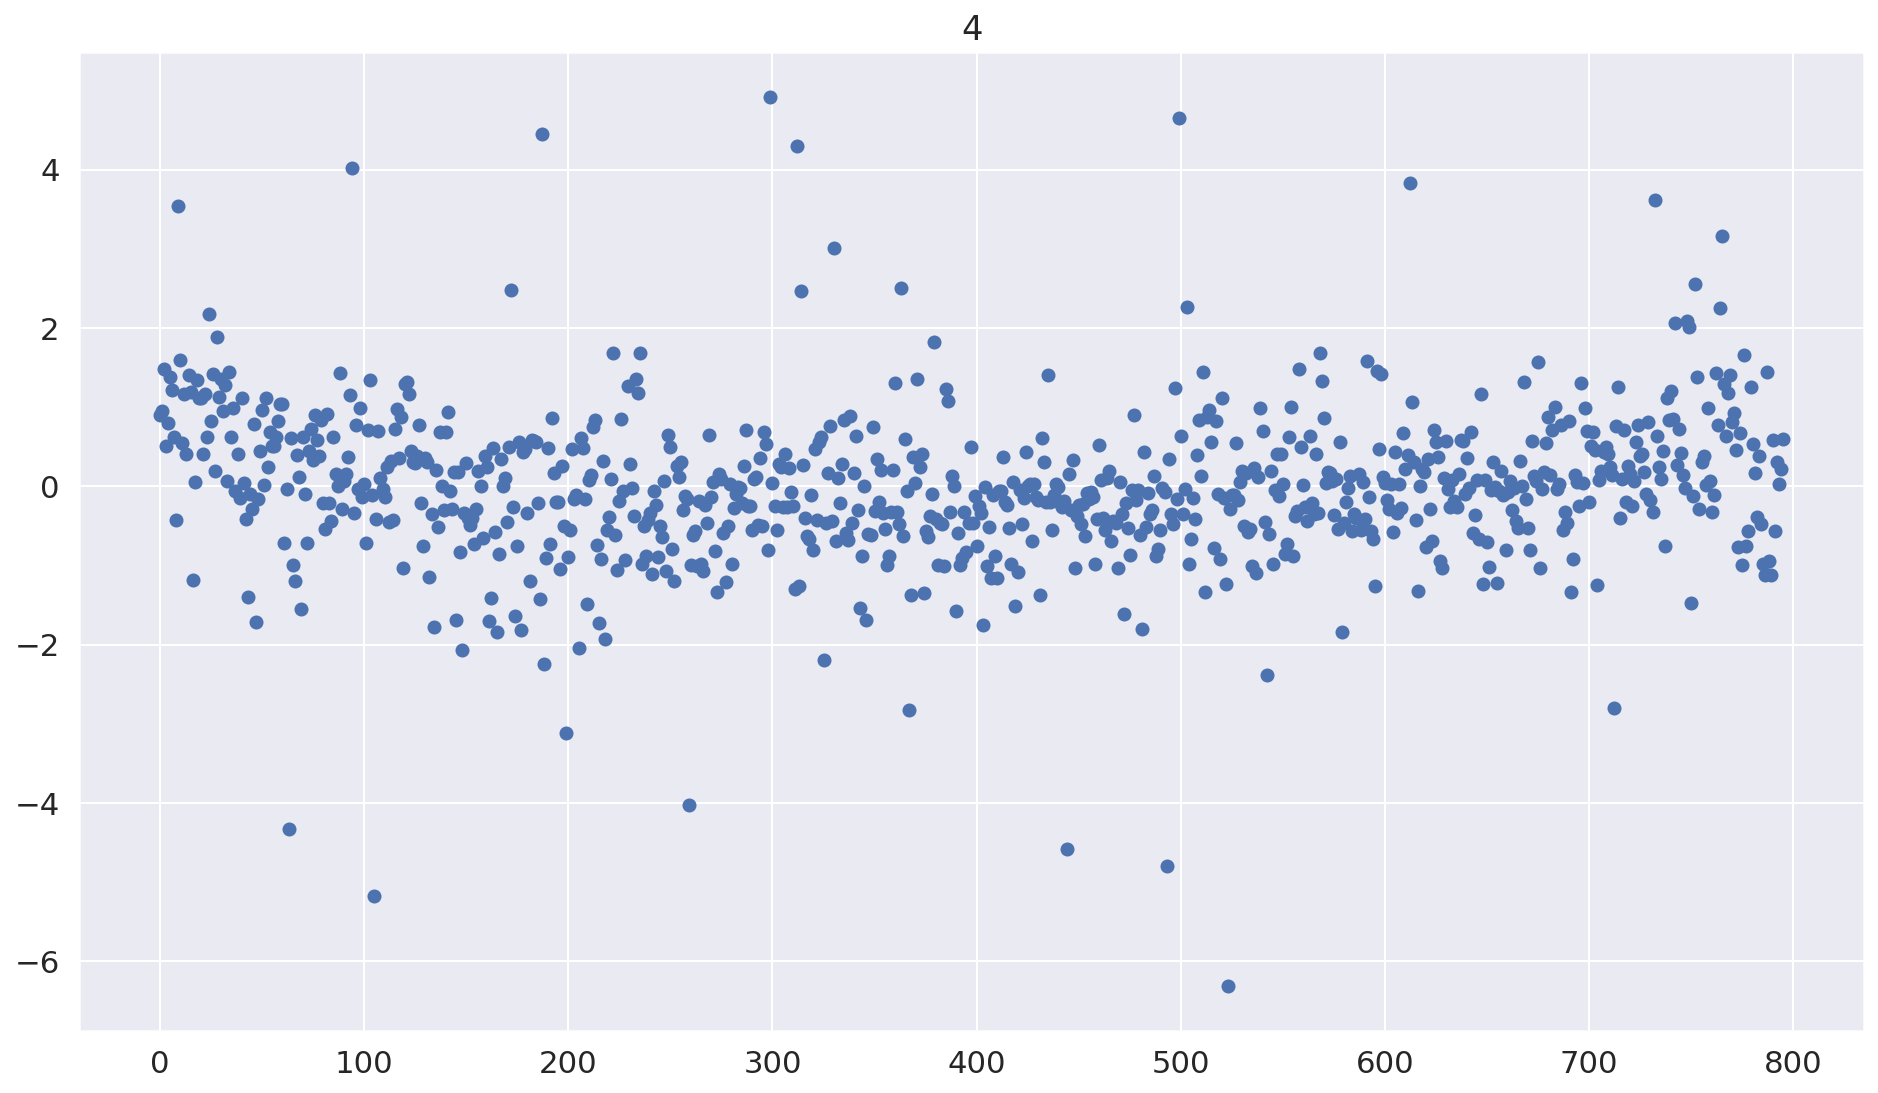

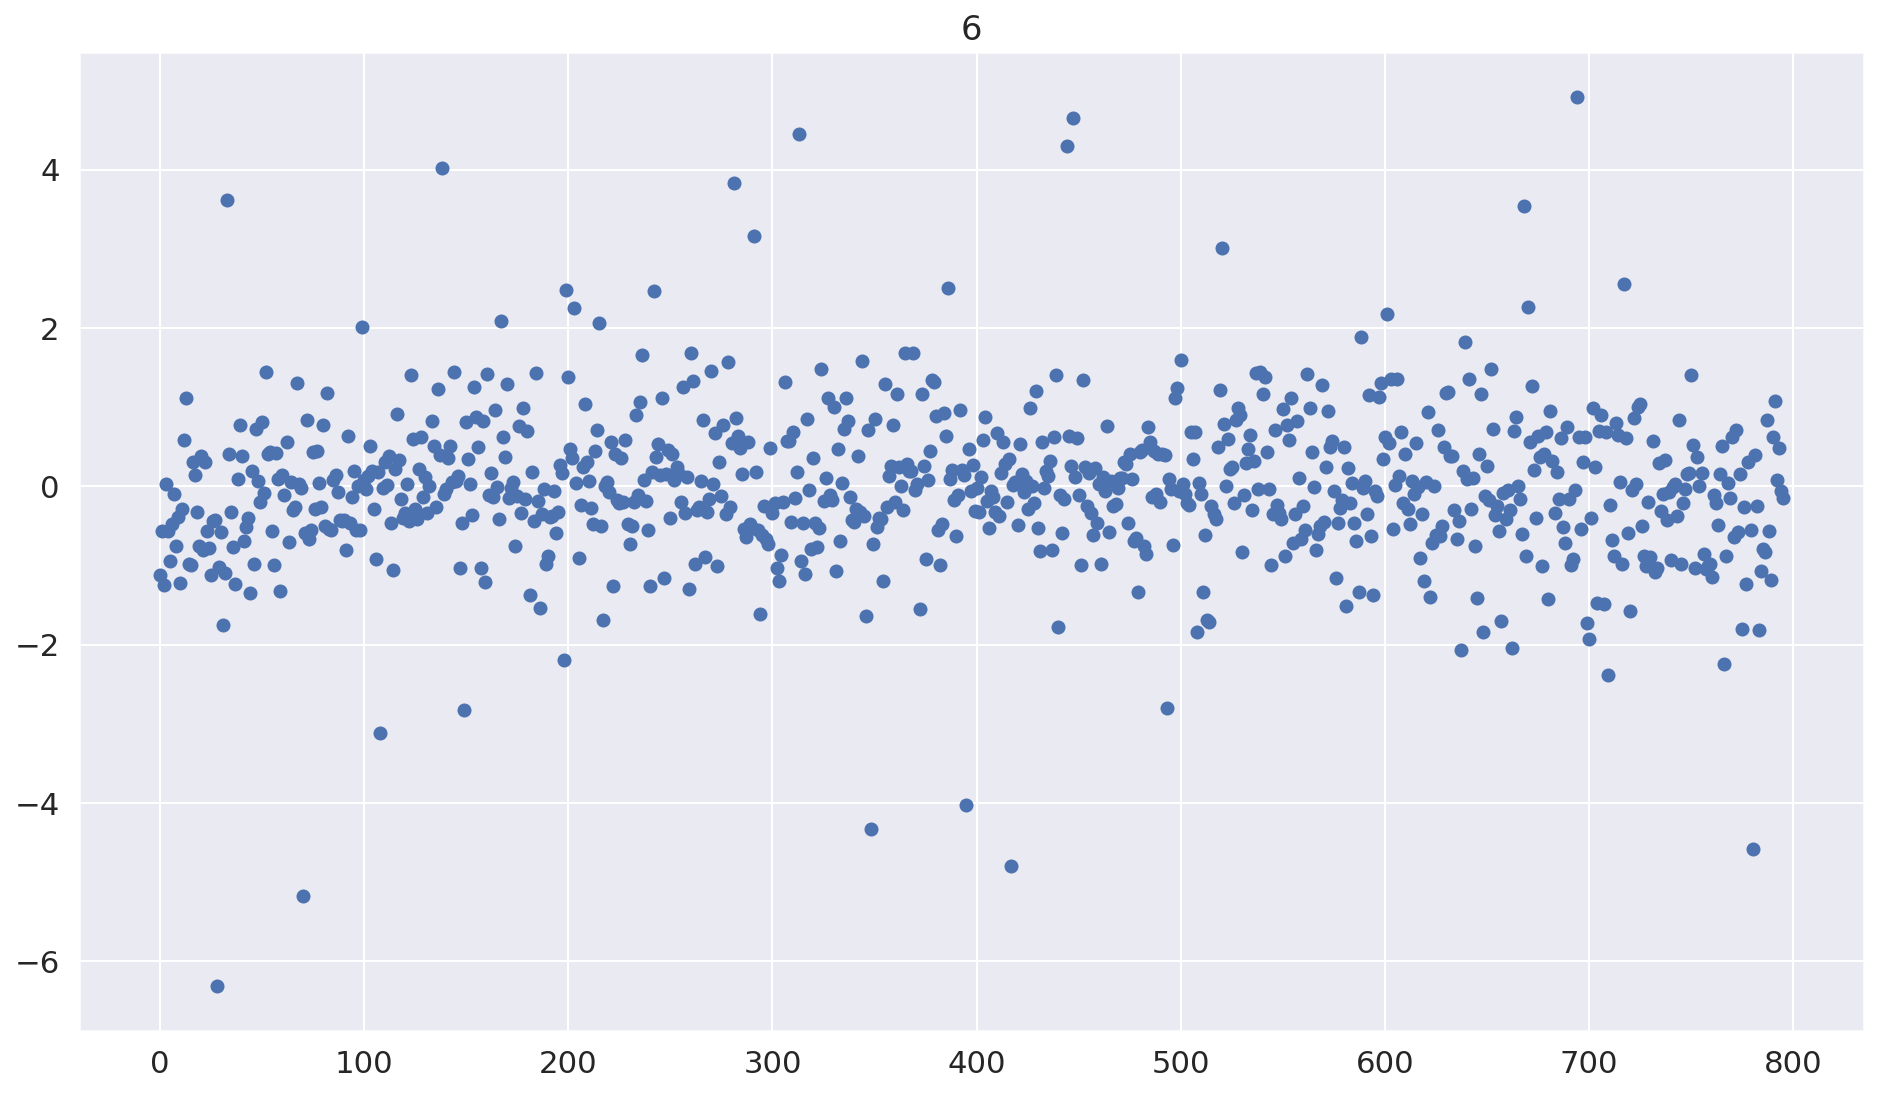

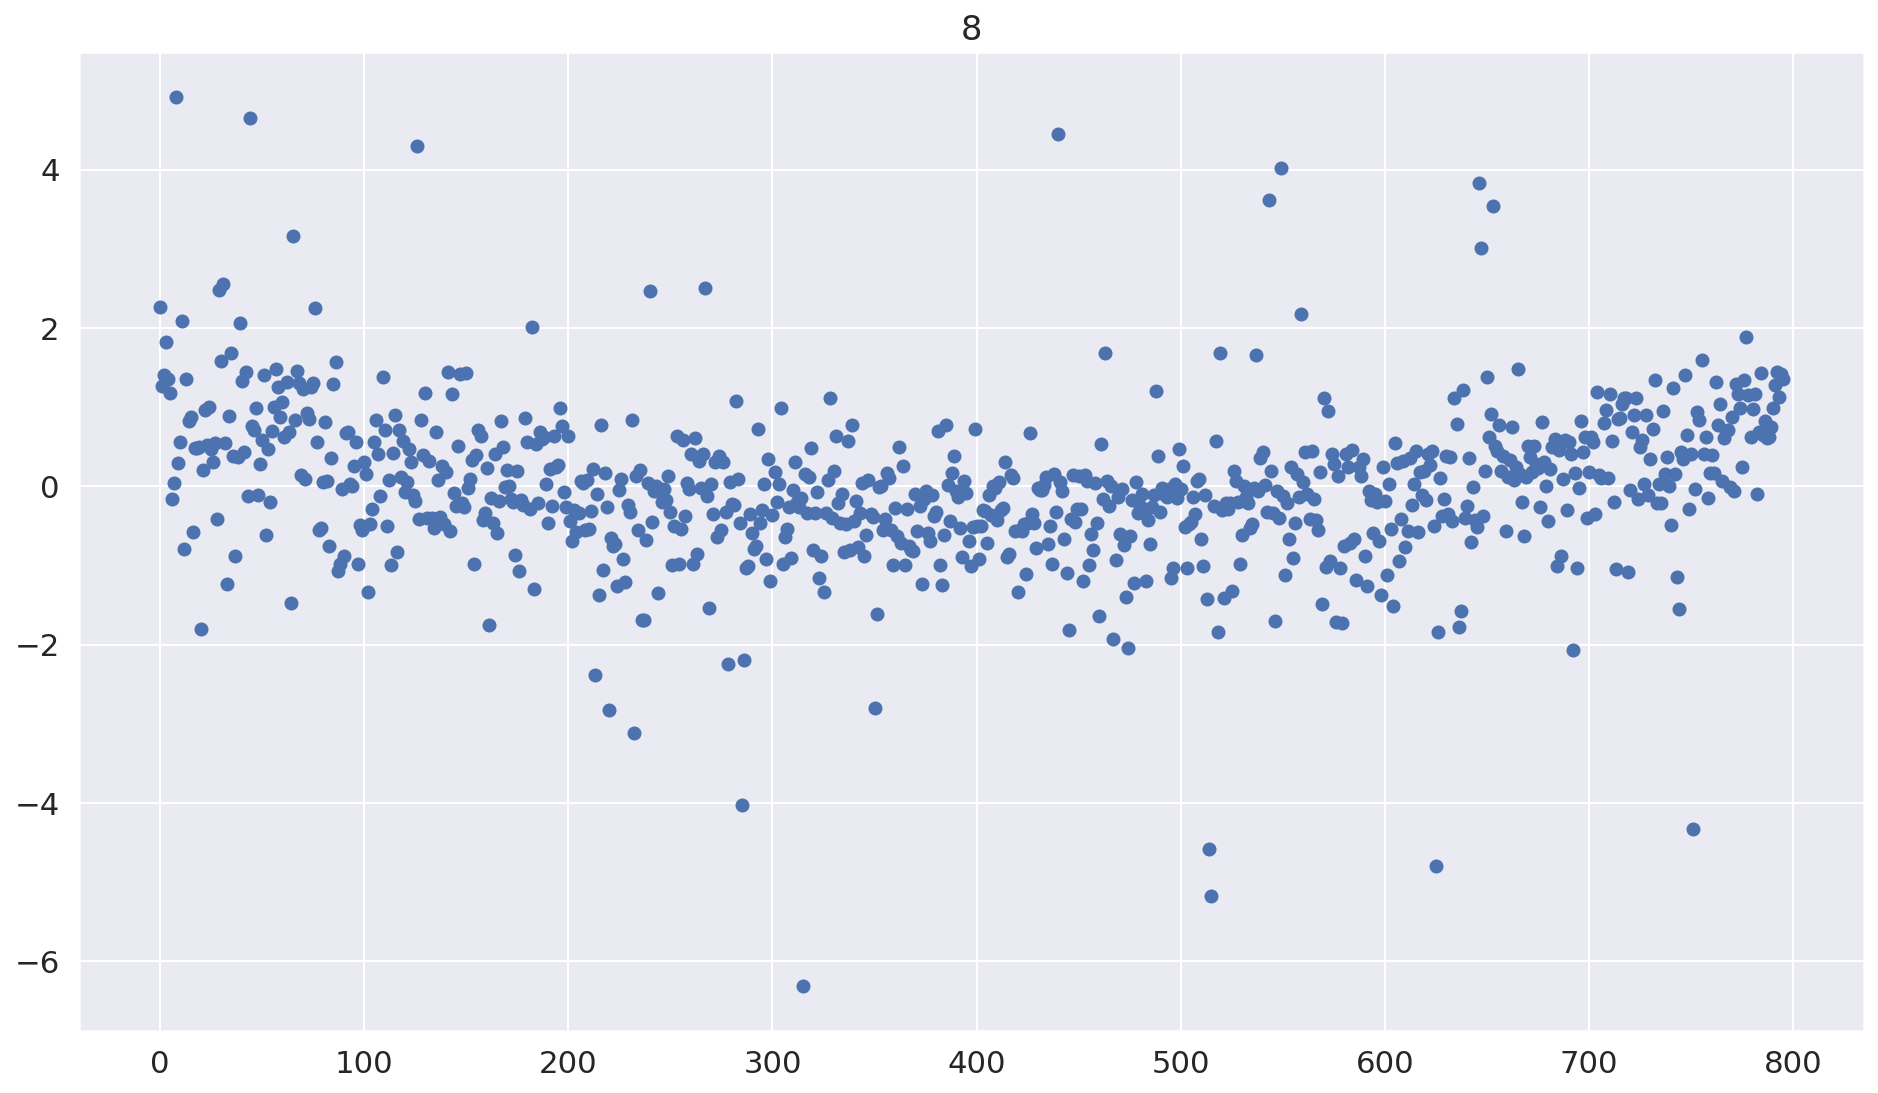

In [51]:
for i in range(X_mod2.shape[1]):
    plt.figure(figsize = (16, 9))
    plt.plot(err[X_mod2.values[:, i].argsort()], 'o')
    plt.title(X_mod2.columns[i])

Видно, что не помешает квадратичные признаки.

In [52]:
X_mod3 = X_mod2.copy()
for col in X_mod2:
    X_mod3[col + 'sqr'] = X_mod2[col] ** 2
model_mod3 = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
cv, _ = train_and_test_cv(model_mod3, None, "Linear", X_mod3, y_mod2, False)
cv

cv score  --  -1.9755398173600085


-1.9755398173600085

Отлично!! Осталось посмотреть, что скажет регуляризация

In [53]:
parameters = {'Model__alpha': np.append(np.arange(0.2, 20.1, 0.05), np.logspace(-6, -3, 4))}
model_r = make_basic_pipeline(Ridge(fit_intercept=True)) 
cv, _ = train_and_test_cv(model_r, parameters, "Ridge", X_mod3, y_mod2, True)
cv

Best parameters: {'Model__alpha': 2.8499999999999996}
cv score  --  -1.9752899291848038


-1.9752899291848038

In [54]:
parameters = {'Model__alpha': np.append(np.arange(0.01, 3, 0.01), np.logspace(-6, -3, 4))}
model_l = make_basic_pipeline(Lasso(fit_intercept=True)) 
cv, model_l = train_and_test_cv(model_l, parameters, "Lasso", X_mod3, y_mod2, True)
cv

Best parameters: {'Model__alpha': 0.02}
cv score  --  -1.9599718963803237


-1.9599718963803237

In [55]:
X_mod3

3      4      6      8       3sqr       4sqr      6sqr      8sqr
0   -3.639  0.418  1.779  1.627  13.242321   0.174724  3.164841  2.647129
1   -3.327  0.496  1.365  1.933  11.068929   0.246016  1.863225  3.736489
2   -2.120  0.894  0.147  1.559   4.494400   0.799236  0.021609  2.430481
3   -2.287  1.809  1.012  1.060   5.230369   3.272481  1.024144  1.123600
4   -2.598  1.938  1.062  0.764   6.749604   3.755844  1.127844  0.583696
..     ...    ...    ...    ...        ...        ...       ...       ...
795 -2.027  2.157 -0.211  0.086   4.108729   4.652649  0.044521  0.007396
796 -2.263  3.344 -0.625  0.926   5.121169  11.182336  0.390625  0.857476
797 -2.594  2.584 -0.524  0.515   6.728836   6.677056  0.274576  0.265225
798 -2.702  3.596 -1.041  1.009   7.300804  12.931216  1.083681  1.018081
799 -3.440  3.203 -0.860  1.503  11.833600  10.259209  0.739600  2.259009

[796 rows x 8 columns]

In [56]:
all_X_rfe = all_X[all_X.columns[tree.support_]]
for col in all_X_rfe:
    all_X_rfe[col + 'sqr'] = all_X_rfe[col] ** 2
y_pred = model_l.predict(all_X_rfe)
res_fr = pd.DataFrame({'y': y_pred})
res_fr.to_csv("h10t3_res.csv", index = True)

Lasso нам дало еще немного.

Теперь посмотрим, что даст на  непараметрическая регрессия.

In [57]:
def grid_kernel(ker, grid, X, y):
    best_gamma = -5
    best_score = -10000
    grid = np.linspace(1e-5, 8, 200)
    for g in grid:
        model = make_basic_pipeline(KernelRegression(kernel = ker, gamma = g))
        cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5).mean()
        if cv_score > best_score:
            best_gamma = g
            best_score = cv_score
    return best_gamma, best_score

In [58]:
best_gamma, best_score =  grid_kernel('laplacian', np.linspace(1e-5, 8, 100), X , y)
print("Best gamma -- ", best_gamma)
print("Cv_score -- ", best_score)

Best gamma --  0.6432252763819095
Cv_score --  -3.9809714124402737


Пока не очень убедительно. Но давайте попробуем убрать выбросы и посмотреть на результат.

In [59]:
X_mod2 = X[(y < 15) & (y > -5)]
y_mod2  = y[(y < 15) & (y > -5)]
print(len(y), len(y_mod2))
best_gamma, best_score =  grid_kernel('laplacian', np.linspace(1e-5, 8, 100), X_mod2 , y_mod2)
print("Best gamma -- ", best_gamma)
print("Cv_score -- ", best_score)

800 796
Best gamma --  0.7638281407035176
Cv_score --  -2.4987707115397795


In [60]:
X_mod2 = X[(y < 15) & (y > -5)]
y_mod2  = y[(y < 15) & (y > -5)]
print(len(y), len(y_mod2))
best_gamma, best_score =  grid_kernel('rbf', np.linspace(1e-5, 8, 100), X_mod2 , y_mod2)
print("Best gamma -- ", best_gamma)
print("Cv_score -- ", best_score)

800 796
Best gamma --  0.44222050251256284
Cv_score --  -2.5782791637493845


Стоит также попробовать произвести отбор признаков.

In [61]:
forest = ExtraTreesRegressor(n_estimators=100)
forest.fit(X_mod2, y_mod2)
forest.feature_importances_

array([0.01454795, 0.02029783, 0.01574463, 0.09587578, 0.23645939,
       0.0444065 , 0.09202332, 0.04103084, 0.19996381, 0.04501706,
       0.04102125, 0.04013883, 0.04281242, 0.07066041])

In [62]:
k = X_mod2.shape[1]
print(k)
ker, grid = 'laplacian', np.linspace(1e-5, 8, 100)
cv_scores = []


for features_count in range(1, k + 1):
    print('------------------------------------------------------')
    print('features number -- ', features_count)
    tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100), n_features_to_select=features_count, step=1)
    X_rfe = tree.fit_transform(X_mod2, y_mod2)
    _, cv = grid_kernel(ker,grid, X_rfe , y_mod2)
    print(cv)
    cv_scores.append(cv)
    print('------------------------------------------------------')

14
------------------------------------------------------
features number --  1
-3.2915426042157634
------------------------------------------------------
------------------------------------------------------
features number --  2
-2.333562977947693
------------------------------------------------------
------------------------------------------------------
features number --  3
-2.367993499911273
------------------------------------------------------
------------------------------------------------------
features number --  4
-2.1964020737260044
------------------------------------------------------
------------------------------------------------------
features number --  5
-2.234382794477077
------------------------------------------------------
------------------------------------------------------
features number --  6
-2.3450350679906675
------------------------------------------------------
------------------------------------------------------
features number --  7
-2.29576177

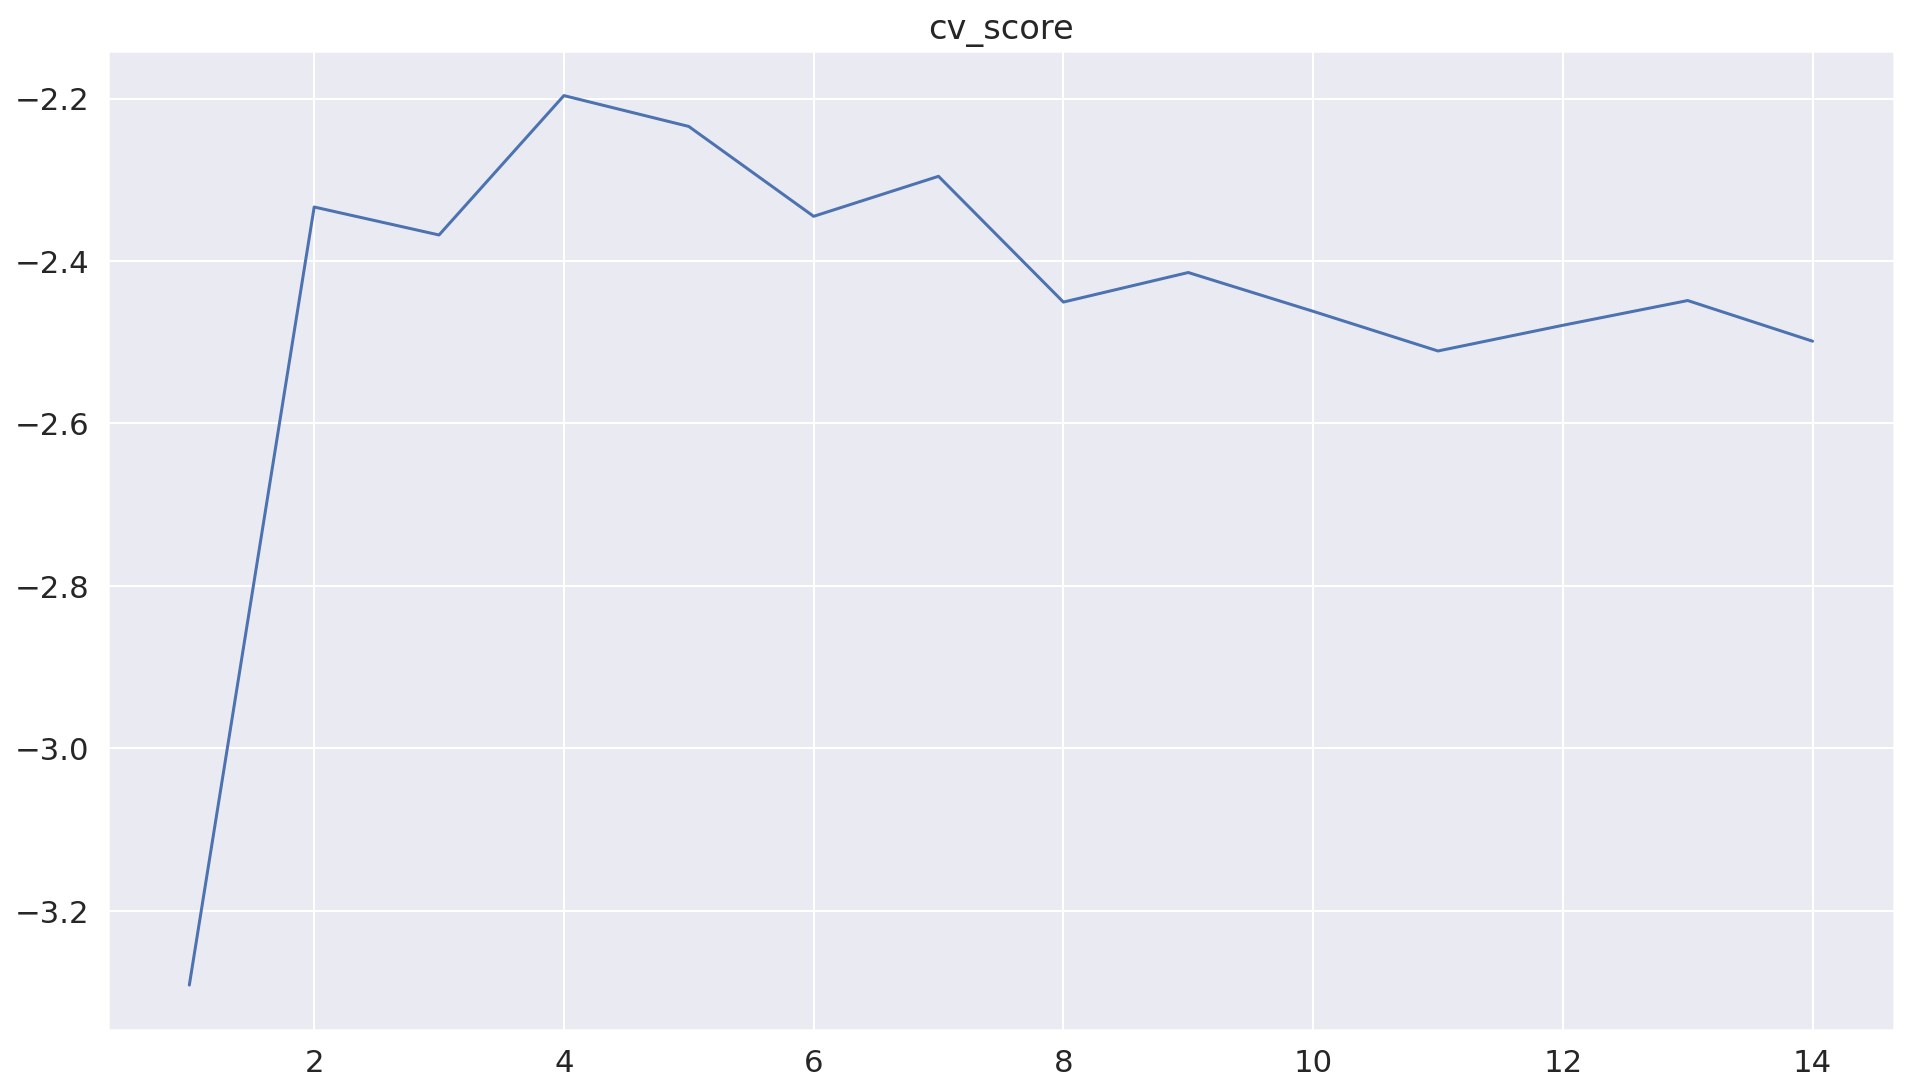

In [63]:
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, k  + 1), cv_scores)
plt.title('cv_score')
plt.show()

Снова, 4 признака являются самыми описывающими.

In [64]:
ker, grid = 'laplacian', np.linspace(1e-5, 8, 100)

tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100, random_state = 1),n_features_to_select=4,  step=1)
X_mod3 = tree.fit_transform(X_mod2, y_mod2)
X_mod3 = X_mod2[X_mod2.columns[tree.support_]]
gamma, cv = grid_kernel(ker,grid, X_mod3 , y_mod2)
model3 = make_basic_pipeline(KernelRegression(kernel = ker, gamma = gamma))
model3.fit(X_mod3, y_mod2)
cv

-2.1964020737260044

Получили хороший результат,но слабее, чем у линейной регресии с преобразованными признаками. Посмотрим, что покажет алгоритм настройки.

In [65]:
def grid_returning(ker, grid_it, grid_g, X, y):
    X_s = StandardScaler().fit_transform(X)
    best_gamma = -5
    best_it = -1
    best_score = -10000
    for iters in grid_it:
        for g in grid_g:
            model = Returning(g = g, num_iter=iters, ker = ker)
            cv_score = cross_val_score(model,X_s, y, scoring='neg_mean_squared_error', cv=5).mean()
            if cv_score > best_score:
                best_gamma = g
                best_score = cv_score
                best_it = iters
    print(f"Best gamma -- {best_gamma}, best number of iters -- {best_it} ")
    print("Cv_score -- ", best_score)
    return best_it, best_gamma, best_score

In [66]:
best_it, best_gamma, best_score = grid_returning('laplacian', np.arange(1, 5), np.linspace(1e-5, 1, 30), X, y)
print("Best gamma -- ", best_gamma, best_it)
print("Cv_score -- ", best_score)

Best gamma -- 1e-05, best number of iters -- 4 
Cv_score --  -4.05238971944219
Best gamma --  1e-05 4
Cv_score --  -4.05238971944219


In [67]:
X_mod2 = X[(y < 15) & (y > -5)]
y_mod2  = y[(y < 15) & (y > -5)]
print(len(y), len(y_mod2))
best_it, best_gamma, best_score = grid_returning('laplacian', np.arange(1, 4),
                                                 np.linspace(1e-4, 1, 30), X_mod2, y_mod2)
print("Best gamma -- ", best_gamma, best_it)
print("Cv_score -- ", best_score)

800 796
Best gamma -- 0.0001, best number of iters -- 3 
Cv_score --  -2.276258871449181
Best gamma --  0.0001 3
Cv_score --  -2.276258871449181


In [68]:
forest = ExtraTreesRegressor(n_estimators=100)
forest.fit(X_mod2, y_mod2)
forest.feature_importances_

array([0.01370775, 0.02165826, 0.01649136, 0.102278  , 0.22596561,
       0.04619118, 0.10049332, 0.04123508, 0.19012551, 0.04197492,
       0.04196991, 0.03871268, 0.04220781, 0.07698861])

In [69]:
tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100, random_state = 1),n_features_to_select=4,  step=1)
X_mod3 = tree.fit_transform(X_mod2, y_mod2)
X_mod3 = X_mod2[X_mod2.columns[tree.support_]]
best_it, best_gamma, best_score = grid_returning('laplacian', np.arange(1, 4),
                                                 np.linspace(1e-4, 1, 30), X_mod3, y_mod2)
best_score

Best gamma -- 0.0001, best number of iters -- 3 
Cv_score --  -1.9797726421458042


-1.9797726421458042

**Вывод:** Как видим, лучший результат получила линейная регрессия с продвинутым engenering. Это подтверждает тот факт, что несмотря на кажующаюся слабость данной модели, в некоторых случаях в совокупности с некоторыми трюками с помощью этой модели можно получать достойные результаты.